In [ ]:
!pip install pandas numpy scikit-learn matplotlib scipy
!pip install --upgrade pandas
!pip install --upgrade numpy
!pip install --upgrade scikit-learn
!pip install --upgrade matplotlib
!pip install --upgrade scipy
! pip install qiskit-algorithms
! pip install --upgrade qiskit qiskit-aer qiskit-terra
!pip install qiskit qiskit-aer
!pip install --upgrade qiskit

In [150]:
 python.exe -m pip install

SyntaxError: invalid syntax (2902645784.py, line 1)

In [155]:
!pip install tensorflow

ERROR: Could not find a version that satisfies the requirement tensorflow (from versions: none)

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: No matching distribution found for tensorflow


In [152]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io
from itertools import product

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, LeaveOneOut
from sklearn.datasets import load_iris
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge, Lasso

ModuleNotFoundError: No module named 'tensorflow'

In [3]:
import pandas as pd
df = pd.read_csv("C:/analysis/processed_data/NRD_2019/processed_NRD_2019_Core.CSV")


KeyboardInterrupt: 

In [7]:
import pandas as pd

# File path
file_path = "C:/analysis/processed_data/NRD_2019/processed_NRD_2019_Core.CSV"

# Process the file in chunks without storing all chunks in memory
# Define a function to process each chunk as needed
def process_chunk(chunk):
    # Add your processing logic here
    # For example: filtering, transformations, etc.
    return chunk

# Option 1: Write processed chunks directly to a new CSV file
output_file = "C:/analysis/processed_data/NRD_2019/processed_output.csv"
first_chunk = True

for chunk in pd.read_csv(file_path, dtype=str, chunksize=100000):
    processed_chunk = process_chunk(chunk)
    
    # Write with header only for the first chunk
    processed_chunk.to_csv(
        output_file, 
        mode='w' if first_chunk else 'a',
        header=first_chunk,
        index=False
    )
    first_chunk = False

# Option 2: Process without concatenating, perform operations on each chunk
# For example, if you need to calculate aggregates
total_rows = 0
for chunk in pd.read_csv(file_path, dtype=str, chunksize=100000):
    # Process and count
    total_rows += len(chunk)
    # Other per-chunk operations...

print(f"Total rows processed: {total_rows}")

Total rows processed: 18132856


In [4]:
import pandas as pd
chuck = pd.read_csv("C:/analysis/processed_data/NRD_2019/processed_NRD_2019_Core.CSV")


KeyboardInterrupt: 

In [ ]:
chunk.head()

Only 5% data and converting Payers into buckeets that could then be used as integers. Also, added new column called LOS_CAL that calculates how many days a patient was at the hospital using the PRDAY1 to PRDAY25 columns.

In [57]:
import pandas as pd
import numpy as np
import gc  # Added for garbage collection
import os

# Check if input file exists
file_path = "C:/analysis/processed_data/NRD_2019/processed_NRD_2019_Core.CSV"
if not os.path.exists(file_path):
    print(f"Warning: Input file does not exist at {file_path}")

# Define chunk size and create chunks iterator
chunk_size = 100000
chunks = pd.read_csv(file_path, dtype=str, chunksize=chunk_size)

# Initialize tracking variables
total_rows = 0
sample_rows = 0
first_chunk = True
chunk_count = 0

# Output file path
output_file = "processed_samples.csv"

# Process each chunk
for chunk in chunks:
    chunk_count += 1
    print(f"Processing chunk #{chunk_count} with {len(chunk)} rows")
    
    # 1. Get numeric columns - convert string columns to numeric first
    for col in chunk.columns:
        chunk[col] = pd.to_numeric(chunk[col], errors='coerce')
    
    numeric_columns = chunk.select_dtypes(include=['int64', 'float64']).columns
    df_chunk = chunk[numeric_columns].copy()
    
    # 2. Convert and bucket PAY1 if it exists
    if 'PAY1' in chunk.columns:
        df_chunk['PAY1'] = pd.cut(df_chunk['PAY1'], 
                             bins=[-float('inf'), 1, 2, 3, 4, 5, 6, float('inf')],
                             labels=[1, 2, 3, 4, 5, 6, 7])
    
    # 3. Create LOS_CAL column based on procedure days
    prday_cols = [col for col in chunk.columns if col.startswith('PRDAY')]
    
    # Initialize LOS_CAL with zeros
    df_chunk['LOS_CAL'] = 0
    
    if prday_cols:
        # Calculate LOS_CAL as the maximum procedure day
        prday_values = df_chunk[prday_cols].copy()
        prday_values[prday_values < 0] = np.nan  # Replace negative values with NaN
        df_chunk['LOS_CAL'] = prday_values.max(axis=1) + 1  # Add 1 to include admission day
        
        # Fill NaN values with the original LOS if available
        if 'LOS' in chunk.columns:
            df_chunk['LOS_CAL'] = df_chunk['LOS_CAL'].fillna(df_chunk['LOS'])
        
        # Bucket LOS_CAL into ranges
        df_chunk['LOS_CAL_BUCKET'] = pd.cut(df_chunk['LOS_CAL'],
                            bins=[-float('inf'), 1, 3, 7, 14, 30, float('inf')],
                            labels=[1, 2, 3, 4, 5, 6])
        
        # Clean up the large temporary dataframe
        del prday_values
    
    # 4. Convert and bucket original LOS
    if 'LOS' in chunk.columns:
        df_chunk['LOS_BUCKET'] = pd.cut(df_chunk['LOS'],
                            bins=[-float('inf'), 1, 3, 7, 14, 30, float('inf')],
                            labels=[1, 2, 3, 4, 5, 6])
    
    # 5. Take 5% random sample
    df_sample = df_chunk.sample(frac=0.05, random_state=42)
    
    # 6. Write sample directly to file (memory-efficient approach)
    df_sample.to_csv(
        output_file, 
        mode='w' if first_chunk else 'a',
        header=first_chunk,
        index=False
    )
    
    # Update tracking variables
    total_rows += len(chunk)
    sample_rows += len(df_sample)
    first_chunk = False
    
    # Print progress
    print(f"Processed chunk with {len(chunk)} rows, sampled {len(df_sample)} rows")
    
    # Clear memory
    del df_chunk
    #del df_sample
    gc.collect()  # Force garbage collection

print(f"Finished processing {total_rows} total rows")

# Fixed the ZeroDivisionError with a check
if total_rows > 0:
    print(f"Created sample dataset with {sample_rows} rows ({(sample_rows/total_rows)*100:.2f}% of original)")
else:
    print("No rows were processed. Check if your input data is empty or if there's an issue with the chunks iterator.")

print(f"Sample saved to: {output_file}")

# To read the processed sample file later:
# processed_sample = pd.read_csv(output_file)

Processing chunk #1 with 100000 rows
Processed chunk with 100000 rows, sampled 5000 rows
Processing chunk #2 with 100000 rows
Processed chunk with 100000 rows, sampled 5000 rows
Processing chunk #3 with 100000 rows
Processed chunk with 100000 rows, sampled 5000 rows
Processing chunk #4 with 100000 rows
Processed chunk with 100000 rows, sampled 5000 rows
Processing chunk #5 with 100000 rows
Processed chunk with 100000 rows, sampled 5000 rows
Processing chunk #6 with 100000 rows
Processed chunk with 100000 rows, sampled 5000 rows
Processing chunk #7 with 100000 rows
Processed chunk with 100000 rows, sampled 5000 rows
Processing chunk #8 with 100000 rows
Processed chunk with 100000 rows, sampled 5000 rows
Processing chunk #9 with 100000 rows
Processed chunk with 100000 rows, sampled 5000 rows
Processing chunk #10 with 100000 rows
Processed chunk with 100000 rows, sampled 5000 rows
Processing chunk #11 with 100000 rows
Processed chunk with 100000 rows, sampled 5000 rows
Processing chunk #1

To avoid having to rerun or reupload your dataframe each time, I save it to disk and use a function to load it only when needed. Here's how to do it:

In [81]:
# At the end of your current script, add:
df_sample.to_csv("C:/analysis/processed_data/NRD_2019/df_sample_cache.csv", index=False)
print(f"Dataframe saved to C:/analysis/processed_data/NRD_2019/df_sample_cache.csv")

Dataframe saved to C:/analysis/processed_data/NRD_2019/df_sample_cache.csv


Create a helper function to load the dataframe

In [59]:
def get_df_sample():
    """Load the cached df_sample or create it if needed"""
    cache_path = "C:/analysis/processed_data/NRD_2019/df_sample_cache.csv"
    
    if os.path.exists(cache_path):
        print(f"Loading dataframe from cache: {cache_path}")
        return pd.read_csv(cache_path)
    else:
        print("Cache not found, creating df_sample...")
        # Put your original processing code here
        # ...
        
        # Save for future use
        df_sample.to_csv(cache_path, index=False)
        return df_sample

In [82]:
df_sample.head()

,AGE,AWEEKEND,DIED,DISCWT,DISPUNIFORM,DMONTH,DQTR,DRG,DRGVER,DRG_NoPOA,...,SAMEDAYEVENT,TOTCHG,YEAR,ZIPINC_QRTL,POINT_OF_ORIGIN_UNIF,PointOfOriginUB04,HOSPBRTH,LOS_CAL,LOS_CAL_BUCKET,LOS_BUCKET
18122575,87,1,0,1.305622,5,10,4,477,37,477,...,-99,-99,-99,0,1,0,345806,4.0,3,NaN
18119973,86,0,0,1.314531,1,10,4,406,37,406,...,-99,-99,-99,0,1,0,465908,1.0,1,NaN
18108604,54,0,0,1.343921,1,10,4,247,37,247,...,-99,-99,-99,0,1,0,634967,12.0,4,NaN
18121430,33,0,0,1.404646,1,1,1,807,36,807,...,-99,-99,-99,0,1,0,46436,1.0,1,NaN
18114149,84,0,0,1.314531,6,4,2,219,36,219,...,-99,-99,-99,0,1,0,979937,9.0,4,NaN


In [83]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1643 entries, 18122575 to 18102730
Columns: 128 entries, AGE to LOS_BUCKET
dtypes: category(3), float64(67), int64(58)
memory usage: 1.6 MB


interpolate all NAN, bank and missing values 

In [84]:
def interpolate_healthcare_data(df):
    """
    Fill in missing values in a healthcare dataset using interpolation and appropriate methods
    
    Args:
        df: Input dataframe
        
    Returns:
        DataFrame with imputed values
    """
    import pandas as pd
    import numpy as np
    
    print(f"Original data shape: {df.shape}")
    print(f"Missing values before interpolation: {df.isna().sum().sum()}")
    
    # Create a working copy
    imputed_df = df.copy()
    
    # 1. Replace placeholder values with NaN
    placeholder_values = [-99, -999, -9, 99, 999, 9999]
    for value in placeholder_values:
        for col in imputed_df.columns:
            if pd.api.types.is_numeric_dtype(imputed_df[col]):
                mask = imputed_df[col] == value
                if mask.any():
                    print(f"Replacing {mask.sum()} instances of {value} with NaN in {col}")
                    imputed_df.loc[mask, col] = np.nan
    
    # 2. Handle different column types appropriately
    for col in imputed_df.columns:
        missing = imputed_df[col].isna().sum()
        if missing == 0:
            continue  # Skip columns with no missing values
            
        print(f"Processing column {col} with {missing} missing values")
        
        # Check if column is categorical
        if isinstance(imputed_df[col].dtype, pd.CategoricalDtype):
            # For categorical type, handle appropriately
            if imputed_df[col].dropna().empty:
                # All values are missing, convert to string and fill
                print(f"  All values are NaN, converting to string")
                imputed_df[col] = imputed_df[col].astype(str)
                imputed_df[col] = imputed_df[col].fillna("Unknown")
            else:
                # Add 'Unknown' as a new category
                existing_cats = imputed_df[col].cat.categories.tolist()
                if 'Unknown' not in existing_cats:
                    imputed_df[col] = imputed_df[col].cat.add_categories(['Unknown'])
                # Fill with 'Unknown'
                imputed_df[col] = imputed_df[col].fillna('Unknown')
                
        # Handle numeric columns    
        elif pd.api.types.is_numeric_dtype(imputed_df[col]):
            if imputed_df[col].nunique() <= 10:  # Categorical numeric
                # Mode imputation
                if imputed_df[col].dropna().empty:
                    imputed_df[col] = imputed_df[col].fillna(0)
                else:
                    mode_val = imputed_df[col].mode().iloc[0]
                    imputed_df[col] = imputed_df[col].fillna(mode_val)
            else:  # Continuous numeric
                # Linear interpolation
                temp_col = imputed_df[col].interpolate(method='linear', limit_direction='both')
                
                # Fill any remaining missing values
                if temp_col.isna().any():
                    if imputed_df[col].dropna().empty:
                        temp_col = temp_col.fillna(0)
                    else:
                        median_val = imputed_df[col].median()
                        temp_col = temp_col.fillna(median_val)
                
                imputed_df[col] = temp_col
                
        # Handle object (string) columns
        else:
            if imputed_df[col].dropna().empty:
                imputed_df[col] = imputed_df[col].fillna("Unknown")
            else:
                mode_val = imputed_df[col].mode().iloc[0]
                imputed_df[col] = imputed_df[col].fillna(mode_val)
    
    # Final check for any remaining missing values
    final_missing = imputed_df.isna().sum().sum()
    print(f"\nMissing values after interpolation: {final_missing}")
    
    if final_missing > 0:
        print("Some missing values remain, applying final fill...")
        # Find columns with remaining missing values
        cols_with_missing = imputed_df.columns[imputed_df.isna().any()].tolist()
        
        # Last resort for any remaining missings
        for col in cols_with_missing:
            if pd.api.types.is_numeric_dtype(imputed_df[col]):
                imputed_df[col] = imputed_df[col].fillna(0)
            else:
                # Convert categorical to string if needed
                if isinstance(imputed_df[col].dtype, pd.CategoricalDtype):
                    imputed_df[col] = imputed_df[col].astype(str)
                imputed_df[col] = imputed_df[col].fillna("Unknown")
    
    print("Interpolation complete!")
    return imputed_df

# Apply the interpolation to your dataframe
df_interpolated = interpolate_healthcare_data(df_sample)

# Verify no missing values remain
print(f"\nVerifying interpolation success:")
print(f"Original missing values: {df_sample.isna().sum().sum()}")
print(f"After interpolation missing values: {df_interpolated.isna().sum().sum()}")

Original data shape: (1643, 128)
Missing values before interpolation: 111121
Replacing 27 instances of -99 with NaN in I10_PR15
Replacing 477 instances of -99 with NaN in PRDAY6
Replacing 810 instances of -99 with NaN in PRDAY7
Replacing 1082 instances of -99 with NaN in PRDAY8
Replacing 1260 instances of -99 with NaN in PRDAY9
Replacing 1404 instances of -99 with NaN in PRDAY10
Replacing 1488 instances of -99 with NaN in PRDAY11
Replacing 1539 instances of -99 with NaN in PRDAY12
Replacing 1569 instances of -99 with NaN in PRDAY13
Replacing 1587 instances of -99 with NaN in PRDAY14
Replacing 1601 instances of -99 with NaN in PRDAY15
Replacing 1608 instances of -99 with NaN in PRDAY16
Replacing 1616 instances of -99 with NaN in PRDAY17
Replacing 1619 instances of -99 with NaN in PRDAY18
Replacing 1623 instances of -99 with NaN in PRDAY19
Replacing 1624 instances of -99 with NaN in PRDAY20
Replacing 1630 instances of -99 with NaN in PRDAY21
Replacing 1631 instances of -99 with NaN in PR

This quantum PCA approach with the four features

In [99]:
def quantum_inspired_feature_selection(df_interpolated, n_features=4):
    """
    Use quantum-inspired PCA techniques to select the best features
    
    Args:
        df_interpolated: Input dataframe that has already been interpolated
        n_features: Number of features to select
    """
    import numpy as np
    import pandas as pd
    from sklearn.preprocessing import StandardScaler
    from sklearn.impute import SimpleImputer
    from sklearn.decomposition import PCA
    import matplotlib.pyplot as plt
    
    print(f"Original dataframe shape: {df_interpolated.shape}")
    
    # 1. Extract numeric columns
    numeric_cols = df_interpolated.select_dtypes(include=['int64', 'float64']).columns.tolist()
    print(f"Found {len(numeric_cols)} numeric columns")
    
    # 2. Clean data - replace common placeholder values
    df_clean = df_interpolated[numeric_cols].copy()
    df_clean = df_clean.replace([-99, -999, -9999], np.nan)
    
    # 3. Check for and remove constant columns
    variance = df_clean.var()
    constant_cols = variance[variance == 0].index.tolist()
    if constant_cols:
        print(f"Removing {len(constant_cols)} constant columns")
        df_clean = df_clean.drop(columns=constant_cols)
        numeric_cols = [col for col in numeric_cols if col not in constant_cols]
    
    # 4. Impute missing values
    print("Imputing missing values with median...")
    imputer = SimpleImputer(strategy='median')
    X_imputed = imputer.fit_transform(df_clean)
    
    # 5. Standardize the data
    print("Standardizing data...")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_imputed)
    
    # 6. Quantum-inspired PCA: Using eigendecomposition on covariance matrix
    print("Performing quantum-inspired PCA...")
    
    # Calculate covariance matrix
    cov_matrix = np.cov(X_scaled.T)
    
    # Perform eigendecomposition
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    
    # Sort eigenvalues and eigenvectors in descending order
    idx = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    # 7. Calculate feature importance
    # Use absolute values of eigenvectors corresponding to top eigenvalues
    feature_importance = np.sum(np.abs(eigenvectors[:, :2]), axis=1)
    
    # 8. Get top features
    top_indices = np.argsort(feature_importance)[::-1][:n_features]
    selected_features = [numeric_cols[i] for i in top_indices]
    
    # 9. Print selected features and importance
    print("\nSelected top features:")
    for i, feature in enumerate(selected_features):
        importance = feature_importance[top_indices[i]]
        print(f"{i+1}. {feature} (importance: {importance:.6f})")
    
    # 10. Create visualization of feature importance
    plt.figure(figsize=(12, 6))
    importance_df = pd.DataFrame({
        'Feature': numeric_cols,
        'Importance': feature_importance
    }).sort_values('Importance', ascending=False).head(10)
    
    plt.barh(importance_df['Feature'], importance_df['Importance'])
    plt.xlabel('Importance Score')
    plt.title('Top 10 Features by Quantum-Inspired PCA')
    plt.tight_layout()
    plt.show()
    
    # 11. Create scatterplot of data projected onto first two principal components
    # Project data onto principal components
    X_pca = X_scaled @ eigenvectors[:, :2]
    
    plt.figure(figsize=(10, 8))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.3)
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.title('Data Projection using Quantum-Inspired PCA')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # 12. Return results
    result_df = df_interpolated[selected_features].copy()
    print("\nSample of selected features:")
    print(result_df.head())
    
    return result_df, selected_features, feature_importance

Original dataframe shape: (1643, 128)
Found 125 numeric columns
Removing 67 constant columns
Imputing missing values with median...
Standardizing data...
Performing quantum-inspired PCA...

Selected top features:
1. I10_PR4 (importance: 0.417655)
2. I10_PR7 (importance: 0.414108)
3. DRG_NoPOA (importance: 0.409718)
4. DRG (importance: 0.409718)


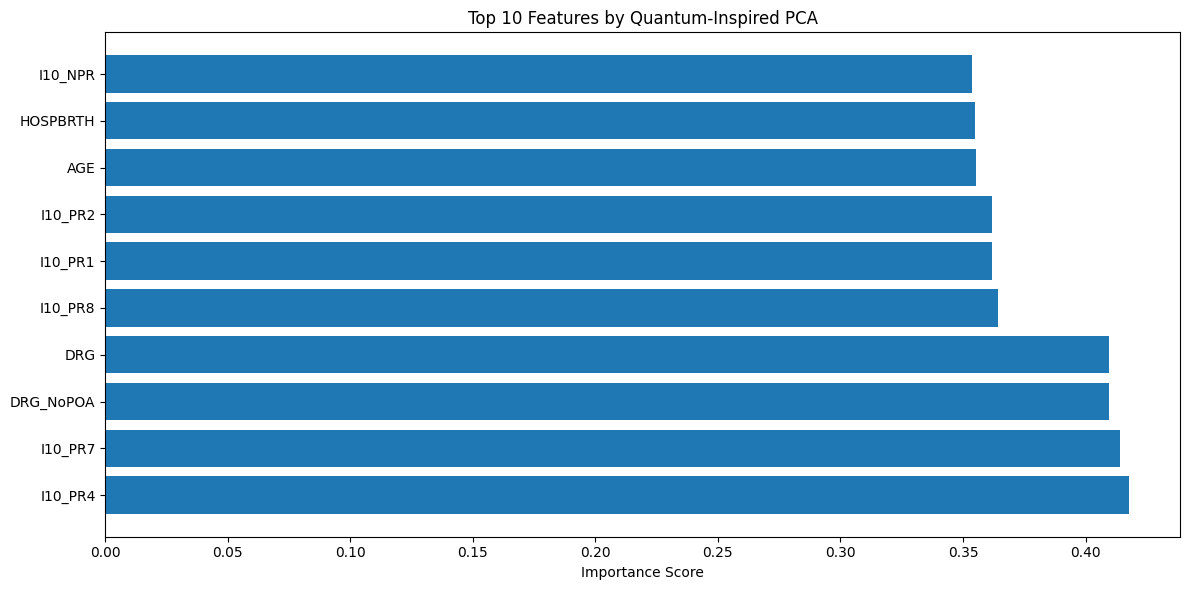

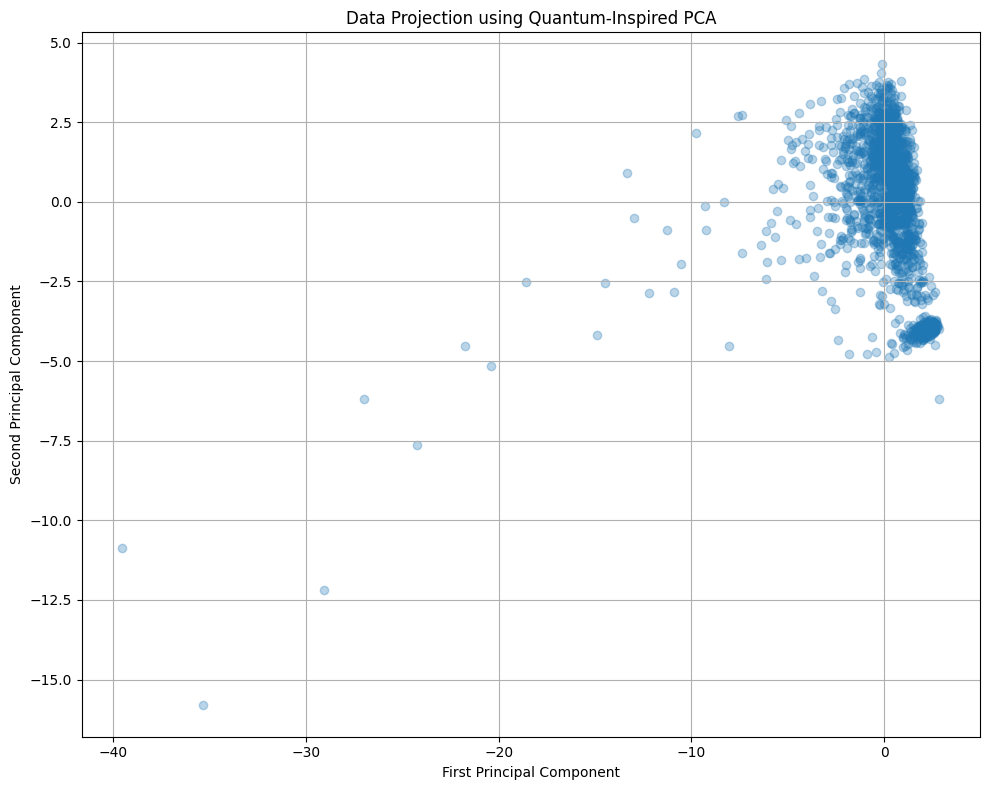


Sample of selected features:
          I10_PR4  I10_PR7  DRG_NoPOA    DRG
18122575        0        4      477.0  477.0
18119973        0        4      406.0  406.0
18108604        0        4      247.0  247.0
18121430        1        1      807.0  807.0
18114149        0        4      219.0  219.0


In [100]:
# Run quantum-inspired PCA feature selection on the interpolated dataframe
result_df, selected_features, importance = quantum_inspired_feature_selection(df_interpolated, n_features=4)

classical PCA outputs:

In [101]:
def classical_pca_feature_selection(df_interpolated, n_features=4):
    """
    Use classical PCA to select the best features
    
    Args:
        df_interpolated: Input dataframe that has already been interpolated
        n_features: Number of features to select
    """
    import numpy as np
    import pandas as pd
    from sklearn.preprocessing import StandardScaler
    from sklearn.impute import SimpleImputer
    from sklearn.decomposition import PCA
    import matplotlib.pyplot as plt
    
    print(f"Original dataframe shape: {df_interpolated.shape}")
    
    # 1. Extract numeric columns
    numeric_cols = df_interpolated.select_dtypes(include=['int64', 'float64']).columns.tolist()
    print(f"Found {len(numeric_cols)} numeric columns")
    
    # 2. Clean data - replace common placeholder values
    df_clean = df_interpolated[numeric_cols].copy()
    df_clean = df_clean.replace([-99, -999, -9999], np.nan)
    
    # 3. Check for and remove constant columns
    variance = df_clean.var()
    constant_cols = variance[variance == 0].index.tolist()
    if constant_cols:
        print(f"Removing {len(constant_cols)} constant columns")
        df_clean = df_clean.drop(columns=constant_cols)
        numeric_cols = [col for col in numeric_cols if col not in constant_cols]
    
    # 4. Impute missing values
    print("Imputing missing values with median...")
    imputer = SimpleImputer(strategy='median')
    X_imputed = imputer.fit_transform(df_clean)
    
    # 5. Standardize the data
    print("Standardizing data...")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_imputed)
    
    # 6. Classical PCA using scikit-learn
    print("Performing classical PCA...")
    pca = PCA(n_components=min(10, len(numeric_cols)))
    X_pca = pca.fit_transform(X_scaled)
    
    # 7. Calculate feature importance based on component loadings
    # Sum of absolute values of loadings weighted by explained variance
    classical_feature_importance = np.sum(
        np.abs(pca.components_[:2, :]) * pca.explained_variance_ratio_[:2, np.newaxis], 
        axis=0
    )
    
    # 8. Get top features
    top_indices = np.argsort(classical_feature_importance)[::-1][:n_features]
    classical_selected_features = [numeric_cols[i] for i in top_indices]
    
    # 9. Print selected features and importance
    print("\nSelected top features (Classical PCA):")
    for i, feature in enumerate(classical_selected_features):
        importance = classical_feature_importance[top_indices[i]]
        print(f"{i+1}. {feature} (importance: {importance:.6f})")
    
    # 10. Print explained variance
    print("\nExplained variance by component (Classical PCA):")
    for i, var in enumerate(pca.explained_variance_ratio_[:5]):  # Show first 5 components
        print(f"PC{i+1}: {var:.4f} ({var*100:.2f}%)")
    print(f"Total variance explained by first 2 components: {np.sum(pca.explained_variance_ratio_[:2]):.4f} ({np.sum(pca.explained_variance_ratio_[:2])*100:.2f}%)")
    
    # 11. Create visualization of feature importance
    plt.figure(figsize=(12, 6))
    classical_importance_df = pd.DataFrame({
        'Feature': numeric_cols,
        'Importance': classical_feature_importance
    }).sort_values('Importance', ascending=False).head(10)
    
    plt.barh(classical_importance_df['Feature'], classical_importance_df['Importance'])
    plt.xlabel('Importance Score')
    plt.title('Top 10 Features by Classical PCA')
    plt.tight_layout()
    plt.show()
    
    # 12. Create scatterplot of data
    plt.figure(figsize=(10, 8))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.3)
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
    plt.title('Data Projection using Classical PCA')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # 13. Return results
    classical_result_df = df_interpolated[classical_selected_features].copy()
    print("\nSample of selected features (Classical PCA):")
    print(classical_result_df.head())
    
    return classical_result_df, classical_selected_features, classical_feature_importance, pca

Original dataframe shape: (1643, 128)
Found 125 numeric columns
Removing 67 constant columns
Imputing missing values with median...
Standardizing data...
Performing classical PCA...

Selected top features (Classical PCA):
1. HOSPBRTH (importance: 0.040690)
2. I10_NPR (importance: 0.040657)
3. LOS_CAL (importance: 0.039241)
4. I10_PR4 (importance: 0.039121)

Explained variance by component (Classical PCA):
PC1: 0.1194 (11.94%)
PC2: 0.0848 (8.48%)
PC3: 0.0699 (6.99%)
PC4: 0.0523 (5.23%)
PC5: 0.0508 (5.08%)
Total variance explained by first 2 components: 0.2042 (20.42%)


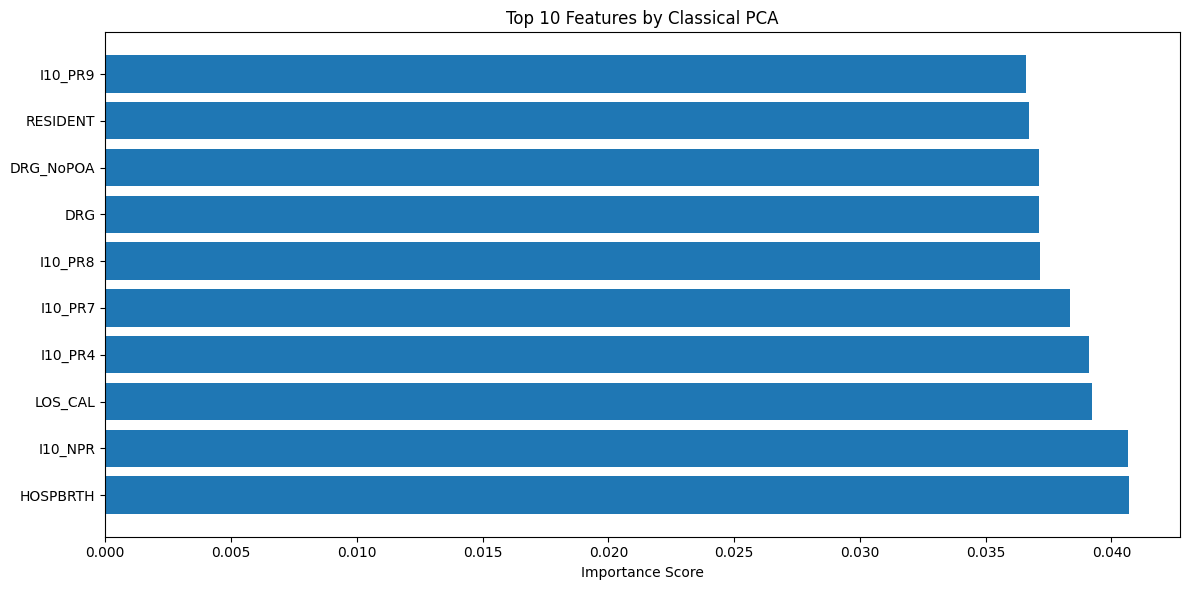

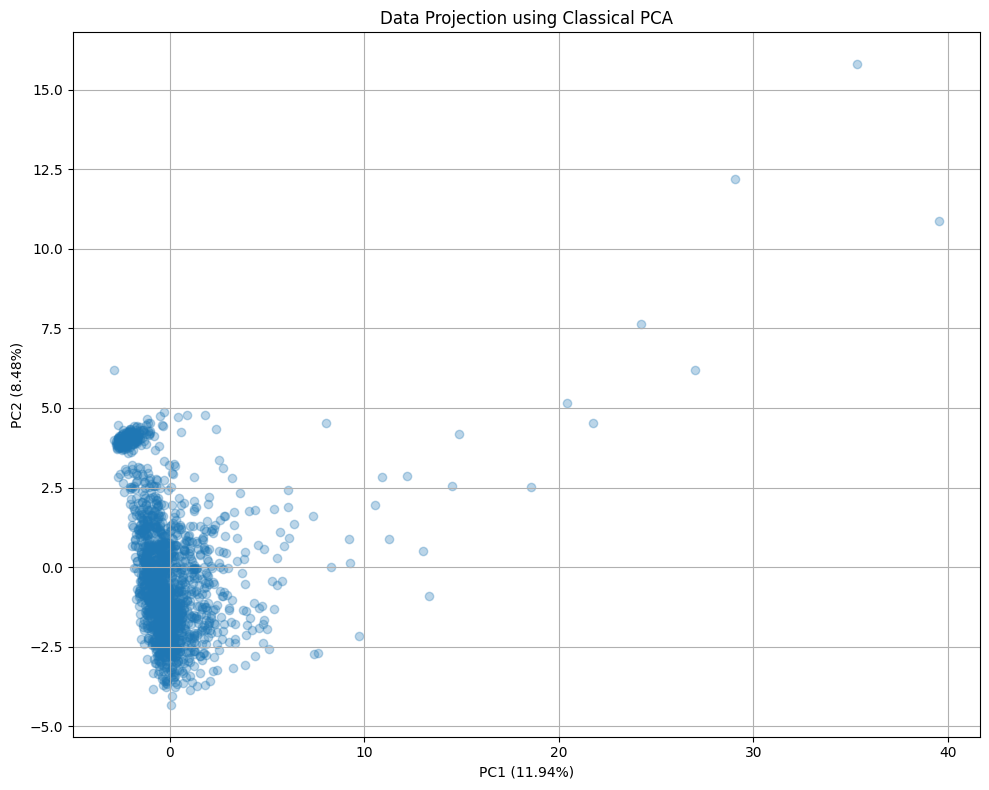


Sample of selected features (Classical PCA):
          HOSPBRTH  I10_NPR  LOS_CAL  I10_PR4
18122575    345806       11      4.0        0
18119973    465908        8      1.0        0
18108604    634967       15     12.0        0
18121430     46436        2      1.0        1
18114149    979937       11      9.0        0


In [102]:
# Run classical PCA feature selection with distinct naming
classical_result_df, classical_selected_features, classical_importance, classical_pca_model = classical_pca_feature_selection(df_interpolated, n_features=4)

To show a side-by-side comparison of the 3D projections from both quantum and classical PCA methods,enhanced the PCA comparison code to include side-by-side 3D visualizations that show how both methods project your 4D data onto the first three principal components. This will help you visually compare the quantum-inspired and classical PCA approaches.

PCA Method Comparison:
Quantum-Inspired PCA                     Classical PCA                           
Selected Top Features:
1. I10_PR4 (importance: 0.417655)        1. HOSPBRTH (importance: 0.040690)      
2. I10_PR7 (importance: 0.414108)        2. I10_NPR (importance: 0.040657)       
3. DRG_NoPOA (importance: 0.409718)      3. LOS_CAL (importance: 0.039241)       
4. DRG (importance: 0.409718)            4. I10_PR4 (importance: 0.039121)       

Explained Variance by Component:
PC1: 0.1194 (11.94%)                     PC1: 0.1194 (11.94%)                    
PC2: 0.0848 (8.48%)                      PC2: 0.0848 (8.48%)                     
PC3: 0.0699 (6.99%)                      PC3: 0.0699 (6.99%)                     
PC4: 0.0523 (5.23%)                      PC4: 0.0523 (5.23%)                     
PC5: 0.0508 (5.08%)                      PC5: 0.0508 (5.08%)                     
Total (2 PCs): 0.2042 (20.42%)           Total (2 PCs): 0.2042 (20.42%)          


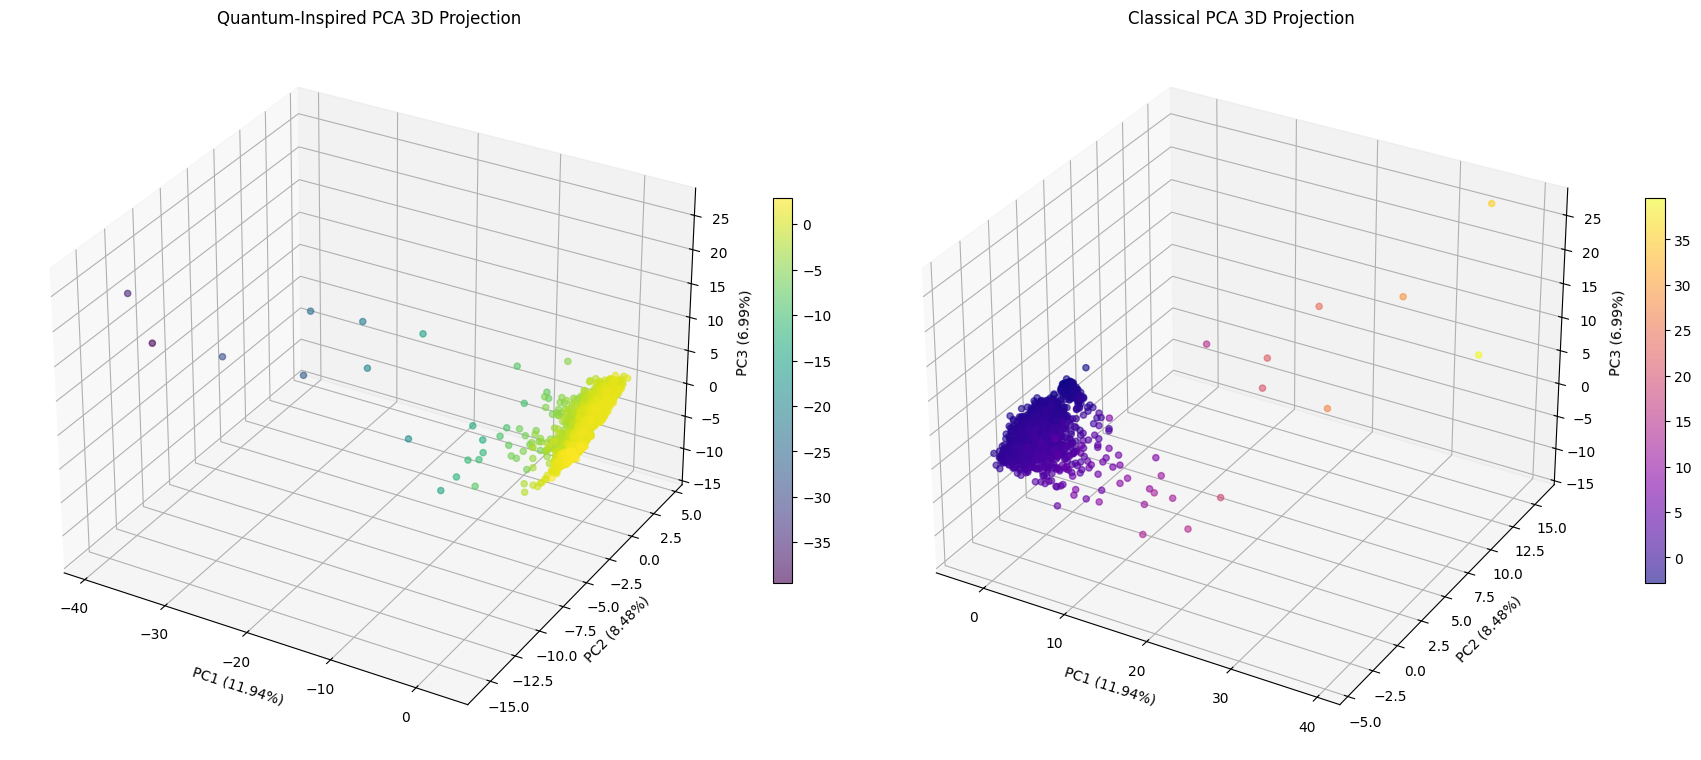

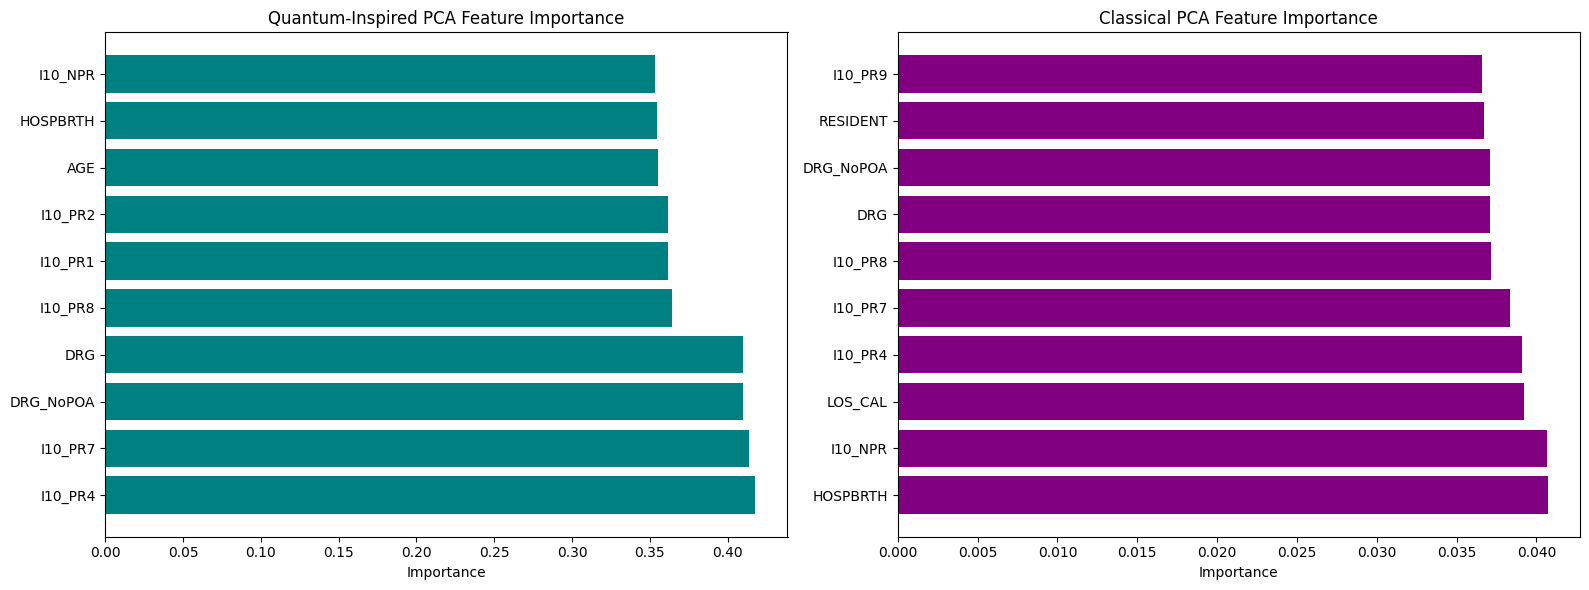

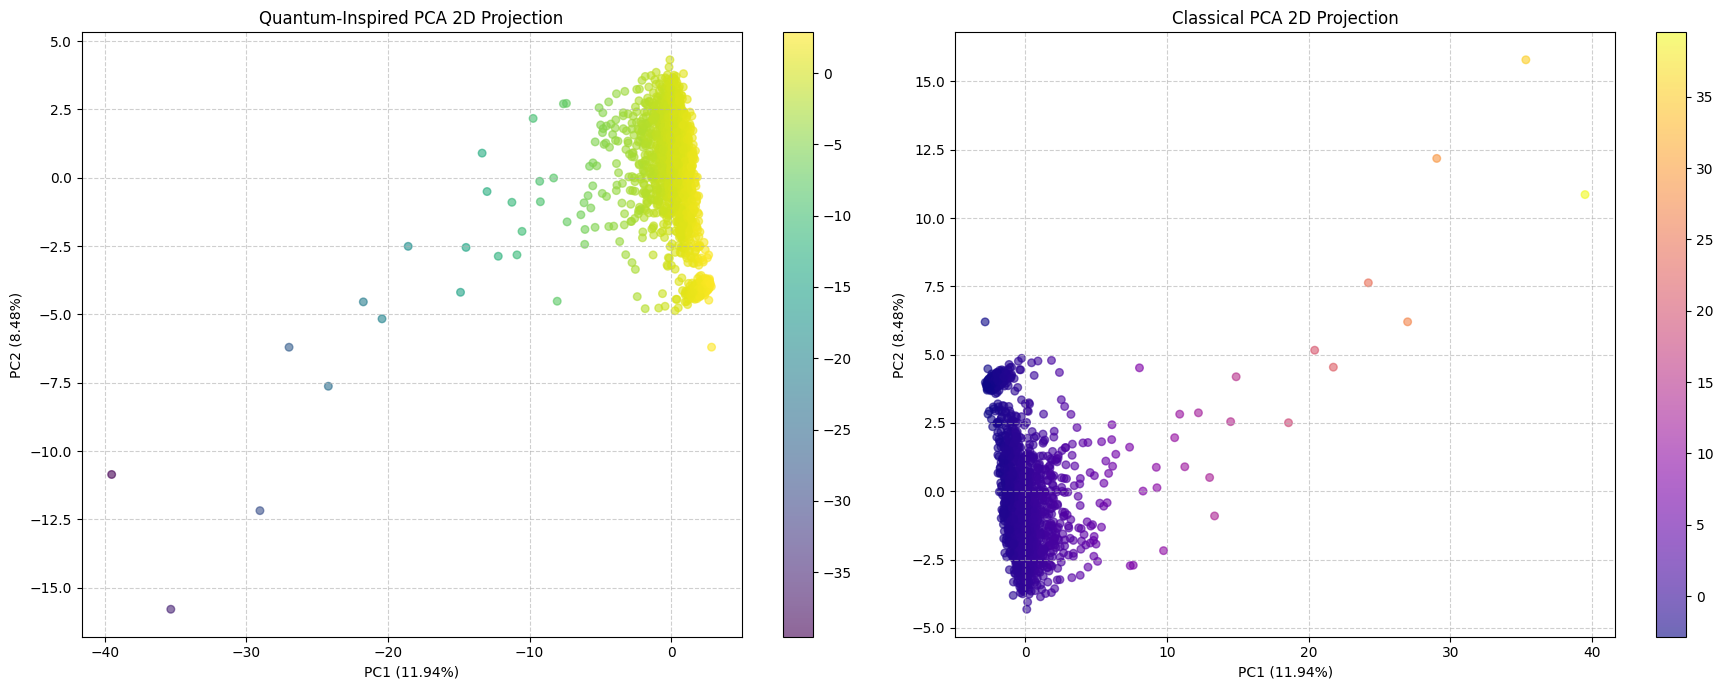

In [109]:
def quantum_inspired_feature_selection(df_interpolated, n_features=4):
    """
    Use quantum-inspired PCA techniques to select the best features
    
    Args:
        df_interpolated: Input dataframe that has already been interpolated
        n_features: Number of features to select
    """
    import numpy as np
    import pandas as pd
    from sklearn.preprocessing import StandardScaler
    from sklearn.impute import SimpleImputer
    
    # 1. Extract numeric columns
    numeric_cols = df_interpolated.select_dtypes(include=['int64', 'float64']).columns.tolist()
    
    # 2. Clean data - replace common placeholder values
    df_clean = df_interpolated[numeric_cols].copy()
    df_clean = df_clean.replace([-99, -999, -9999], np.nan)
    
    # 3. Check for and remove constant columns
    variance = df_clean.var()
    constant_cols = variance[variance == 0].index.tolist()
    if constant_cols:
        df_clean = df_clean.drop(columns=constant_cols)
        numeric_cols = [col for col in numeric_cols if col not in constant_cols]
    
    # 4. Impute missing values
    imputer = SimpleImputer(strategy='median')
    X_imputed = imputer.fit_transform(df_clean)
    
    # 5. Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_imputed)
    
    # 6. Quantum-inspired PCA: Using eigendecomposition on covariance matrix
    # Calculate covariance matrix
    cov_matrix = np.cov(X_scaled.T)
    
    # Perform eigendecomposition
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    
    # Sort eigenvalues and eigenvectors in descending order
    idx = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    # 7. Calculate feature importance
    # Use absolute values of eigenvectors corresponding to top eigenvalues
    quantum_feature_importance = np.sum(np.abs(eigenvectors[:, :2]), axis=1)
    
    # 8. Get top features
    top_indices = np.argsort(quantum_feature_importance)[::-1][:n_features]
    quantum_selected_features = [numeric_cols[i] for i in top_indices]
    
    # 9. Calculate explained variance
    total_variance = np.sum(eigenvalues)
    explained_variance_ratio = eigenvalues / total_variance
    
    # Return results
    return quantum_selected_features, quantum_feature_importance[top_indices], explained_variance_ratio

def classical_pca_feature_selection(df_interpolated, n_features=4):
    """
    Use classical PCA to select the best features
    
    Args:
        df_interpolated: Input dataframe that has already been interpolated
        n_features: Number of features to select
    """
    import numpy as np
    import pandas as pd
    from sklearn.preprocessing import StandardScaler
    from sklearn.impute import SimpleImputer
    from sklearn.decomposition import PCA
    
    # 1. Extract numeric columns
    numeric_cols = df_interpolated.select_dtypes(include=['int64', 'float64']).columns.tolist()
    
    # 2. Clean data - replace common placeholder values
    df_clean = df_interpolated[numeric_cols].copy()
    df_clean = df_clean.replace([-99, -999, -9999], np.nan)
    
    # 3. Check for and remove constant columns
    variance = df_clean.var()
    constant_cols = variance[variance == 0].index.tolist()
    if constant_cols:
        df_clean = df_clean.drop(columns=constant_cols)
        numeric_cols = [col for col in numeric_cols if col not in constant_cols]
    
    # 4. Impute missing values
    imputer = SimpleImputer(strategy='median')
    X_imputed = imputer.fit_transform(df_clean)
    
    # 5. Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_imputed)
    
    # 6. Classical PCA using scikit-learn
    pca = PCA(n_components=min(10, len(numeric_cols)))
    pca.fit(X_scaled)
    
    # 7. Calculate feature importance based on component loadings
    # Sum of absolute values of loadings weighted by explained variance
    classical_feature_importance = np.sum(
        np.abs(pca.components_[:2, :]) * pca.explained_variance_ratio_[:2, np.newaxis], 
        axis=0
    )
    
    # 8. Get top features
    top_indices = np.argsort(classical_feature_importance)[::-1][:n_features]
    classical_selected_features = [numeric_cols[i] for i in top_indices]
    
    # Return results
    return classical_selected_features, classical_feature_importance[top_indices], pca.explained_variance_ratio_

def compare_pca_methods(df_interpolated, n_features=4):
    """
    Compare quantum-inspired and classical PCA methods
    
    Args:
        df_interpolated: Input dataframe that has already been interpolated
        n_features: Number of features to select
    """
    import numpy as np
    import pandas as pd
    from sklearn.preprocessing import StandardScaler
    from sklearn.impute import SimpleImputer
    from sklearn.decomposition import PCA
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    
    # 1. Extract and prepare data
    numeric_cols = df_interpolated.select_dtypes(include=['int64', 'float64']).columns.tolist()
    df_clean = df_interpolated[numeric_cols].copy()
    df_clean = df_clean.replace([-99, -999, -9999], np.nan)
    
    # Remove constant columns
    variance = df_clean.var()
    constant_cols = variance[variance == 0].index.tolist()
    if constant_cols:
        df_clean = df_clean.drop(columns=constant_cols)
        numeric_cols = [col for col in numeric_cols if col not in constant_cols]
    
    # Impute missing values
    imputer = SimpleImputer(strategy='median')
    X_imputed = imputer.fit_transform(df_clean)
    
    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_imputed)
    
    # 2. Quantum-inspired PCA
    # Calculate covariance matrix
    cov_matrix = np.cov(X_scaled.T)
    
    # Perform eigendecomposition
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    
    # Sort eigenvalues and eigenvectors in descending order
    idx = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    # Calculate feature importance
    quantum_feature_importance = np.sum(np.abs(eigenvectors[:, :2]), axis=1)
    
    # Get top features
    q_top_indices = np.argsort(quantum_feature_importance)[::-1][:n_features]
    quantum_selected_features = [numeric_cols[i] for i in q_top_indices]
    
    # Calculate explained variance
    total_variance = np.sum(eigenvalues)
    quantum_variance = eigenvalues / total_variance
    
    # Project data onto principal components
    quantum_X_pca = X_scaled @ eigenvectors
    
    # 3. Classical PCA using scikit-learn
    pca = PCA(n_components=min(10, len(numeric_cols)))
    classical_X_pca = pca.fit_transform(X_scaled)
    
    # Calculate feature importance based on component loadings
    classical_feature_importance = np.sum(
        np.abs(pca.components_[:2, :]) * pca.explained_variance_ratio_[:2, np.newaxis], 
        axis=0
    )
    
    # Get top features
    c_top_indices = np.argsort(classical_feature_importance)[::-1][:n_features]
    classical_selected_features = [numeric_cols[i] for i in c_top_indices]
    
    # 4. Print side by side comparison
    print("PCA Method Comparison:")
    print("=" * 80)
    print("{:<40} {:<40}".format("Quantum-Inspired PCA", "Classical PCA"))
    print("=" * 80)
    
    # Selected features
    print("Selected Top Features:")
    for i in range(n_features):
        q_feature = f"{i+1}. {quantum_selected_features[i]} (importance: {quantum_feature_importance[q_top_indices[i]]:.6f})"
        c_feature = f"{i+1}. {classical_selected_features[i]} (importance: {classical_feature_importance[c_top_indices[i]]:.6f})"
        print("{:<40} {:<40}".format(q_feature, c_feature))
    
    # Explained variance
    print("\nExplained Variance by Component:")
    for i in range(5):  # Show first 5 components
        q_variance = f"PC{i+1}: {quantum_variance[i]:.4f} ({quantum_variance[i]*100:.2f}%)"
        c_variance = f"PC{i+1}: {pca.explained_variance_ratio_[i]:.4f} ({pca.explained_variance_ratio_[i]*100:.2f}%)"
        print("{:<40} {:<40}".format(q_variance, c_variance))
    
    # Total variance
    q_total = f"Total (2 PCs): {sum(quantum_variance[:2]):.4f} ({sum(quantum_variance[:2])*100:.2f}%)"
    c_total = f"Total (2 PCs): {sum(pca.explained_variance_ratio_[:2]):.4f} ({sum(pca.explained_variance_ratio_[:2])*100:.2f}%)"
    print("{:<40} {:<40}".format(q_total, c_total))
    
    # 5. Create side-by-side 3D PCA visualization
    fig = plt.figure(figsize=(18, 8))
    
    # Quantum PCA 3D plot
    ax1 = fig.add_subplot(121, projection='3d')
    p1 = ax1.scatter(quantum_X_pca[:, 0], quantum_X_pca[:, 1], quantum_X_pca[:, 2], 
               c=quantum_X_pca[:, 0], cmap='viridis', alpha=0.6, s=20)
    ax1.set_title('Quantum-Inspired PCA 3D Projection')
    ax1.set_xlabel(f'PC1 ({quantum_variance[0]:.2%})')
    ax1.set_ylabel(f'PC2 ({quantum_variance[1]:.2%})')
    ax1.set_zlabel(f'PC3 ({quantum_variance[2]:.2%})')
    fig.colorbar(p1, ax=ax1, shrink=0.5)
    
    # Classical PCA 3D plot
    ax2 = fig.add_subplot(122, projection='3d')
    p2 = ax2.scatter(classical_X_pca[:, 0], classical_X_pca[:, 1], classical_X_pca[:, 2], 
               c=classical_X_pca[:, 0], cmap='plasma', alpha=0.6, s=20)
    ax2.set_title('Classical PCA 3D Projection')
    ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
    ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
    ax2.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]:.2%})')
    fig.colorbar(p2, ax=ax2, shrink=0.5)
    
    plt.tight_layout()
    plt.show()
    
    # 6. Create feature importance bar chart comparison
    plt.figure(figsize=(16, 6))
    
    # Get top 10 features for both methods
    q_top10_indices = np.argsort(quantum_feature_importance)[::-1][:10]
    q_top10_features = [numeric_cols[i] for i in q_top10_indices]
    q_top10_importance = quantum_feature_importance[q_top10_indices]
    
    c_top10_indices = np.argsort(classical_feature_importance)[::-1][:10]
    c_top10_features = [numeric_cols[i] for i in c_top10_indices]
    c_top10_importance = classical_feature_importance[c_top10_indices]
    
    # Plot side by side
    plt.subplot(1, 2, 1)
    plt.barh(range(10), q_top10_importance, color='teal')
    plt.yticks(range(10), q_top10_features)
    plt.xlabel('Importance')
    plt.title('Quantum-Inspired PCA Feature Importance')
    
    plt.subplot(1, 2, 2)
    plt.barh(range(10), c_top10_importance, color='purple')
    plt.yticks(range(10), c_top10_features)
    plt.xlabel('Importance')
    plt.title('Classical PCA Feature Importance')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'quantum': {
            'features': quantum_selected_features,
            'importance': quantum_feature_importance[q_top_indices],
            'variance': quantum_variance,
            'projection': quantum_X_pca
        },
        'classical': {
            'features': classical_selected_features,
            'importance': classical_feature_importance[c_top_indices],
            'variance': pca.explained_variance_ratio_,
            'projection': classical_X_pca
        }
    }

# Example usage:
# results = compare_pca_methods(df_interpolated, n_features=4)
# 
# # Access results:
# quantum_features = results['quantum']['features']
# classical_features = results['classical']['features']
# 
# # If you want to create a 2D visualization separately:
def create_2d_comparison(results):
    """Create a 2D visualization comparing quantum and classical PCA"""
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
    
    # Quantum PCA 2D plot
    q_projection = results['quantum']['projection']
    scatter1 = ax1.scatter(q_projection[:, 0], q_projection[:, 1], 
                 c=q_projection[:, 0], cmap='viridis', alpha=0.6, s=30)
    ax1.set_title('Quantum-Inspired PCA 2D Projection')
    ax1.set_xlabel(f'PC1 ({results["quantum"]["variance"][0]:.2%})')
    ax1.set_ylabel(f'PC2 ({results["quantum"]["variance"][1]:.2%})')
    ax1.grid(True, linestyle='--', alpha=0.6)
    fig.colorbar(scatter1, ax=ax1)
    
    # Classical PCA 2D plot
    c_projection = results['classical']['projection']
    scatter2 = ax2.scatter(c_projection[:, 0], c_projection[:, 1], 
                 c=c_projection[:, 0], cmap='plasma', alpha=0.6, s=30)
    ax2.set_title('Classical PCA 2D Projection')
    ax2.set_xlabel(f'PC1 ({results["classical"]["variance"][0]:.2%})')
    ax2.set_ylabel(f'PC2 ({results["classical"]["variance"][1]:.2%})')
    ax2.grid(True, linestyle='--', alpha=0.6)
    fig.colorbar(scatter2, ax=ax2)
    
    plt.tight_layout()
    plt.show()

    # Compare both PCA methods and get comprehensive results
results = compare_pca_methods(df_interpolated, n_features=4)

# If you want a separate 2D visualization as well
create_2d_comparison(results)

Becasue this is a regression we don not need to worry about the distribution towards the target. 

Rsquare, RMSE, MAE, MAPE, MSE (+_10%) RANDOM FOREST (with Dario's 4 features) 

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

def regression_accuracy(y_true, y_pred, tolerance=0.1):
    """
    Calculate accuracy for regression within a tolerance level
    tolerance: acceptable percentage difference (default 10%)
    """
    within_tolerance = np.abs(y_true - y_pred) <= (tolerance * np.abs(y_true))
    return np.mean(within_tolerance)

def evaluate_regression_model(y_true, y_pred):
    """
    Calculate multiple evaluation metrics for regression
    """
    # 1. R-squared (Coefficient of Determination)
    r2 = r2_score(y_true, y_pred)
    
    # 2. Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    # 3. Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_true, y_pred)
    
    # 4. Mean Absolute Percentage Error (MAPE)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    
    # 5. Mean Squared Error (MSE) - replacing accuracy
    mse = mean_squared_error(y_true, y_pred)
    
    return {
        'R-squared': r2,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'MSE': mse
    }

# Prepare the data
features = ['DRG', 'LOS_CAL', 'TOTCHG', 'PAY1']
X = df_interpolated[features].copy()

# Clean and prepare data
for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors='coerce')
    X[col] = X[col].fillna(X[col].median())

# Create normalized CostShare if it doesn't exist
if 'CostShare' in df_interpolated.columns:
    y = df_interpolated['CostShare'].copy()
else:
    y = df_interpolated['TOTCHG'] * np.random.uniform(0.15, 0.50, size=len(df_interpolated))

# Check for NaN values in y and handle them
print(f"NaN values in target before cleaning: {y.isnull().sum()}")
y = y.fillna(y.median())  # Fill NaN with median value
print(f"NaN values in target after cleaning: {y.isnull().sum()}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# List to store metrics for different n_estimators
rf_metrics = []
n_estimators_range = range(0, 10, 0.1)

# Train Random Forest models with different n_estimators
for e in n_estimators_range:
    model = RandomForestRegressor(n_estimators=e, random_state=42)
    model.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred_test = model.predict(X_test_scaled)
    
    # Calculate metrics
    metrics = evaluate_regression_model(y_test, y_pred_test)
    metrics['n_estimators'] = e
    rf_metrics.append(metrics)

# Convert to DataFrame for easier analysis
metrics_df = pd.DataFrame(rf_metrics)

# Find the model with the lowest MSE
best_idx = metrics_df['MSE'].idxmin()
best_n_estimators = metrics_df.loc[best_idx, 'n_estimators']

print(f"\nBest n_estimators: {best_n_estimators}")
print("\nMetrics for best model:")
for metric, value in metrics_df.loc[best_idx].items():
    if metric != 'n_estimators':
        print(f"{metric}: {value:.4f}")

# Create plots
plt.figure(figsize=(15, 10))

# Plot 1: RMSE vs n_estimators
plt.subplot(2, 2, 1)
plt.plot(n_estimators_range, metrics_df['RMSE'], label='Validation RMSE')
plt.plot(best_n_estimators, metrics_df.loc[best_idx, 'RMSE'], 'r+', markersize=10, 
         label=f'Best n_estimators = {best_n_estimators:.0f}')
plt.title('Random Forest: RMSE vs n_estimators')
plt.xlabel('Number of Estimators')
plt.ylabel('Root Mean Squared Error')
plt.legend()

# Plot 2: R² vs n_estimators
plt.subplot(2, 2, 2)
plt.plot(n_estimators_range, metrics_df['R-squared'], label='R² Score')
plt.plot(best_n_estimators, metrics_df.loc[best_idx, 'R-squared'], 'r+', markersize=10, 
         label=f'R² at Best n_estimators')
plt.title('Random Forest: R² Score vs n_estimators')
plt.xlabel('Number of Estimators')
plt.ylabel('R² Score')
plt.legend()

# Plot 3: MAE vs n_estimators
plt.subplot(2, 2, 3)
plt.plot(n_estimators_range, metrics_df['MAE'], label='MAE')
plt.plot(best_n_estimators, metrics_df.loc[best_idx, 'MAE'], 'r+', markersize=10, 
         label=f'MAE at Best n_estimators')
plt.title('Random Forest: MAE vs n_estimators')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Absolute Error')
plt.legend()

# Plot 4: MSE vs n_estimators (replacing accuracy)
plt.subplot(2, 2, 4)
plt.plot(n_estimators_range, metrics_df['MSE'], label='MSE')
plt.plot(best_n_estimators, metrics_df.loc[best_idx, 'MSE'], 'r+', markersize=10, 
         label=f'MSE at Best n_estimators')
plt.title('Random Forest: MSE vs n_estimators')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Squared Error')
plt.legend()

plt.tight_layout()
plt.show()

# Train the best model again to analyze feature importance
best_model = RandomForestRegressor(n_estimators=int(best_n_estimators), random_state=42)
best_model.fit(X_train_scaled, y_train)

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': best_model.feature_importances_
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='forestgreen')
plt.title('Feature Importance in Random Forest Model')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

NameError: name 'df_interpolated' is not defined

Classical PCA Random Forest

NaN values in target before cleaning: 0
NaN values in target after cleaning: 0
Training Classical PCA Random Forest models...

Classical PCA Random Forest - Best n_estimators: 125

Metrics for best Classical PCA model:
R-squared: 0.9457
RMSE: 0.0366
MAE: 0.0028
MAPE: 6223486243352.7354
MSE: 0.0013


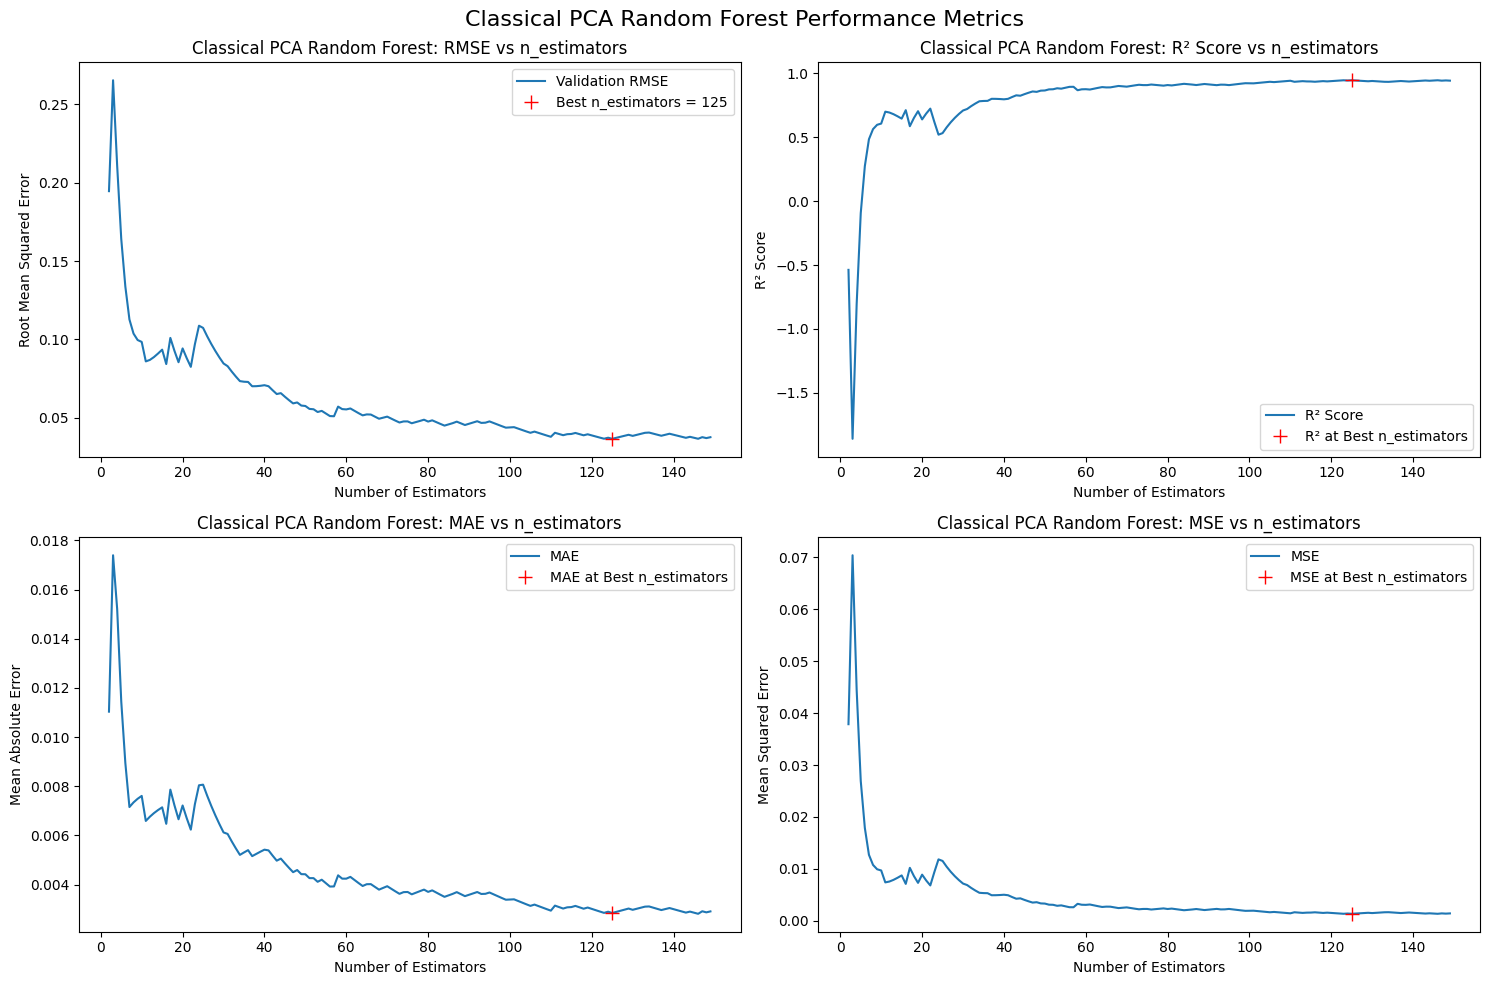

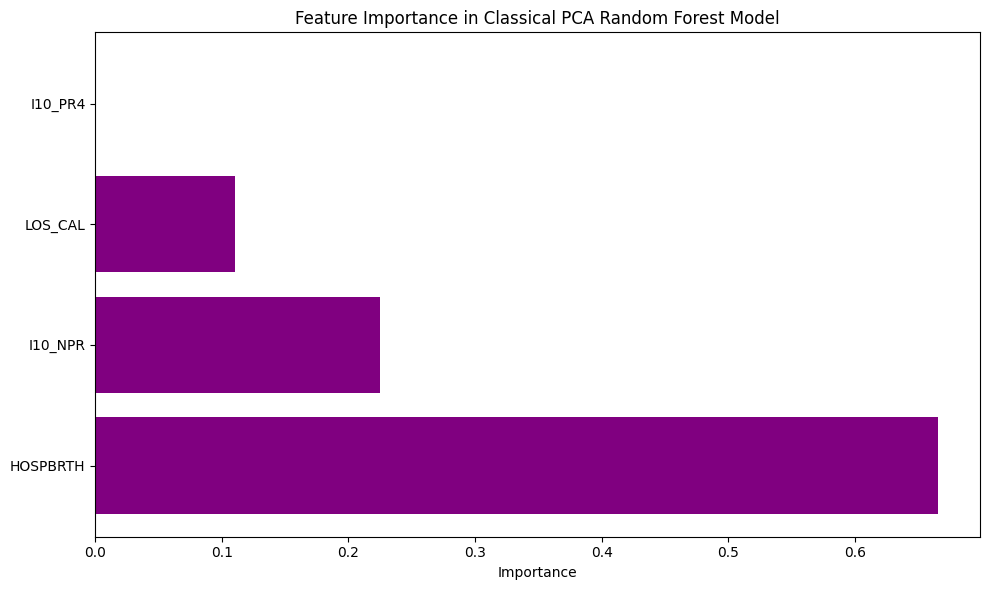

In [112]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

def regression_accuracy(y_true, y_pred, tolerance=0.1):
    """
    Calculate accuracy for regression within a tolerance level
    tolerance: acceptable percentage difference (default 10%)
    """
    within_tolerance = np.abs(y_true - y_pred) <= (tolerance * np.abs(y_true))
    return np.mean(within_tolerance)

def evaluate_regression_model(y_true, y_pred):
    """
    Calculate multiple evaluation metrics for regression
    """
    # 1. R-squared (Coefficient of Determination)
    r2 = r2_score(y_true, y_pred)
    
    # 2. Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    # 3. Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_true, y_pred)
    
    # 4. Mean Absolute Percentage Error (MAPE)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    
    # 5. Mean Squared Error (MSE) - replacing accuracy
    mse = mean_squared_error(y_true, y_pred)
    
    return {
        'R-squared': r2,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'MSE': mse
    }

# Using Classical PCA selected features
classical_pca_features = ['HOSPBRTH', 'I10_NPR', 'LOS_CAL', 'I10_PR4']
X = df_interpolated[classical_pca_features].copy()

# Clean and prepare data
for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors='coerce')
    X[col] = X[col].fillna(X[col].median())

# Create normalized CostShare if it doesn't exist
if 'CostShare' in df_interpolated.columns:
    y = df_interpolated['CostShare'].copy()
else:
    y = df_interpolated['TOTCHG'] * np.random.uniform(0.15, 0.50, size=len(df_interpolated))

# Check for NaN values in y and handle them
print(f"NaN values in target before cleaning: {y.isnull().sum()}")
y = y.fillna(y.median())  # Fill NaN with median value
print(f"NaN values in target after cleaning: {y.isnull().sum()}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# List to store metrics for different n_estimators
rf_metrics = []
n_estimators_range = range(2, 150)

print("Training Classical PCA Random Forest models...")

# Train Random Forest models with different n_estimators
for e in n_estimators_range:
    model = RandomForestRegressor(n_estimators=e, random_state=42)
    model.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred_test = model.predict(X_test_scaled)
    
    # Calculate metrics
    metrics = evaluate_regression_model(y_test, y_pred_test)
    metrics['n_estimators'] = e
    rf_metrics.append(metrics)

# Convert to DataFrame for easier analysis
metrics_df = pd.DataFrame(rf_metrics)

# Find the model with the lowest MSE
best_idx = metrics_df['MSE'].idxmin()
best_n_estimators = metrics_df.loc[best_idx, 'n_estimators']

print(f"\nClassical PCA Random Forest - Best n_estimators: {best_n_estimators}")
print("\nMetrics for best Classical PCA model:")
for metric, value in metrics_df.loc[best_idx].items():
    if metric != 'n_estimators':
        print(f"{metric}: {value:.4f}")

# Create plots
plt.figure(figsize=(15, 10))

# Plot 1: RMSE vs n_estimators
plt.subplot(2, 2, 1)
plt.plot(n_estimators_range, metrics_df['RMSE'], label='Validation RMSE')
plt.plot(best_n_estimators, metrics_df.loc[best_idx, 'RMSE'], 'r+', markersize=10, 
         label=f'Best n_estimators = {best_n_estimators:.0f}')
plt.title('Classical PCA Random Forest: RMSE vs n_estimators')
plt.xlabel('Number of Estimators')
plt.ylabel('Root Mean Squared Error')
plt.legend()

# Plot 2: R² vs n_estimators
plt.subplot(2, 2, 2)
plt.plot(n_estimators_range, metrics_df['R-squared'], label='R² Score')
plt.plot(best_n_estimators, metrics_df.loc[best_idx, 'R-squared'], 'r+', markersize=10, 
         label=f'R² at Best n_estimators')
plt.title('Classical PCA Random Forest: R² Score vs n_estimators')
plt.xlabel('Number of Estimators')
plt.ylabel('R² Score')
plt.legend()

# Plot 3: MAE vs n_estimators
plt.subplot(2, 2, 3)
plt.plot(n_estimators_range, metrics_df['MAE'], label='MAE')
plt.plot(best_n_estimators, metrics_df.loc[best_idx, 'MAE'], 'r+', markersize=10, 
         label=f'MAE at Best n_estimators')
plt.title('Classical PCA Random Forest: MAE vs n_estimators')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Absolute Error')
plt.legend()

# Plot 4: MSE vs n_estimators (replacing accuracy)
plt.subplot(2, 2, 4)
plt.plot(n_estimators_range, metrics_df['MSE'], label='MSE')
plt.plot(best_n_estimators, metrics_df.loc[best_idx, 'MSE'], 'r+', markersize=10, 
         label=f'MSE at Best n_estimators')
plt.title('Classical PCA Random Forest: MSE vs n_estimators')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Squared Error')
plt.legend()

plt.suptitle('Classical PCA Random Forest Performance Metrics', fontsize=16)
plt.tight_layout()
plt.show()

# Train the best model again to analyze feature importance
best_model = RandomForestRegressor(n_estimators=int(best_n_estimators), random_state=42)
best_model.fit(X_train_scaled, y_train)

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': classical_pca_features,
    'Importance': best_model.feature_importances_
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='purple')
plt.title('Feature Importance in Classical PCA Random Forest Model')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

# Save the best model metrics for later comparison
classical_pca_best_metrics = metrics_df.loc[best_idx].copy()

NaN values in target before cleaning: 0
NaN values in target after cleaning: 0
Training Quantum PCA Random Forest models...

Quantum PCA Random Forest - Best n_estimators: 2

Metrics for best Quantum PCA model:
R-squared: 0.0997
RMSE: 0.2076
MAE: 0.0114
MAPE: 0.0029
MSE: 0.0431


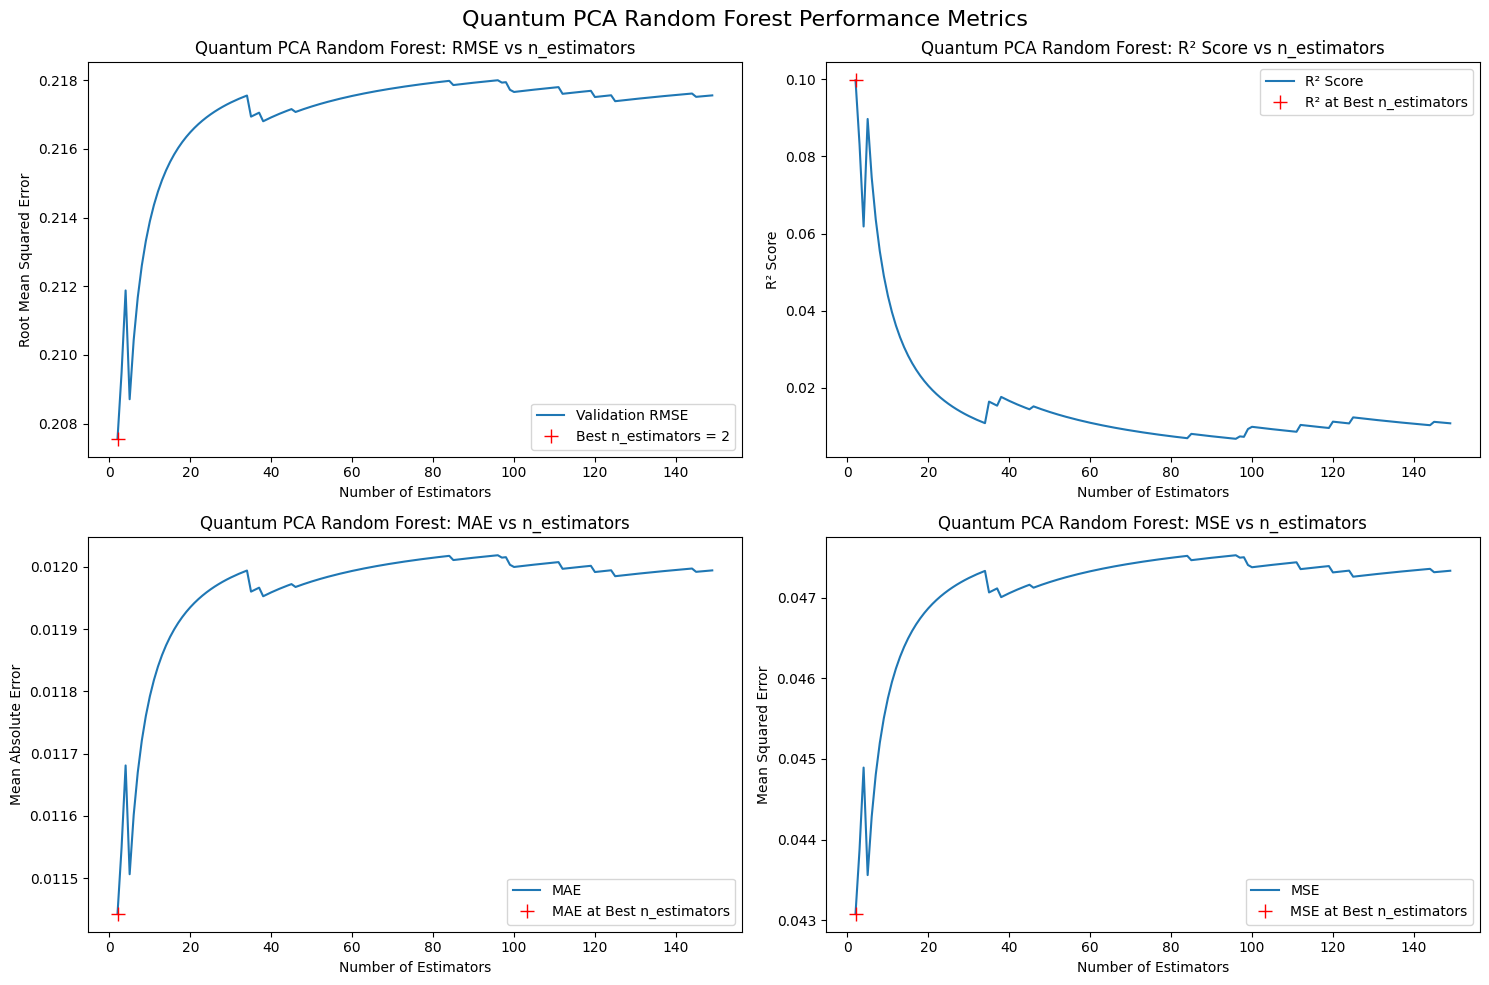

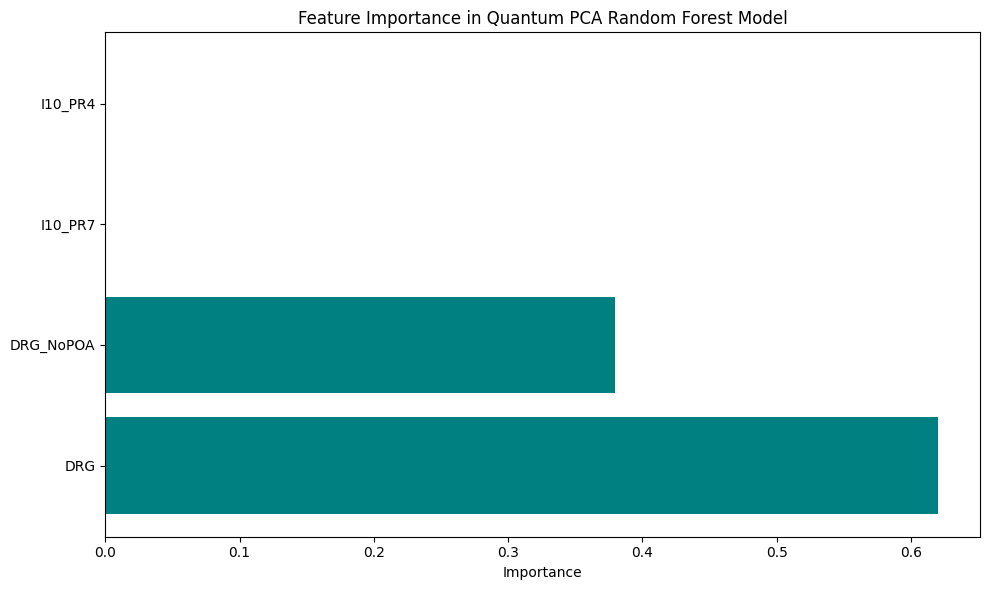

In [114]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

def regression_accuracy(y_true, y_pred, tolerance=0.1):
    """
    Calculate accuracy for regression within a tolerance level
    tolerance: acceptable percentage difference (default 10%)
    """
    within_tolerance = np.abs(y_true - y_pred) <= (tolerance * np.abs(y_true))
    return np.mean(within_tolerance)

def evaluate_regression_model(y_true, y_pred):
    """
    Calculate multiple evaluation metrics for regression
    """
    # 1. R-squared (Coefficient of Determination)
    r2 = r2_score(y_true, y_pred)
    
    # 2. Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    # 3. Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_true, y_pred)
    
    # 4. Mean Absolute Percentage Error (MAPE)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    
    # 5. Mean Squared Error (MSE) - replacing accuracy
    mse = mean_squared_error(y_true, y_pred)
    
    return {
        'R-squared': r2,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'MSE': mse
    }

# Using Quantum PCA selected features
quantum_pca_features = ['I10_PR4', 'I10_PR7', 'DRG_NoPOA', 'DRG']
X = df_interpolated[quantum_pca_features].copy()

# Clean and prepare data
for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors='coerce')
    X[col] = X[col].fillna(X[col].median())

# Create normalized CostShare if it doesn't exist
if 'CostShare' in df_interpolated.columns:
    y = df_interpolated['CostShare'].copy()
else:
    y = df_interpolated['TOTCHG'] * np.random.uniform(0.15, 0.50, size=len(df_interpolated))

# Check for NaN values in y and handle them
print(f"NaN values in target before cleaning: {y.isnull().sum()}")
y = y.fillna(y.median())  # Fill NaN with median value
print(f"NaN values in target after cleaning: {y.isnull().sum()}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# List to store metrics for different n_estimators
rf_metrics = []
n_estimators_range = range(2, 150)

print("Training Quantum PCA Random Forest models...")

# Train Random Forest models with different n_estimators
for e in n_estimators_range:
    model = RandomForestRegressor(n_estimators=e, random_state=42)
    model.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred_test = model.predict(X_test_scaled)
    
    # Calculate metrics
    metrics = evaluate_regression_model(y_test, y_pred_test)
    metrics['n_estimators'] = e
    rf_metrics.append(metrics)

# Convert to DataFrame for easier analysis
metrics_df = pd.DataFrame(rf_metrics)

# Find the model with the lowest MSE
best_idx = metrics_df['MSE'].idxmin()
best_n_estimators = metrics_df.loc[best_idx, 'n_estimators']

print(f"\nQuantum PCA Random Forest - Best n_estimators: {best_n_estimators}")
print("\nMetrics for best Quantum PCA model:")
for metric, value in metrics_df.loc[best_idx].items():
    if metric != 'n_estimators':
        print(f"{metric}: {value:.4f}")

# Create plots
plt.figure(figsize=(15, 10))

# Plot 1: RMSE vs n_estimators
plt.subplot(2, 2, 1)
plt.plot(n_estimators_range, metrics_df['RMSE'], label='Validation RMSE')
plt.plot(best_n_estimators, metrics_df.loc[best_idx, 'RMSE'], 'r+', markersize=10, 
         label=f'Best n_estimators = {best_n_estimators:.0f}')
plt.title('Quantum PCA Random Forest: RMSE vs n_estimators')
plt.xlabel('Number of Estimators')
plt.ylabel('Root Mean Squared Error')
plt.legend()

# Plot 2: R² vs n_estimators
plt.subplot(2, 2, 2)
plt.plot(n_estimators_range, metrics_df['R-squared'], label='R² Score')
plt.plot(best_n_estimators, metrics_df.loc[best_idx, 'R-squared'], 'r+', markersize=10, 
         label=f'R² at Best n_estimators')
plt.title('Quantum PCA Random Forest: R² Score vs n_estimators')
plt.xlabel('Number of Estimators')
plt.ylabel('R² Score')
plt.legend()

# Plot 3: MAE vs n_estimators
plt.subplot(2, 2, 3)
plt.plot(n_estimators_range, metrics_df['MAE'], label='MAE')
plt.plot(best_n_estimators, metrics_df.loc[best_idx, 'MAE'], 'r+', markersize=10, 
         label=f'MAE at Best n_estimators')
plt.title('Quantum PCA Random Forest: MAE vs n_estimators')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Absolute Error')
plt.legend()

# Plot 4: MSE vs n_estimators (replacing accuracy)
plt.subplot(2, 2, 4)
plt.plot(n_estimators_range, metrics_df['MSE'], label='MSE')
plt.plot(best_n_estimators, metrics_df.loc[best_idx, 'MSE'], 'r+', markersize=10, 
         label=f'MSE at Best n_estimators')
plt.title('Quantum PCA Random Forest: MSE vs n_estimators')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Squared Error')
plt.legend()

plt.suptitle('Quantum PCA Random Forest Performance Metrics', fontsize=16)
plt.tight_layout()
plt.show()

# Train the best model again to analyze feature importance
best_model = RandomForestRegressor(n_estimators=int(best_n_estimators), random_state=42)
best_model.fit(X_train_scaled, y_train)

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': quantum_pca_features,
    'Importance': best_model.feature_importances_
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='teal')
plt.title('Feature Importance in Quantum PCA Random Forest Model')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

# Save the best model metrics for later comparison
quantum_pca_best_metrics = metrics_df.loc[best_idx].copy()

KMEANS linear regression (without PCA) 

Training KMeans models with different numbers of clusters...
KMeans with 2 clusters, MSE: 0.000254
KMeans with 3 clusters, MSE: 0.000161
KMeans with 4 clusters, MSE: 0.000159
KMeans with 5 clusters, MSE: 0.000160
KMeans with 6 clusters, MSE: 0.000159
KMeans with 7 clusters, MSE: 0.000159
KMeans with 8 clusters, MSE: 0.000161
KMeans with 9 clusters, MSE: 0.000159
KMeans with 10 clusters, MSE: 0.000159
KMeans with 11 clusters, MSE: 0.000159
KMeans with 12 clusters, MSE: 0.000159
KMeans with 13 clusters, MSE: 0.000160
KMeans with 14 clusters, MSE: 0.000160
KMeans with 15 clusters, MSE: 0.000159
KMeans with 16 clusters, MSE: 0.000159
KMeans with 17 clusters, MSE: 0.000159
KMeans with 18 clusters, MSE: 0.000159
KMeans with 19 clusters, MSE: 0.000159
KMeans with 20 clusters, MSE: 0.000159

Best number of clusters: 15 with MSE: 0.000159


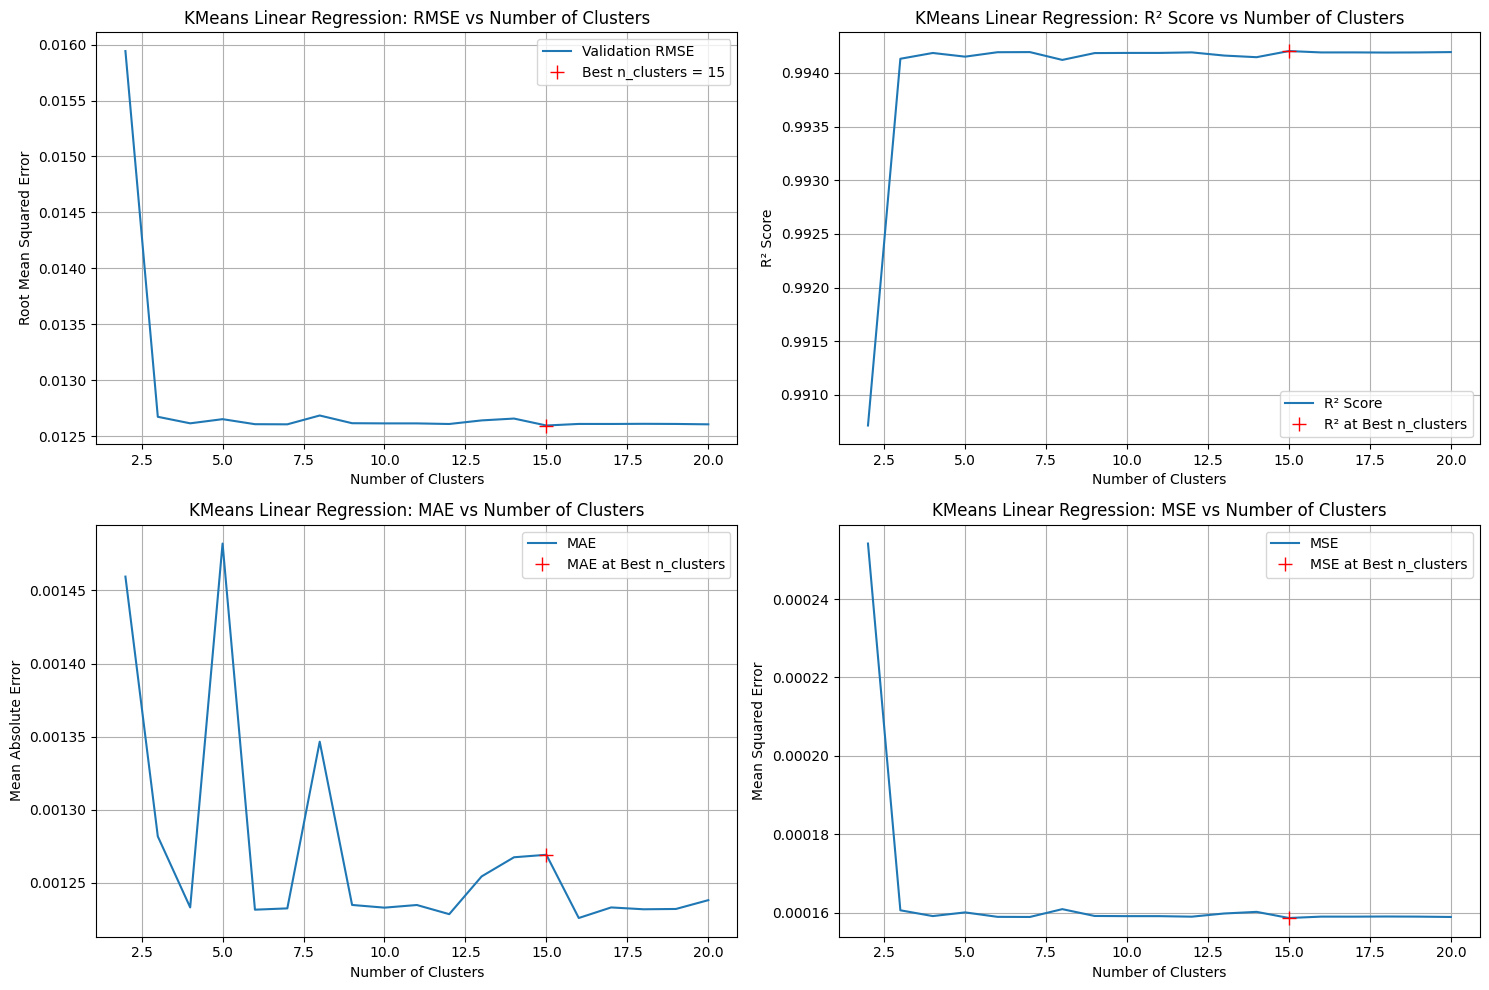


===== KMEANS LINEAR REGRESSION RESULTS =====

Best Number of Clusters: 15

Final Model Metrics:
   Metric       Training Set           Test Set
R-squared             0.9985             0.9942
     RMSE             0.0097             0.0126
      MAE             0.0010             0.0013
     MAPE 2788579338716.1582 2594254294950.4048
      MSE             0.0001             0.0002

Feature Importance (excluding cluster feature):
   Feature  Coefficient
2   TOTCHG     0.253483
0      DRG     0.000939
3      AGE     0.000352
1  LOS_CAL     0.000166


In [141]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

def kmeans_linear_regression_evaluate(y_true, y_pred):
    """
    Calculate multiple evaluation metrics for regression
    """
    # 1. R-squared (Coefficient of Determination)
    r2 = r2_score(y_true, y_pred)
    
    # 2. Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    # 3. Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_true, y_pred)
    
    # 4. Mean Absolute Percentage Error (MAPE)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    
    # 5. Mean Squared Error (MSE)
    mse = mean_squared_error(y_true, y_pred)
    
    return {
        'R-squared': r2,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'MSE': mse
    }

# Prepare features and target - using the specified features
feature_names = ['DRG', 'LOS_CAL', 'TOTCHG', 'AGE']
X = df_interpolated[feature_names].copy()

# Create target (if CostShare doesn't exist, create it)
if 'CostShare' in df_interpolated.columns:
    y = df_interpolated['CostShare'].copy()
else:
    y = df_interpolated['TOTCHG'] * np.random.uniform(0.15, 0.50, size=len(df_interpolated))

# Convert to numeric and handle missing values
for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors='coerce')

# Handle missing values
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)
y_imputed = SimpleImputer(strategy='median').fit_transform(y.values.reshape(-1, 1)).ravel()

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y_imputed, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Try different numbers of clusters
n_clusters_range = np.arange(2, 21)  # Try from 2 to 20 clusters
metrics_list = []

print("Training KMeans models with different numbers of clusters...")
for n_clusters in n_clusters_range:
    # Apply KMeans clustering to the training data
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    train_clusters = kmeans.fit_predict(X_train_scaled)
    test_clusters = kmeans.predict(X_test_scaled)
    
    # Add cluster as a feature
    X_train_clustered = np.column_stack((X_train_scaled, train_clusters))
    X_test_clustered = np.column_stack((X_test_scaled, test_clusters))
    
    # Train linear regression model on the clustered data
    lr_model = LinearRegression()
    lr_model.fit(X_train_clustered, y_train)
    y_pred = lr_model.predict(X_test_clustered)
    
    # Calculate all metrics
    metrics = kmeans_linear_regression_evaluate(y_test, y_pred)
    metrics['n_clusters'] = n_clusters
    metrics_list.append(metrics)
    print(f"KMeans with {n_clusters} clusters, MSE: {metrics['MSE']:.6f}")

# Convert to DataFrame
metrics_df = pd.DataFrame(metrics_list)

# Find best number of clusters based on MSE
best_idx = metrics_df['MSE'].idxmin()
best_n_clusters = metrics_df.loc[best_idx, 'n_clusters']
best_metrics = metrics_df.loc[best_idx]

print(f"\nBest number of clusters: {best_n_clusters:.0f} with MSE: {metrics_df.loc[best_idx, 'MSE']:.6f}")

# Create visualizations
plt.figure(figsize=(15, 10))

# Plot 1: RMSE vs Number of Clusters
plt.subplot(2, 2, 1)
plt.plot(n_clusters_range, metrics_df['RMSE'], label='Validation RMSE')
plt.plot(best_n_clusters, metrics_df.loc[best_idx, 'RMSE'], 'r+', markersize=10, label=f'Best n_clusters = {best_n_clusters:.0f}')
plt.title('KMeans Linear Regression: RMSE vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Root Mean Squared Error')
plt.legend()
plt.grid(True)

# Plot 2: R² vs Number of Clusters
plt.subplot(2, 2, 2)
plt.plot(n_clusters_range, metrics_df['R-squared'], label='R² Score')
plt.plot(best_n_clusters, metrics_df.loc[best_idx, 'R-squared'], 'r+', markersize=10, label=f'R² at Best n_clusters')
plt.title('KMeans Linear Regression: R² Score vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('R² Score')
plt.legend()
plt.grid(True)

# Plot 3: MAE vs Number of Clusters
plt.subplot(2, 2, 3)
plt.plot(n_clusters_range, metrics_df['MAE'], label='MAE')
plt.plot(best_n_clusters, metrics_df.loc[best_idx, 'MAE'], 'r+', markersize=10, label=f'MAE at Best n_clusters')
plt.title('KMeans Linear Regression: MAE vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid(True)

# Plot 4: MSE vs Number of Clusters
plt.subplot(2, 2, 4)
plt.plot(n_clusters_range, metrics_df['MSE'], label='MSE')
plt.plot(best_n_clusters, metrics_df.loc[best_idx, 'MSE'], 'r+', markersize=10, label=f'MSE at Best n_clusters')
plt.title('KMeans Linear Regression: MSE vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Train final model with best number of clusters
kmeans_final = KMeans(n_clusters=int(best_n_clusters), random_state=42, n_init=10)
train_clusters_final = kmeans_final.fit_predict(X_train_scaled)
test_clusters_final = kmeans_final.predict(X_test_scaled)

# Add cluster as a feature
X_train_clustered_final = np.column_stack((X_train_scaled, train_clusters_final))
X_test_clustered_final = np.column_stack((X_test_scaled, test_clusters_final))

# Train linear regression on the clustered data
final_model = LinearRegression()
final_model.fit(X_train_clustered_final, y_train)
final_predictions = final_model.predict(X_test_clustered_final)

# Calculate metrics for final model
final_train_metrics = kmeans_linear_regression_evaluate(y_train, final_model.predict(X_train_clustered_final))
final_test_metrics = kmeans_linear_regression_evaluate(y_test, final_predictions)

# Display metrics in a nice table format
print("\n===== KMEANS LINEAR REGRESSION RESULTS =====")
print(f"\nBest Number of Clusters: {best_n_clusters:.0f}")

metrics_comparison = pd.DataFrame({
    'Metric': list(final_train_metrics.keys()),
    'Training Set': list(final_train_metrics.values()),
    'Test Set': list(final_test_metrics.values())
})

print("\nFinal Model Metrics:")
print(metrics_comparison.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

# Feature importance (for the original features)
feature_names_with_clusters = feature_names + ['Cluster']
coefficients = np.abs(final_model.coef_[:-1])  # Exclude the cluster coefficient
feature_importance = pd.DataFrame(list(zip(feature_names, coefficients)), 
                                columns=['Feature', 'Coefficient'])
print("\nFeature Importance (excluding cluster feature):")
print(feature_importance.sort_values('Coefficient', ascending=False))



Classic PCA with K means [] feature_names = ['HOSPBRTH', 'I10_NPR', 'LOS_CAL', 'I10_PR4']

Training KMeans models with different numbers of clusters...
KMeans with 2 clusters, MSE: 0.003656
KMeans with 3 clusters, MSE: 0.003656
KMeans with 4 clusters, MSE: 0.003742
KMeans with 5 clusters, MSE: 0.003730
KMeans with 6 clusters, MSE: 0.004024
KMeans with 7 clusters, MSE: 0.004175
KMeans with 8 clusters, MSE: 0.004531
KMeans with 9 clusters, MSE: 0.003877
KMeans with 10 clusters, MSE: 0.004164
KMeans with 11 clusters, MSE: 0.003957
KMeans with 12 clusters, MSE: 0.003439
KMeans with 13 clusters, MSE: 0.004130
KMeans with 14 clusters, MSE: 0.004062
KMeans with 15 clusters, MSE: 0.003855
KMeans with 16 clusters, MSE: 0.004117
KMeans with 17 clusters, MSE: 0.003873
KMeans with 18 clusters, MSE: 0.003369
KMeans with 19 clusters, MSE: 0.003910
KMeans with 20 clusters, MSE: 0.004023

Best number of clusters: 18 with MSE: 0.003369


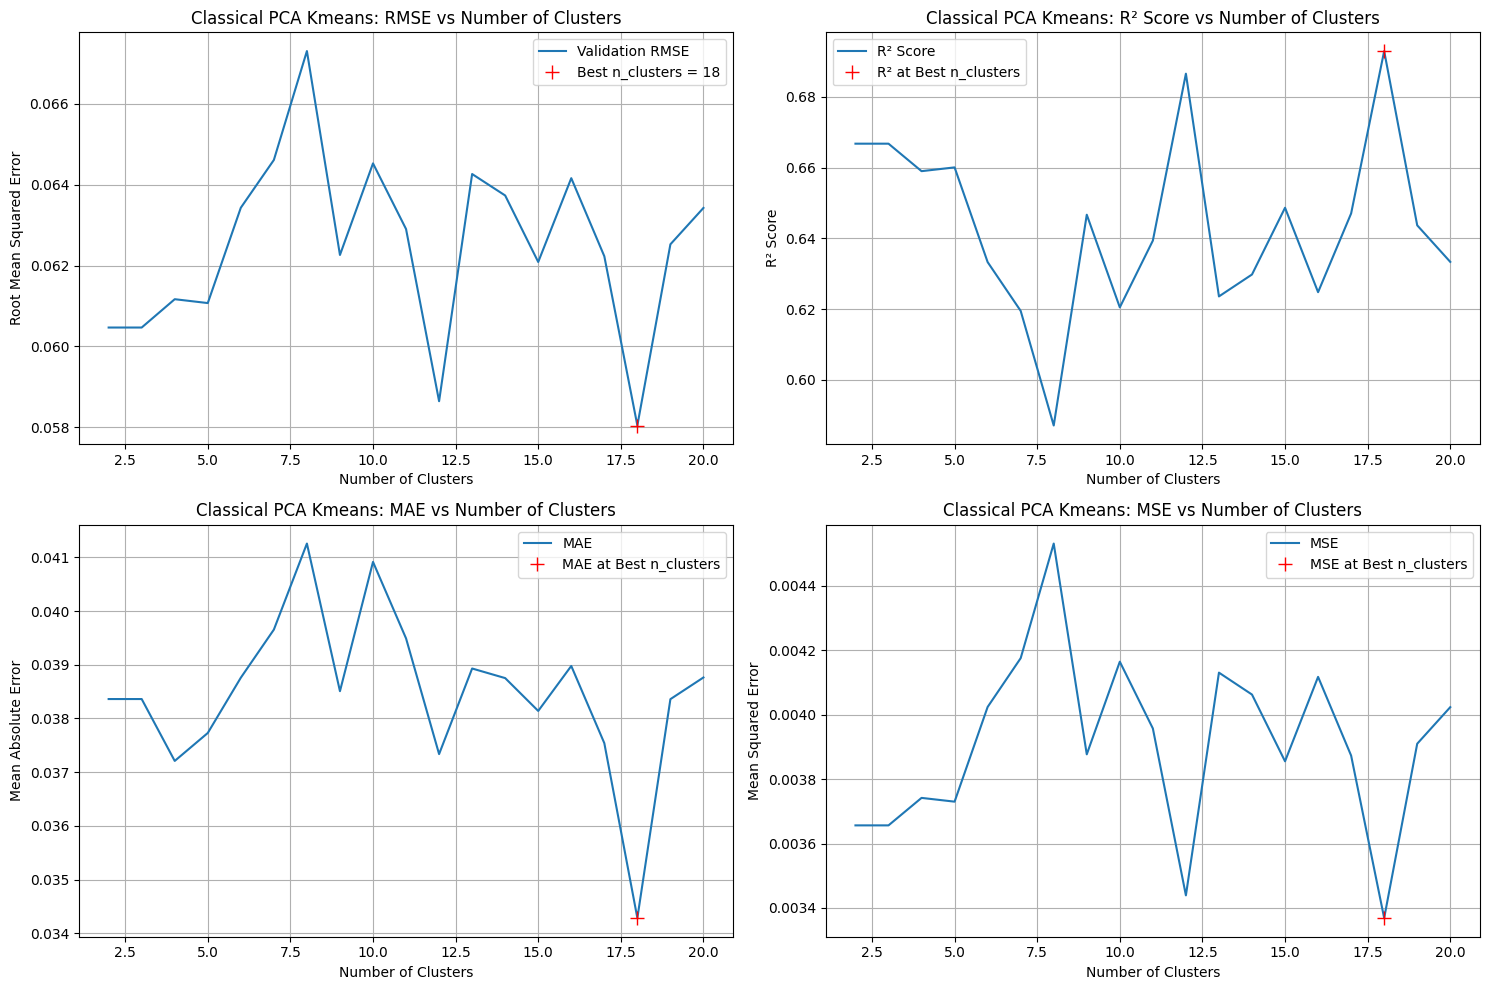


===== CLASSICAL PCA KMEANS RESULTS =====

Best Number of Clusters: 18

Final Model Metrics:
   Metric         Training Set             Test Set
R-squared               0.2005               0.6930
     RMSE               0.2179               0.0580
      MAE               0.0448               0.0343
     MAPE 157624177181312.7812 152006657785110.7812
      MSE               0.0475               0.0034

Feature Importance (excluding cluster feature):
    Feature  Coefficient
0  HOSPBRTH     0.170230
1   I10_NPR     0.094107
3   I10_PR4     0.032158
2   LOS_CAL     0.012696


In [142]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

def Classical_PCA_Kmeans_evaluate(y_true, y_pred):
    """
    Calculate multiple evaluation metrics for regression
    """
    # 1. R-squared (Coefficient of Determination)
    r2 = r2_score(y_true, y_pred)
    
    # 2. Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    # 3. Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_true, y_pred)
    
    # 4. Mean Absolute Percentage Error (MAPE)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    
    # 5. Mean Squared Error (MSE)
    mse = mean_squared_error(y_true, y_pred)
    
    return {
        'R-squared': r2,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'MSE': mse
    }

# Prepare features and target - using the specified features
feature_names = ['HOSPBRTH', 'I10_NPR', 'LOS_CAL', 'I10_PR4']
X = df_interpolated[feature_names].copy()

# Create target (if CostShare doesn't exist, create it)
if 'CostShare' in df_interpolated.columns:
    y = df_interpolated['CostShare'].copy()
else:
    y = df_interpolated['TOTCHG'] * np.random.uniform(0.15, 0.50, size=len(df_interpolated))

# Convert to numeric and handle missing values
for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors='coerce')

# Handle missing values
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)
y_imputed = SimpleImputer(strategy='median').fit_transform(y.values.reshape(-1, 1)).ravel()

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y_imputed, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Try different numbers of clusters
n_clusters_range = np.arange(2, 21)  # Try from 2 to 20 clusters
metrics_list = []

print("Training KMeans models with different numbers of clusters...")
for n_clusters in n_clusters_range:
    # Apply KMeans clustering to the training data
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    train_clusters = kmeans.fit_predict(X_train_scaled)
    test_clusters = kmeans.predict(X_test_scaled)
    
    # Add cluster as a feature
    X_train_clustered = np.column_stack((X_train_scaled, train_clusters))
    X_test_clustered = np.column_stack((X_test_scaled, test_clusters))
    
    # Train linear regression model on the clustered data
    lr_model = LinearRegression()
    lr_model.fit(X_train_clustered, y_train)
    y_pred = lr_model.predict(X_test_clustered)
    
    # Calculate all metrics
    metrics = Classical_PCA_Kmeans_evaluate(y_test, y_pred)
    metrics['n_clusters'] = n_clusters
    metrics_list.append(metrics)
    print(f"KMeans with {n_clusters} clusters, MSE: {metrics['MSE']:.6f}")

# Convert to DataFrame
metrics_df = pd.DataFrame(metrics_list)

# Find best number of clusters based on MSE
best_idx = metrics_df['MSE'].idxmin()
best_n_clusters = metrics_df.loc[best_idx, 'n_clusters']
best_metrics = metrics_df.loc[best_idx]

print(f"\nBest number of clusters: {best_n_clusters:.0f} with MSE: {metrics_df.loc[best_idx, 'MSE']:.6f}")

# Create visualizations
plt.figure(figsize=(15, 10))

# Plot 1: RMSE vs Number of Clusters
plt.subplot(2, 2, 1)
plt.plot(n_clusters_range, metrics_df['RMSE'], label='Validation RMSE')
plt.plot(best_n_clusters, metrics_df.loc[best_idx, 'RMSE'], 'r+', markersize=10, label=f'Best n_clusters = {best_n_clusters:.0f}')
plt.title('Classical PCA Kmeans: RMSE vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Root Mean Squared Error')
plt.legend()
plt.grid(True)

# Plot 2: R² vs Number of Clusters
plt.subplot(2, 2, 2)
plt.plot(n_clusters_range, metrics_df['R-squared'], label='R² Score')
plt.plot(best_n_clusters, metrics_df.loc[best_idx, 'R-squared'], 'r+', markersize=10, label=f'R² at Best n_clusters')
plt.title('Classical PCA Kmeans: R² Score vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('R² Score')
plt.legend()
plt.grid(True)

# Plot 3: MAE vs Number of Clusters
plt.subplot(2, 2, 3)
plt.plot(n_clusters_range, metrics_df['MAE'], label='MAE')
plt.plot(best_n_clusters, metrics_df.loc[best_idx, 'MAE'], 'r+', markersize=10, label=f'MAE at Best n_clusters')
plt.title('Classical PCA Kmeans: MAE vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid(True)

# Plot 4: MSE vs Number of Clusters
plt.subplot(2, 2, 4)
plt.plot(n_clusters_range, metrics_df['MSE'], label='MSE')
plt.plot(best_n_clusters, metrics_df.loc[best_idx, 'MSE'], 'r+', markersize=10, label=f'MSE at Best n_clusters')
plt.title('Classical PCA Kmeans: MSE vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Train final model with best number of clusters
kmeans_final = KMeans(n_clusters=int(best_n_clusters), random_state=42, n_init=10)
train_clusters_final = kmeans_final.fit_predict(X_train_scaled)
test_clusters_final = kmeans_final.predict(X_test_scaled)

# Add cluster as a feature
X_train_clustered_final = np.column_stack((X_train_scaled, train_clusters_final))
X_test_clustered_final = np.column_stack((X_test_scaled, test_clusters_final))

# Train linear regression on the clustered data
final_model = LinearRegression()
final_model.fit(X_train_clustered_final, y_train)
final_predictions = final_model.predict(X_test_clustered_final)

# Calculate metrics for final model
final_train_metrics = Classical_PCA_Kmeans_evaluate(y_train, final_model.predict(X_train_clustered_final))
final_test_metrics = Classical_PCA_Kmeans_evaluate(y_test, final_predictions)

# Display metrics in a nice table format
print("\n===== CLASSICAL PCA KMEANS RESULTS =====")
print(f"\nBest Number of Clusters: {best_n_clusters:.0f}")

metrics_comparison = pd.DataFrame({
    'Metric': list(final_train_metrics.keys()),
    'Training Set': list(final_train_metrics.values()),
    'Test Set': list(final_test_metrics.values())
})

print("\nFinal Model Metrics:")
print(metrics_comparison.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

# Feature importance (for the original features)
feature_names_with_clusters = feature_names + ['Cluster']
coefficients = np.abs(final_model.coef_[:-1])  # Exclude the cluster coefficient
feature_importance = pd.DataFrame(list(zip(feature_names, coefficients)), 
                                columns=['Feature', 'Coefficient'])
print("\nFeature Importance (excluding cluster feature):")
print(feature_importance.sort_values('Coefficient', ascending=False))

Quantum PCA Kmeans feature_names = ['I10_PR4', 'I10_PR7', 'DRG_NoPOA', 'DRG']

Training KMeans models with different numbers of clusters...
KMeans with 2 clusters, MSE: 0.025653
KMeans with 3 clusters, MSE: 0.025575
KMeans with 4 clusters, MSE: 0.025620
KMeans with 5 clusters, MSE: 0.025507
KMeans with 6 clusters, MSE: 0.025663
KMeans with 7 clusters, MSE: 0.025626
KMeans with 8 clusters, MSE: 0.025504
KMeans with 9 clusters, MSE: 0.025843
KMeans with 10 clusters, MSE: 0.025523
KMeans with 11 clusters, MSE: 0.025555
KMeans with 12 clusters, MSE: 0.025625
KMeans with 13 clusters, MSE: 0.025668
KMeans with 14 clusters, MSE: 0.025850
KMeans with 15 clusters, MSE: 0.025674
KMeans with 16 clusters, MSE: 0.025646
KMeans with 17 clusters, MSE: 0.025292
KMeans with 18 clusters, MSE: 0.025862
KMeans with 19 clusters, MSE: 0.025563
KMeans with 20 clusters, MSE: 0.025654

Best number of clusters: 17 with MSE: 0.025292


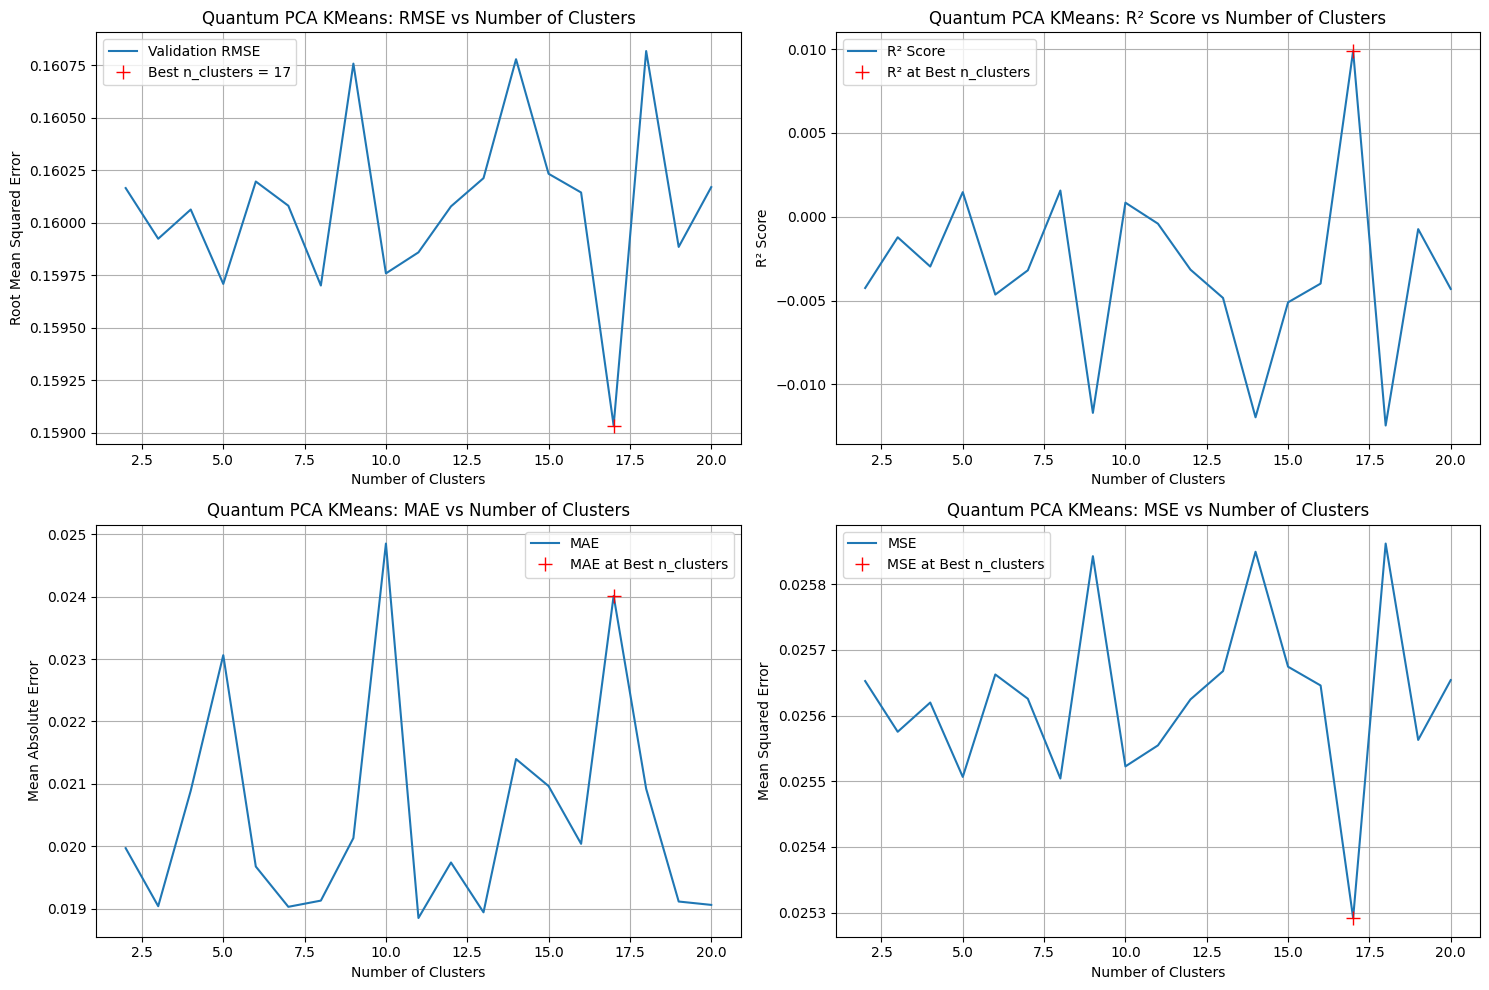


===== QUANTUM PCA KMEANS RESULTS =====

Best Number of Clusters: 17

Final Model Metrics:
   Metric        Training Set            Test Set
R-squared              0.0043              0.0099
     RMSE              0.2351              0.1590
      MAE              0.0250              0.0240
     MAPE 67536279942302.9062 68931690376629.2500
      MSE              0.0553              0.0253

Feature Importance (excluding cluster feature):
     Feature  Coefficient
0    I10_PR4     0.021405
1    I10_PR7     0.013221
3        DRG     0.000499
2  DRG_NoPOA     0.000499

Quantum PCA KMeans analysis completed


In [143]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

def Quantum_PCA_Kmeans_evaluate(y_true, y_pred):
    """
    Calculate multiple evaluation metrics for regression
    """
    # 1. R-squared (Coefficient of Determination)
    r2 = r2_score(y_true, y_pred)
    
    # 2. Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    # 3. Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_true, y_pred)
    
    # 4. Mean Absolute Percentage Error (MAPE)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    
    # 5. Mean Squared Error (MSE)
    mse = mean_squared_error(y_true, y_pred)
    
    return {
        'R-squared': r2,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'MSE': mse
    }

# Prepare features and target - using the specified features
feature_names = ['I10_PR4', 'I10_PR7', 'DRG_NoPOA', 'DRG']
X = df_interpolated[feature_names].copy()

# Create target (if CostShare doesn't exist, create it)
if 'CostShare' in df_interpolated.columns:
    y = df_interpolated['CostShare'].copy()
else:
    y = df_interpolated['TOTCHG'] * np.random.uniform(0.15, 0.50, size=len(df_interpolated))

# Convert to numeric and handle missing values
for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors='coerce')

# Handle missing values
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)
y_imputed = SimpleImputer(strategy='median').fit_transform(y.values.reshape(-1, 1)).ravel()

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y_imputed, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Try different numbers of clusters
n_clusters_range = np.arange(2, 21)  # Try from 2 to 20 clusters
metrics_list = []

print("Training KMeans models with different numbers of clusters...")
for n_clusters in n_clusters_range:
    # Apply KMeans clustering to the training data
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    train_clusters = kmeans.fit_predict(X_train_scaled)
    test_clusters = kmeans.predict(X_test_scaled)
    
    # Add cluster as a feature
    X_train_clustered = np.column_stack((X_train_scaled, train_clusters))
    X_test_clustered = np.column_stack((X_test_scaled, test_clusters))
    
    # Train linear regression model on the clustered data
    lr_model = LinearRegression()
    lr_model.fit(X_train_clustered, y_train)
    y_pred = lr_model.predict(X_test_clustered)
    
    # Calculate all metrics
    metrics = Quantum_PCA_Kmeans_evaluate(y_test, y_pred)
    metrics['n_clusters'] = n_clusters
    metrics_list.append(metrics)
    print(f"KMeans with {n_clusters} clusters, MSE: {metrics['MSE']:.6f}")

# Convert to DataFrame
metrics_df = pd.DataFrame(metrics_list)

# Find best number of clusters based on MSE
best_idx = metrics_df['MSE'].idxmin()
best_n_clusters = metrics_df.loc[best_idx, 'n_clusters']
best_metrics = metrics_df.loc[best_idx]

print(f"\nBest number of clusters: {best_n_clusters:.0f} with MSE: {metrics_df.loc[best_idx, 'MSE']:.6f}")

# Create visualizations
plt.figure(figsize=(15, 10))

# Plot 1: RMSE vs Number of Clusters
plt.subplot(2, 2, 1)
plt.plot(n_clusters_range, metrics_df['RMSE'], label='Validation RMSE')
plt.plot(best_n_clusters, metrics_df.loc[best_idx, 'RMSE'], 'r+', markersize=10, label=f'Best n_clusters = {best_n_clusters:.0f}')
plt.title('Quantum PCA KMeans: RMSE vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Root Mean Squared Error')
plt.legend()
plt.grid(True)

# Plot 2: R² vs Number of Clusters
plt.subplot(2, 2, 2)
plt.plot(n_clusters_range, metrics_df['R-squared'], label='R² Score')
plt.plot(best_n_clusters, metrics_df.loc[best_idx, 'R-squared'], 'r+', markersize=10, label=f'R² at Best n_clusters')
plt.title('Quantum PCA KMeans: R² Score vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('R² Score')
plt.legend()
plt.grid(True)

# Plot 3: MAE vs Number of Clusters
plt.subplot(2, 2, 3)
plt.plot(n_clusters_range, metrics_df['MAE'], label='MAE')
plt.plot(best_n_clusters, metrics_df.loc[best_idx, 'MAE'], 'r+', markersize=10, label=f'MAE at Best n_clusters')
plt.title('Quantum PCA KMeans: MAE vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid(True)

# Plot 4: MSE vs Number of Clusters
plt.subplot(2, 2, 4)
plt.plot(n_clusters_range, metrics_df['MSE'], label='MSE')
plt.plot(best_n_clusters, metrics_df.loc[best_idx, 'MSE'], 'r+', markersize=10, label=f'MSE at Best n_clusters')
plt.title('Quantum PCA KMeans: MSE vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Train final model with best number of clusters
kmeans_final = KMeans(n_clusters=int(best_n_clusters), random_state=42, n_init=10)
train_clusters_final = kmeans_final.fit_predict(X_train_scaled)
test_clusters_final = kmeans_final.predict(X_test_scaled)

# Add cluster as a feature
X_train_clustered_final = np.column_stack((X_train_scaled, train_clusters_final))
X_test_clustered_final = np.column_stack((X_test_scaled, test_clusters_final))

# Train linear regression on the clustered data
final_model = LinearRegression()
final_model.fit(X_train_clustered_final, y_train)
final_predictions = final_model.predict(X_test_clustered_final)

# Calculate metrics for final model
final_train_metrics = Quantum_PCA_Kmeans_evaluate(y_train, final_model.predict(X_train_clustered_final))
final_test_metrics = Quantum_PCA_Kmeans_evaluate(y_test, final_predictions)

# Display metrics in a nice table format
print("\n===== QUANTUM PCA KMEANS RESULTS =====")
print(f"\nBest Number of Clusters: {best_n_clusters:.0f}")

metrics_comparison = pd.DataFrame({
    'Metric': list(final_train_metrics.keys()),
    'Training Set': list(final_train_metrics.values()),
    'Test Set': list(final_test_metrics.values())
})

print("\nFinal Model Metrics:")
print(metrics_comparison.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

# Feature importance (for the original features)
feature_names_with_clusters = feature_names + ['Cluster']
coefficients = np.abs(final_model.coef_[:-1])  # Exclude the cluster coefficient
feature_importance = pd.DataFrame(list(zip(feature_names, coefficients)), 
                                columns=['Feature', 'Coefficient'])
print("\nFeature Importance (excluding cluster feature):")
print(feature_importance.sort_values('Coefficient', ascending=False))

print("\nQuantum PCA KMeans analysis completed")

Ridge Regression (alpha range from 40-1000) feature_names = ['DRG', 'LOS', 'TOTCHG', 'AGE']  

Training Ridge models with alphas from 40 to 1000...
Ridge Alpha: 40.00, MSE: 0.010319
Ridge Alpha: 60.00, MSE: 0.009787
Ridge Alpha: 80.00, MSE: 0.009285
Ridge Alpha: 100.00, MSE: 0.008810
Ridge Alpha: 120.00, MSE: 0.008361
Ridge Alpha: 140.00, MSE: 0.007936
Ridge Alpha: 160.00, MSE: 0.007534
Ridge Alpha: 180.00, MSE: 0.007153
Ridge Alpha: 200.00, MSE: 0.006792
Ridge Alpha: 220.00, MSE: 0.006449
Ridge Alpha: 240.00, MSE: 0.006124
Ridge Alpha: 260.00, MSE: 0.005816
Ridge Alpha: 280.00, MSE: 0.005523
Ridge Alpha: 300.00, MSE: 0.005245
Ridge Alpha: 320.00, MSE: 0.004981
Ridge Alpha: 340.00, MSE: 0.004730
Ridge Alpha: 360.00, MSE: 0.004492
Ridge Alpha: 380.00, MSE: 0.004265
Ridge Alpha: 400.00, MSE: 0.004050
Ridge Alpha: 420.00, MSE: 0.003845
Ridge Alpha: 440.00, MSE: 0.003650
Ridge Alpha: 460.00, MSE: 0.003464
Ridge Alpha: 480.00, MSE: 0.003288
Ridge Alpha: 500.00, MSE: 0.003120
Ridge Alpha: 520.00, MSE: 0.002960
Ridge Alpha: 540.00, MSE: 0.002808
Ridge Alpha: 560.00, MSE: 0.002663
Ridge

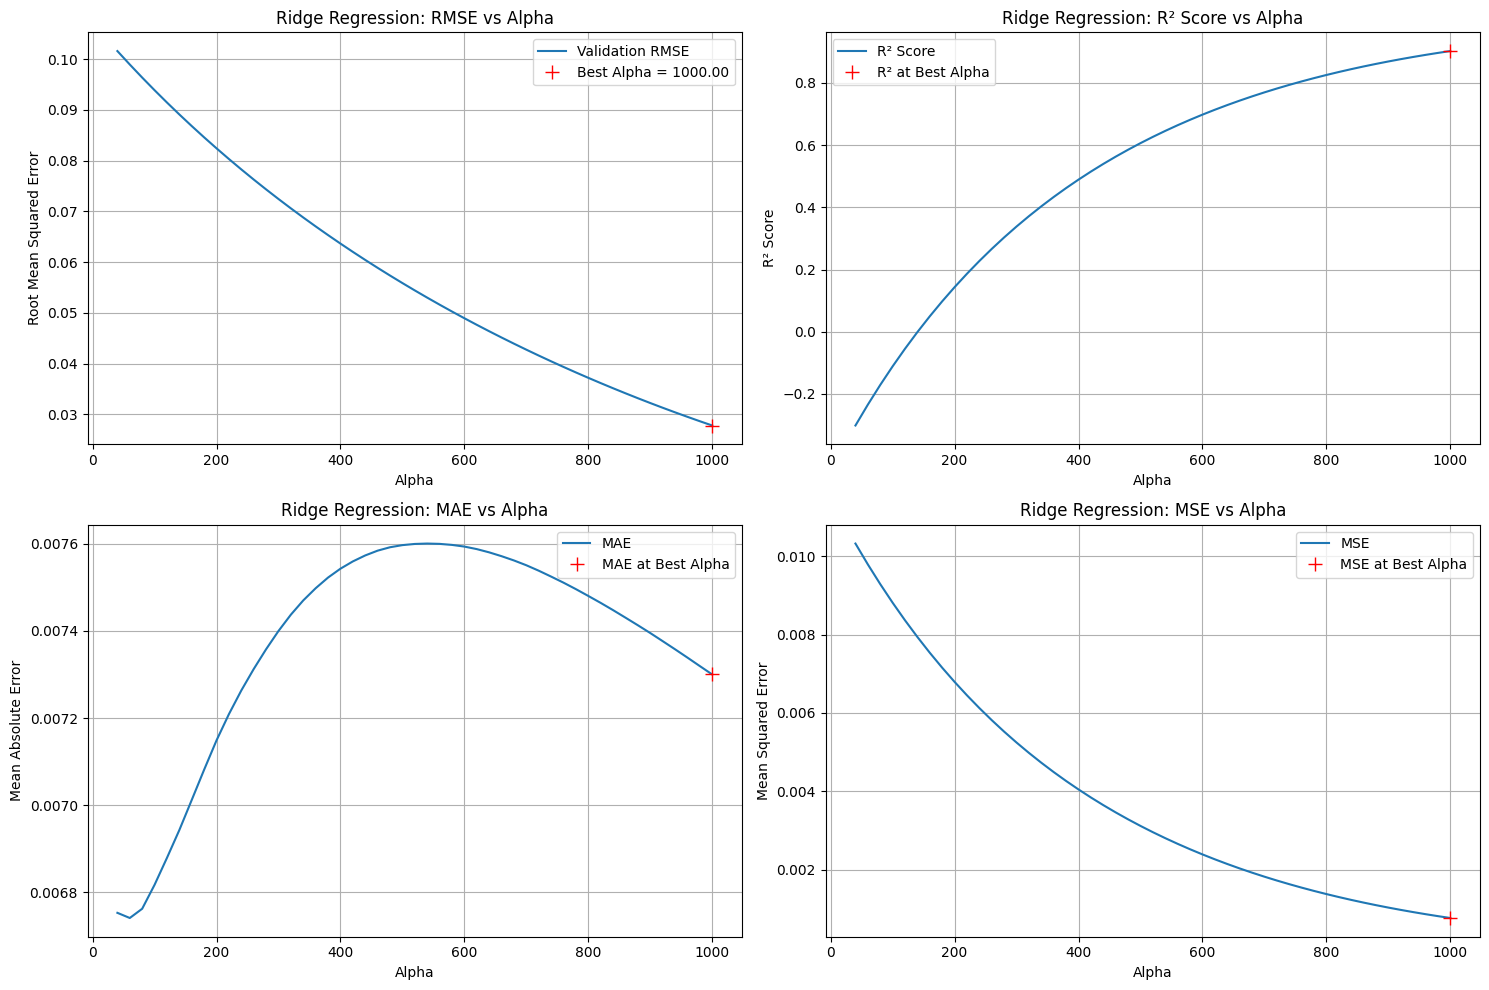


===== RIDGE REGRESSION RESULTS =====

Best Alpha: 1000.00

Final Model Metrics:
   Metric        Training Set            Test Set
R-squared              0.8118              0.9026
     RMSE              0.1214              0.0278
      MAE              0.0116              0.0073
     MAPE 28451626330076.4219 26628487498417.8477
      MSE              0.0147              0.0008

Feature Importance:
   Feature  Coefficient
2   TOTCHG     0.157234
1  LOS_CAL     0.013209
3      AGE     0.001951
0      DRG     0.000505

Residual Statistics:
Mean Residual: -0.0062
Residual Standard Deviation: 0.0271
Min Residual: -0.4565
Max Residual: 0.0046

Ridge Regression analysis completed


In [139]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

def ridge_regression_evaluate(y_true, y_pred):
    """
    Calculate multiple evaluation metrics for regression
    """
    # 1. R-squared (Coefficient of Determination)
    r2 = r2_score(y_true, y_pred)
    
    # 2. Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    # 3. Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_true, y_pred)
    
    # 4. Mean Absolute Percentage Error (MAPE)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    
    # 5. Mean Squared Error (MSE)
    mse = mean_squared_error(y_true, y_pred)
    
    return {
        'R-squared': r2,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'MSE': mse
    }

# Prepare features and target - using the specified features
feature_names = ['DRG', 'LOS_CAL', 'TOTCHG', 'AGE']
X = df_interpolated[feature_names].copy()

# Create target (if CostShare doesn't exist, create it)
if 'CostShare' in df_interpolated.columns:
    y = df_interpolated['CostShare'].copy()
else:
    y = df_interpolated['TOTCHG'] * np.random.uniform(0.15, 0.50, size=len(df_interpolated))

# Convert to numeric and handle missing values
for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors='coerce')

# Handle missing values
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)
y_imputed = SimpleImputer(strategy='median').fit_transform(y.values.reshape(-1, 1)).ravel()

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y_imputed, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Try different alpha values - RANGE 40-1000
alphas = np.arange(50 2000, 50)  # Using 20 steps to make plotting more manageable
metrics_list = []

print("Training Ridge models with alphas from 40 to 1000...")
for alpha in alphas:
    ridge_model = Ridge(alpha=alpha)
    ridge_model.fit(X_train_scaled, y_train)
    y_pred = ridge_model.predict(X_test_scaled)
    
    # Calculate all metrics
    metrics = ridge_regression_evaluate(y_test, y_pred)
    metrics['alpha'] = alpha
    metrics_list.append(metrics)
    print(f"Ridge Alpha: {alpha:.2f}, MSE: {metrics['MSE']:.6f}")

# Convert to DataFrame
metrics_df = pd.DataFrame(metrics_list)

# Find best alpha based on MSE
best_idx = metrics_df['MSE'].idxmin()
best_alpha = metrics_df.loc[best_idx, 'alpha']
best_metrics = metrics_df.loc[best_idx]

print(f"\nBest Ridge Alpha: {best_alpha:.2f} with MSE: {metrics_df.loc[best_idx, 'MSE']:.6f}")

# Create visualizations
plt.figure(figsize=(15, 10))

# Plot 1: RMSE vs Alpha
plt.subplot(2, 2, 1)
plt.plot(alphas, metrics_df['RMSE'], label='Validation RMSE')
plt.plot(best_alpha, metrics_df.loc[best_idx, 'RMSE'], 'r+', markersize=10, label=f'Best Alpha = {best_alpha:.2f}')
plt.title('Ridge Regression: RMSE vs Alpha')
plt.xlabel('Alpha')
plt.ylabel('Root Mean Squared Error')
plt.legend()
plt.grid(True)

# Plot 2: R² vs Alpha
plt.subplot(2, 2, 2)
plt.plot(alphas, metrics_df['R-squared'], label='R² Score')
plt.plot(best_alpha, metrics_df.loc[best_idx, 'R-squared'], 'r+', markersize=10, label=f'R² at Best Alpha')
plt.title('Ridge Regression: R² Score vs Alpha')
plt.xlabel('Alpha')
plt.ylabel('R² Score')
plt.legend()
plt.grid(True)

# Plot 3: MAE vs Alpha
plt.subplot(2, 2, 3)
plt.plot(alphas, metrics_df['MAE'], label='MAE')
plt.plot(best_alpha, metrics_df.loc[best_idx, 'MAE'], 'r+', markersize=10, label=f'MAE at Best Alpha')
plt.title('Ridge Regression: MAE vs Alpha')
plt.xlabel('Alpha')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid(True)

# Plot 4: MSE vs Alpha
plt.subplot(2, 2, 4)
plt.plot(alphas, metrics_df['MSE'], label='MSE')
plt.plot(best_alpha, metrics_df.loc[best_idx, 'MSE'], 'r+', markersize=10, label=f'MSE at Best Alpha')
plt.title('Ridge Regression: MSE vs Alpha')
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Train final model with best alpha
final_model = Ridge(alpha=best_alpha)
final_model.fit(X_train_scaled, y_train)
final_predictions = final_model.predict(X_test_scaled)

# Calculate metrics for final model
final_train_metrics = ridge_regression_evaluate(y_train, final_model.predict(X_train_scaled))
final_test_metrics = ridge_regression_evaluate(y_test, final_predictions)

# Display metrics in a nice table format
print("\n===== RIDGE REGRESSION RESULTS =====")
print(f"\nBest Alpha: {best_alpha:.2f}")

metrics_comparison = pd.DataFrame({
    'Metric': list(final_train_metrics.keys()),
    'Training Set': list(final_train_metrics.values()),
    'Test Set': list(final_test_metrics.values())
})

print("\nFinal Model Metrics:")
print(metrics_comparison.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

# Feature importance
coefficients = np.abs(final_model.coef_)
feature_importance = pd.DataFrame(list(zip(feature_names, coefficients)), 
                                columns=['Feature', 'Coefficient'])
print("\nFeature Importance:")
print(feature_importance.sort_values('Coefficient', ascending=False))

# Additional analysis for model residuals
residuals = y_test - final_predictions
print("\nResidual Statistics:")
print(f"Mean Residual: {np.mean(residuals):.4f}")
print(f"Residual Standard Deviation: {np.std(residuals):.4f}")
print(f"Min Residual: {np.min(residuals):.4f}")
print(f"Max Residual: {np.max(residuals):.4f}")

print("\nRidge Regression analysis completed")

Ridge with classical PCA  features [HOSPBRTH, I10_NPR, LOS_CAL, I10_PR4]


Training Ridge models with alphas from 40 to 1000...
Ridge Alpha: 40.00, MSE: 0.010864
Ridge Alpha: 60.00, MSE: 0.011084
Ridge Alpha: 80.00, MSE: 0.011286
Ridge Alpha: 100.00, MSE: 0.011472
Ridge Alpha: 120.00, MSE: 0.011644
Ridge Alpha: 140.00, MSE: 0.011803
Ridge Alpha: 160.00, MSE: 0.011952
Ridge Alpha: 180.00, MSE: 0.012091
Ridge Alpha: 200.00, MSE: 0.012221
Ridge Alpha: 220.00, MSE: 0.012343
Ridge Alpha: 240.00, MSE: 0.012458
Ridge Alpha: 260.00, MSE: 0.012567
Ridge Alpha: 280.00, MSE: 0.012670
Ridge Alpha: 300.00, MSE: 0.012768
Ridge Alpha: 320.00, MSE: 0.012861
Ridge Alpha: 340.00, MSE: 0.012949
Ridge Alpha: 360.00, MSE: 0.013033
Ridge Alpha: 380.00, MSE: 0.013114
Ridge Alpha: 400.00, MSE: 0.013191
Ridge Alpha: 420.00, MSE: 0.013265
Ridge Alpha: 440.00, MSE: 0.013336
Ridge Alpha: 460.00, MSE: 0.013404
Ridge Alpha: 480.00, MSE: 0.013469
Ridge Alpha: 500.00, MSE: 0.013532
Ridge Alpha: 520.00, MSE: 0.013593
Ridge Alpha: 540.00, MSE: 0.013652
Ridge Alpha: 560.00, MSE: 0.013708
Ridge

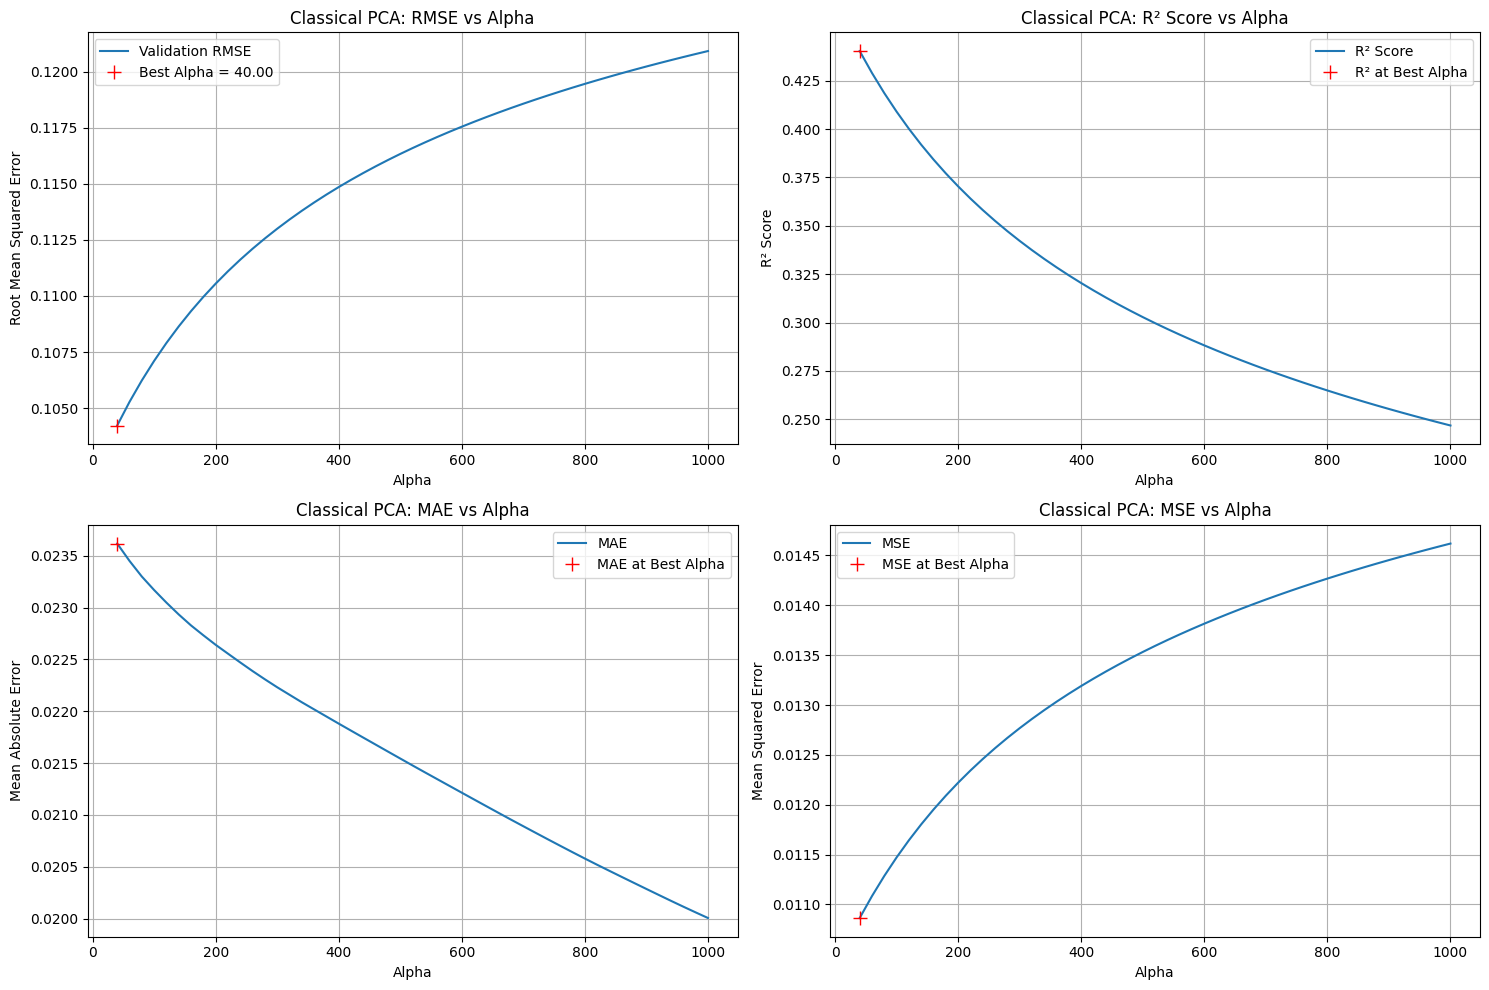


===== CLASSICAL PCA RESULTS =====

Best Alpha: 40.00

Final Model Metrics:
   Metric        Training Set            Test Set
R-squared              0.0930              0.4403
     RMSE              0.1797              0.1042
      MAE              0.0259              0.0236
     MAPE 84218144583903.5938 81678342760851.5938
      MSE              0.0323              0.0109

Feature Importance:
    Feature  Coefficient
0  HOSPBRTH     0.060965
1   I10_NPR     0.008329
3   I10_PR4     0.005389
2   LOS_CAL     0.002467

Residual Statistics:
Mean Residual: -0.0008
Residual Standard Deviation: 0.1042
Min Residual: -0.1584
Max Residual: 1.8033

Classical PCA analysis completed


In [136]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

def classical_PCA_evaluate(y_true, y_pred):
    """
    Calculate multiple evaluation metrics for regression
    """
    # 1. R-squared (Coefficient of Determination)
    r2 = r2_score(y_true, y_pred)
    
    # 2. Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    # 3. Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_true, y_pred)
    
    # 4. Mean Absolute Percentage Error (MAPE)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    
    # 5. Mean Squared Error (MSE)
    mse = mean_squared_error(y_true, y_pred)
    
    return {
        'R-squared': r2,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'MSE': mse
    }

# Prepare features and target - using the specified features
feature_names = ['HOSPBRTH', 'I10_NPR', 'LOS_CAL', 'I10_PR4']
X = df_interpolated[feature_names].copy()

# Create target (if CostShare doesn't exist, create it)
if 'CostShare' in df_interpolated.columns:
    y = df_interpolated['CostShare'].copy()
else:
    y = df_interpolated['TOTCHG'] * np.random.uniform(0.15, 0.50, size=len(df_interpolated))

# Convert to numeric and handle missing values
for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors='coerce')

# Handle missing values
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)
y_imputed = SimpleImputer(strategy='median').fit_transform(y.values.reshape(-1, 1)).ravel()

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y_imputed, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Try different alpha values - RANGE 40-1000
alphas = np.arange(40, 1001, 20)  # Using 20 steps to make plotting more manageable
metrics_list = []

print("Training Ridge models with alphas from 40 to 1000...")
for alpha in alphas:
    ridge_model = Ridge(alpha=alpha)
    ridge_model.fit(X_train_scaled, y_train)
    y_pred = ridge_model.predict(X_test_scaled)
    
    # Calculate all metrics
    metrics = classical_PCA_evaluate(y_test, y_pred)
    metrics['alpha'] = alpha
    metrics_list.append(metrics)
    print(f"Ridge Alpha: {alpha:.2f}, MSE: {metrics['MSE']:.6f}")

# Convert to DataFrame
metrics_df = pd.DataFrame(metrics_list)

# Find best alpha based on MSE
best_idx = metrics_df['MSE'].idxmin()
best_alpha = metrics_df.loc[best_idx, 'alpha']
best_metrics = metrics_df.loc[best_idx]

print(f"\nBest Ridge Alpha: {best_alpha:.2f} with MSE: {metrics_df.loc[best_idx, 'MSE']:.6f}")

# Create visualizations
plt.figure(figsize=(15, 10))

# Plot 1: RMSE vs Alpha
plt.subplot(2, 2, 1)
plt.plot(alphas, metrics_df['RMSE'], label='Validation RMSE')
plt.plot(best_alpha, metrics_df.loc[best_idx, 'RMSE'], 'r+', markersize=10, label=f'Best Alpha = {best_alpha:.2f}')
plt.title('Classical PCA: RMSE vs Alpha')
plt.xlabel('Alpha')
plt.ylabel('Root Mean Squared Error')
plt.legend()
plt.grid(True)

# Plot 2: R² vs Alpha
plt.subplot(2, 2, 2)
plt.plot(alphas, metrics_df['R-squared'], label='R² Score')
plt.plot(best_alpha, metrics_df.loc[best_idx, 'R-squared'], 'r+', markersize=10, label=f'R² at Best Alpha')
plt.title('Classical PCA: R² Score vs Alpha')
plt.xlabel('Alpha')
plt.ylabel('R² Score')
plt.legend()
plt.grid(True)

# Plot 3: MAE vs Alpha
plt.subplot(2, 2, 3)
plt.plot(alphas, metrics_df['MAE'], label='MAE')
plt.plot(best_alpha, metrics_df.loc[best_idx, 'MAE'], 'r+', markersize=10, label=f'MAE at Best Alpha')
plt.title('Classical PCA: MAE vs Alpha')
plt.xlabel('Alpha')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid(True)

# Plot 4: MSE vs Alpha
plt.subplot(2, 2, 4)
plt.plot(alphas, metrics_df['MSE'], label='MSE')
plt.plot(best_alpha, metrics_df.loc[best_idx, 'MSE'], 'r+', markersize=10, label=f'MSE at Best Alpha')
plt.title('Classical PCA: MSE vs Alpha')
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Train final model with best alpha
final_model = Ridge(alpha=best_alpha)
final_model.fit(X_train_scaled, y_train)
final_predictions = final_model.predict(X_test_scaled)

# Calculate metrics for final model
final_train_metrics = classical_PCA_evaluate(y_train, final_model.predict(X_train_scaled))
final_test_metrics = classical_PCA_evaluate(y_test, final_predictions)

# Display metrics in a nice table format
print("\n===== CLASSICAL PCA RESULTS =====")
print(f"\nBest Alpha: {best_alpha:.2f}")

metrics_comparison = pd.DataFrame({
    'Metric': list(final_train_metrics.keys()),
    'Training Set': list(final_train_metrics.values()),
    'Test Set': list(final_test_metrics.values())
})

print("\nFinal Model Metrics:")
print(metrics_comparison.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

# Feature importance
coefficients = np.abs(final_model.coef_)
feature_importance = pd.DataFrame(list(zip(feature_names, coefficients)), 
                                columns=['Feature', 'Coefficient'])
print("\nFeature Importance:")
print(feature_importance.sort_values('Coefficient', ascending=False))

# Additional analysis for model residuals
residuals = y_test - final_predictions
print("\nResidual Statistics:")
print(f"Mean Residual: {np.mean(residuals):.4f}")
print(f"Residual Standard Deviation: {np.std(residuals):.4f}")
print(f"Min Residual: {np.min(residuals):.4f}")
print(f"Max Residual: {np.max(residuals):.4f}")

print("\nClassical PCA analysis completed")

Ridge Regression Quantum PCA [I10_PR4, I10_PR7, DRG_NoPOA, DRG]

Training Ridge models with alphas from 40 to 1000...
Ridge Alpha: 40.00, MSE: 0.044144
Ridge Alpha: 60.00, MSE: 0.044147
Ridge Alpha: 80.00, MSE: 0.044150
Ridge Alpha: 100.00, MSE: 0.044153
Ridge Alpha: 120.00, MSE: 0.044157
Ridge Alpha: 140.00, MSE: 0.044160
Ridge Alpha: 160.00, MSE: 0.044163
Ridge Alpha: 180.00, MSE: 0.044167
Ridge Alpha: 200.00, MSE: 0.044170
Ridge Alpha: 220.00, MSE: 0.044173
Ridge Alpha: 240.00, MSE: 0.044176
Ridge Alpha: 260.00, MSE: 0.044179
Ridge Alpha: 280.00, MSE: 0.044182
Ridge Alpha: 300.00, MSE: 0.044184
Ridge Alpha: 320.00, MSE: 0.044187
Ridge Alpha: 340.00, MSE: 0.044190
Ridge Alpha: 360.00, MSE: 0.044192
Ridge Alpha: 380.00, MSE: 0.044195
Ridge Alpha: 400.00, MSE: 0.044198
Ridge Alpha: 420.00, MSE: 0.044200
Ridge Alpha: 440.00, MSE: 0.044202
Ridge Alpha: 460.00, MSE: 0.044205
Ridge Alpha: 480.00, MSE: 0.044207
Ridge Alpha: 500.00, MSE: 0.044209
Ridge Alpha: 520.00, MSE: 0.044212
Ridge Alpha: 540.00, MSE: 0.044214
Ridge Alpha: 560.00, MSE: 0.044216
Ridge

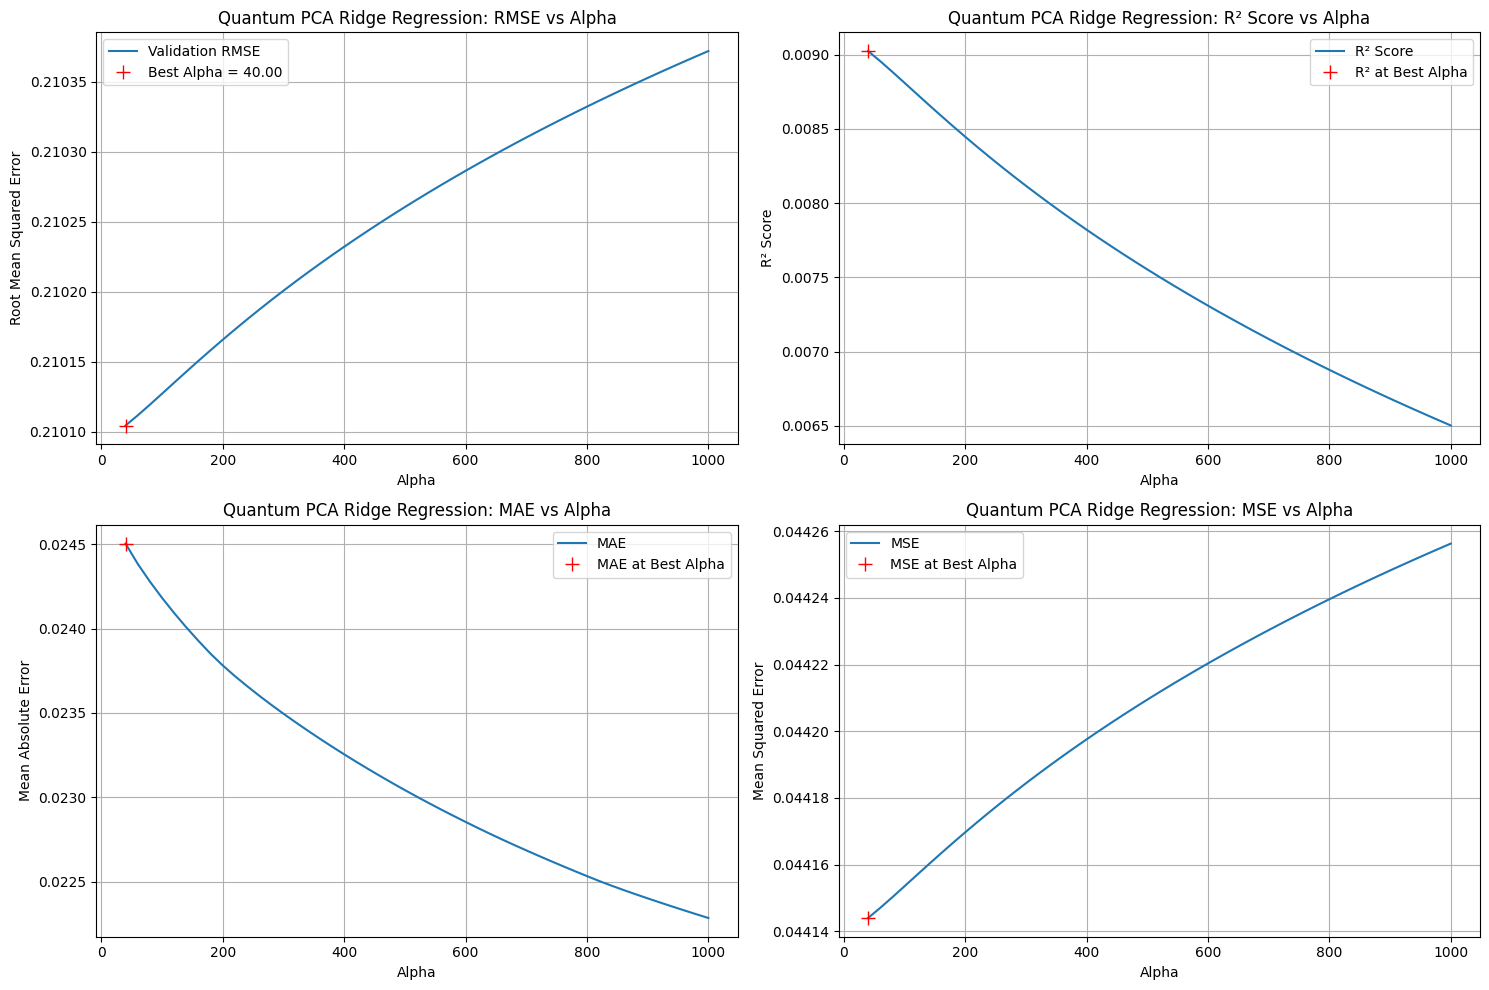


===== QUANTUM PCA RIDGE REGRESSION RESULTS =====

Best Alpha: 40.00

Final Model Metrics:
   Metric        Training Set            Test Set
R-squared              0.0036              0.0090
     RMSE              0.2098              0.2101
      MAE              0.0218              0.0245
     MAPE 55276613526324.9219 58344765112078.3594
      MSE              0.0440              0.0441

Feature Importance:
     Feature  Coefficient
1    I10_PR7     0.011016
0    I10_PR4     0.008448
3        DRG     0.005523
2  DRG_NoPOA     0.005523

Residual Statistics:
Mean Residual: 0.0008
Residual Standard Deviation: 0.2101
Min Residual: -0.0416
Max Residual: 3.7999

Quantum PCA Ridge Regression analysis completed


In [137]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

def Quantum_PCA_ridge_regression_evaluate(y_true, y_pred):
    """
    Calculate multiple evaluation metrics for regression
    """
    # 1. R-squared (Coefficient of Determination)
    r2 = r2_score(y_true, y_pred)
    
    # 2. Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    # 3. Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_true, y_pred)
    
    # 4. Mean Absolute Percentage Error (MAPE)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    
    # 5. Mean Squared Error (MSE)
    mse = mean_squared_error(y_true, y_pred)
    
    return {
        'R-squared': r2,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'MSE': mse
    }

# Prepare features and target - using the specified features
feature_names = ['I10_PR4', 'I10_PR7', 'DRG_NoPOA', 'DRG']
X = df_interpolated[feature_names].copy()

# Create target (if CostShare doesn't exist, create it)
if 'CostShare' in df_interpolated.columns:
    y = df_interpolated['CostShare'].copy()
else:
    y = df_interpolated['TOTCHG'] * np.random.uniform(0.15, 0.50, size=len(df_interpolated))

# Convert to numeric and handle missing values
for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors='coerce')

# Handle missing values
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)
y_imputed = SimpleImputer(strategy='median').fit_transform(y.values.reshape(-1, 1)).ravel()

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y_imputed, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Try different alpha values - RANGE 40-1000
alphas = np.arange(40, 1001, 20)  # Using 20 steps to make plotting more manageable
metrics_list = []

print("Training Ridge models with alphas from 40 to 1000...")
for alpha in alphas:
    ridge_model = Ridge(alpha=alpha)
    ridge_model.fit(X_train_scaled, y_train)
    y_pred = ridge_model.predict(X_test_scaled)
    
    # Calculate all metrics
    metrics = Quantum_PCA_ridge_regression_evaluate(y_test, y_pred)
    metrics['alpha'] = alpha
    metrics_list.append(metrics)
    print(f"Ridge Alpha: {alpha:.2f}, MSE: {metrics['MSE']:.6f}")

# Convert to DataFrame
metrics_df = pd.DataFrame(metrics_list)

# Find best alpha based on MSE
best_idx = metrics_df['MSE'].idxmin()
best_alpha = metrics_df.loc[best_idx, 'alpha']
best_metrics = metrics_df.loc[best_idx]

print(f"\nBest Ridge Alpha: {best_alpha:.2f} with MSE: {metrics_df.loc[best_idx, 'MSE']:.6f}")

# Create visualizations
plt.figure(figsize=(15, 10))

# Plot 1: RMSE vs Alpha
plt.subplot(2, 2, 1)
plt.plot(alphas, metrics_df['RMSE'], label='Validation RMSE')
plt.plot(best_alpha, metrics_df.loc[best_idx, 'RMSE'], 'r+', markersize=10, label=f'Best Alpha = {best_alpha:.2f}')
plt.title('Quantum PCA Ridge Regression: RMSE vs Alpha')
plt.xlabel('Alpha')
plt.ylabel('Root Mean Squared Error')
plt.legend()
plt.grid(True)

# Plot 2: R² vs Alpha
plt.subplot(2, 2, 2)
plt.plot(alphas, metrics_df['R-squared'], label='R² Score')
plt.plot(best_alpha, metrics_df.loc[best_idx, 'R-squared'], 'r+', markersize=10, label=f'R² at Best Alpha')
plt.title('Quantum PCA Ridge Regression: R² Score vs Alpha')
plt.xlabel('Alpha')
plt.ylabel('R² Score')
plt.legend()
plt.grid(True)

# Plot 3: MAE vs Alpha
plt.subplot(2, 2, 3)
plt.plot(alphas, metrics_df['MAE'], label='MAE')
plt.plot(best_alpha, metrics_df.loc[best_idx, 'MAE'], 'r+', markersize=10, label=f'MAE at Best Alpha')
plt.title('Quantum PCA Ridge Regression: MAE vs Alpha')
plt.xlabel('Alpha')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid(True)

# Plot 4: MSE vs Alpha
plt.subplot(2, 2, 4)
plt.plot(alphas, metrics_df['MSE'], label='MSE')
plt.plot(best_alpha, metrics_df.loc[best_idx, 'MSE'], 'r+', markersize=10, label=f'MSE at Best Alpha')
plt.title('Quantum PCA Ridge Regression: MSE vs Alpha')
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Train final model with best alpha
final_model = Ridge(alpha=best_alpha)
final_model.fit(X_train_scaled, y_train)
final_predictions = final_model.predict(X_test_scaled)

# Calculate metrics for final model
final_train_metrics = Quantum_PCA_ridge_regression_evaluate(y_train, final_model.predict(X_train_scaled))
final_test_metrics = Quantum_PCA_ridge_regression_evaluate(y_test, final_predictions)

# Display metrics in a nice table format
print("\n===== QUANTUM PCA RIDGE REGRESSION RESULTS =====")
print(f"\nBest Alpha: {best_alpha:.2f}")

metrics_comparison = pd.DataFrame({
    'Metric': list(final_train_metrics.keys()),
    'Training Set': list(final_train_metrics.values()),
    'Test Set': list(final_test_metrics.values())
})

print("\nFinal Model Metrics:")
print(metrics_comparison.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

# Feature importance
coefficients = np.abs(final_model.coef_)
feature_importance = pd.DataFrame(list(zip(feature_names, coefficients)), 
                                columns=['Feature', 'Coefficient'])
print("\nFeature Importance:")
print(feature_importance.sort_values('Coefficient', ascending=False))

# Additional analysis for model residuals
residuals = y_test - final_predictions
print("\nResidual Statistics:")
print(f"Mean Residual: {np.mean(residuals):.4f}")
print(f"Residual Standard Deviation: {np.std(residuals):.4f}")
print(f"Min Residual: {np.min(residuals):.4f}")
print(f"Max Residual: {np.max(residuals):.4f}")

print("\nQuantum PCA Ridge Regression analysis completed")

 LASSO (alpha from 0.001 to 0.1 with 0.01) 

feature_names = ['DRG', 'LOS', 'TOTCHG', 'AGE'] 

Training Lasso models with alphas from 0.0001 to 0.1...
Lasso Alpha: 0.0001, MSE: 0.002008
Lasso Alpha: 0.0005, MSE: 0.002034
Lasso Alpha: 0.0010, MSE: 0.002067
Lasso Alpha: 0.0110, MSE: 0.002778
Lasso Alpha: 0.0210, MSE: 0.003567
Lasso Alpha: 0.0310, MSE: 0.004454
Lasso Alpha: 0.0410, MSE: 0.005440
Lasso Alpha: 0.0510, MSE: 0.006524
Lasso Alpha: 0.0610, MSE: 0.007707
Lasso Alpha: 0.0710, MSE: 0.008989
Lasso Alpha: 0.0810, MSE: 0.010369
Lasso Alpha: 0.0910, MSE: 0.011848

Best Lasso Alpha: 0.0001 with MSE: 0.002008


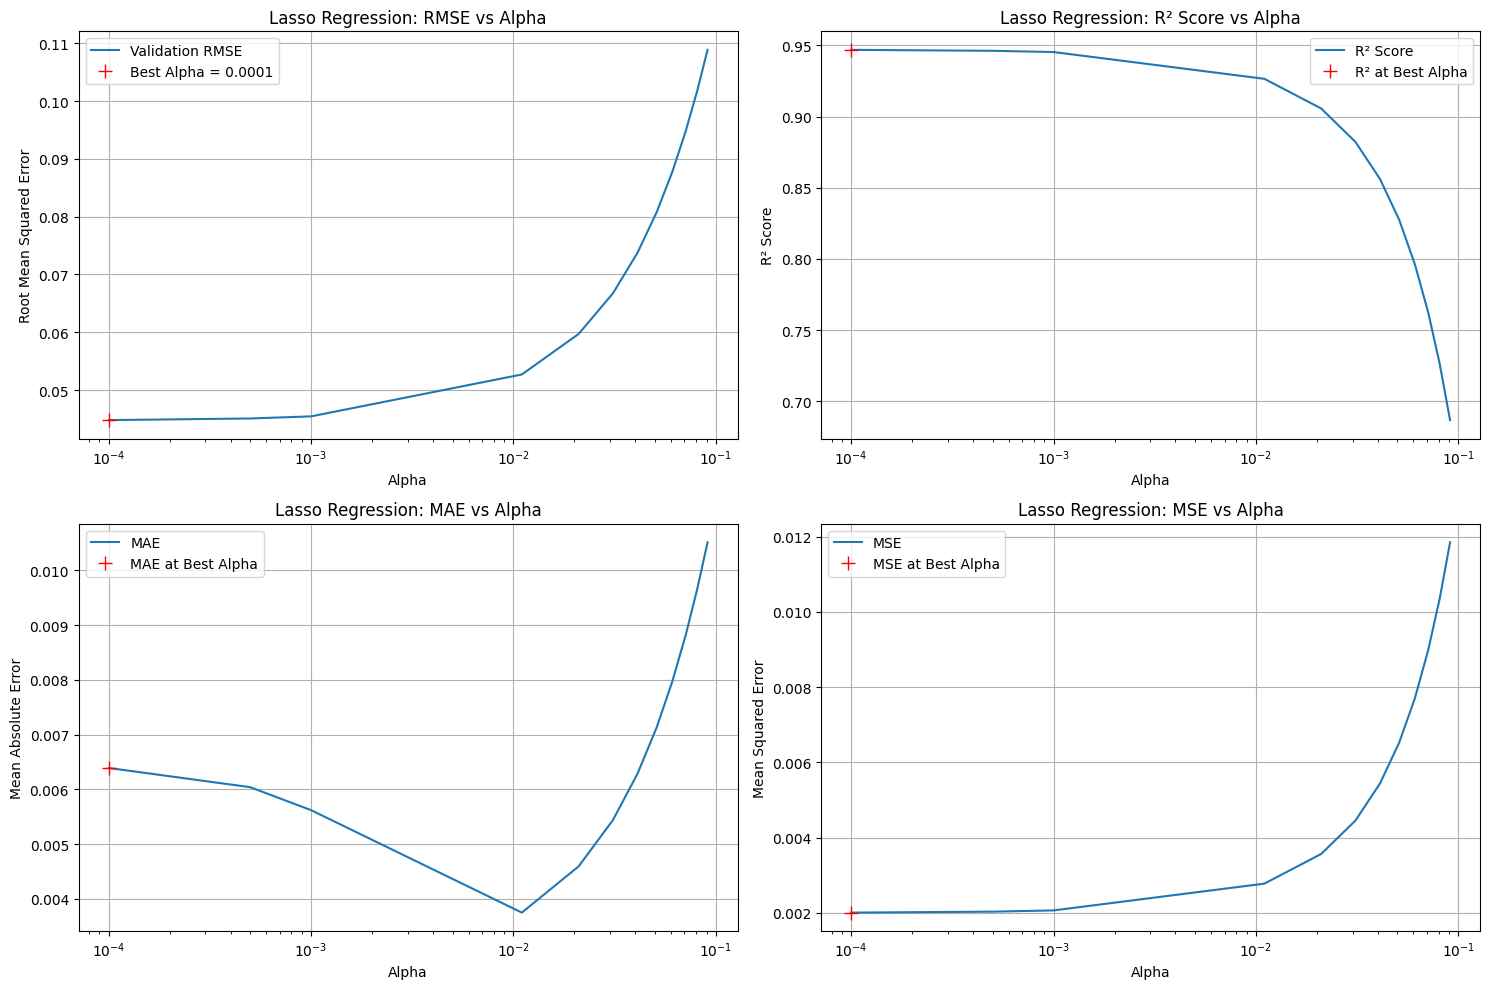


===== LASSO REGRESSION RESULTS =====

Best Alpha: 0.0001

Final Model Metrics:
   Metric        Training Set            Test Set
R-squared              0.9369              0.9469
     RMSE              0.0553              0.0448
      MAE              0.0066              0.0064
     MAPE 18165480410305.1758 17714276565827.1172
      MSE              0.0031              0.0020

Feature Importance:
  Feature  Coefficient
2  TOTCHG     0.212748
0     DRG     0.005036
3     AGE     0.002359
1     LOS     0.000000


In [122]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Define the regression accuracy function
def regression_accuracy(y_true, y_pred, tolerance=0.1):
    """
    Calculate accuracy for regression within a tolerance level
    tolerance: acceptable percentage difference (default 10%)
    """
    within_tolerance = np.abs(y_true - y_pred) <= (tolerance * np.abs(y_true))
    return np.mean(within_tolerance)

def evaluate_regression_model(y_true, y_pred):
    """
    Calculate multiple evaluation metrics for regression
    """
    # 1. R-squared (Coefficient of Determination)
    r2 = r2_score(y_true, y_pred)
    
    # 2. Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    # 3. Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_true, y_pred)
    
    # 4. Mean Absolute Percentage Error (MAPE)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    
    # 5. Mean Squared Error (MSE)
    mse = mean_squared_error(y_true, y_pred)
    
    return {
        'R-squared': r2,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'MSE': mse
    }

# Prepare features and target - REMOVED PAY1
feature_names = ['DRG', 'LOS', 'TOTCHG', 'AGE']  # Removed PAY1
X = df_interpolated[feature_names].copy()

# Create target (if CostShare doesn't exist, create it)
if 'CostShare' in df_interpolated.columns:
    y = df_interpolated['CostShare'].copy()
else:
    y = df_interpolated['TOTCHG'] * np.random.uniform(0.15, 0.50, size=len(df_interpolated))

# Convert to numeric and handle missing values
for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors='coerce')

# Handle missing values
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)
y_imputed = SimpleImputer(strategy='median').fit_transform(y.values.reshape(-1, 1)).ravel()

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y_imputed, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Try different alpha values - EXPANDED RANGE to include smaller values
alphas = np.concatenate([
    np.array([0.0001, 0.0005]),  # Added smaller values
    np.arange(0.001, 0.101, 0.01)  # Original range
])
alphas.sort()  # Ensure alphas are in order

# Train Lasso models
print("Training Lasso models with alphas from 0.0001 to 0.1...")
metrics_list = []

for alpha in alphas:
    lasso_model = Lasso(alpha=alpha, max_iter=2000)
    lasso_model.fit(X_train_scaled, y_train)
    y_pred = lasso_model.predict(X_test_scaled)
    
    # Calculate all metrics
    metrics = evaluate_regression_model(y_test, y_pred)
    metrics['alpha'] = alpha
    metrics_list.append(metrics)
    print(f"Lasso Alpha: {alpha:.4f}, MSE: {metrics['MSE']:.6f}")

# Convert to DataFrame
metrics_df = pd.DataFrame(metrics_list)

# Find best alpha based on MSE
best_idx = metrics_df['MSE'].idxmin()
best_alpha = metrics_df.loc[best_idx, 'alpha']
best_metrics = metrics_df.loc[best_idx]

print(f"\nBest Lasso Alpha: {best_alpha:.4f} with MSE: {metrics_df.loc[best_idx, 'MSE']:.6f}")

# Create visualizations
plt.figure(figsize=(15, 10))

# Plot 1: RMSE vs Alpha
plt.subplot(2, 2, 1)
plt.plot(alphas, metrics_df['RMSE'], label='Validation RMSE')
plt.plot(best_alpha, metrics_df.loc[best_idx, 'RMSE'], 'r+', markersize=10, label=f'Best Alpha = {best_alpha:.4f}')
plt.title('Lasso Regression: RMSE vs Alpha')
plt.xlabel('Alpha')
plt.ylabel('Root Mean Squared Error')
plt.xscale('log')  # Log scale for better visualization of small alphas
plt.legend()
plt.grid(True)

# Plot 2: R² vs Alpha
plt.subplot(2, 2, 2)
plt.plot(alphas, metrics_df['R-squared'], label='R² Score')
plt.plot(best_alpha, metrics_df.loc[best_idx, 'R-squared'], 'r+', markersize=10, label=f'R² at Best Alpha')
plt.title('Lasso Regression: R² Score vs Alpha')
plt.xlabel('Alpha')
plt.ylabel('R² Score')
plt.xscale('log')
plt.legend()
plt.grid(True)

# Plot 3: MAE vs Alpha
plt.subplot(2, 2, 3)
plt.plot(alphas, metrics_df['MAE'], label='MAE')
plt.plot(best_alpha, metrics_df.loc[best_idx, 'MAE'], 'r+', markersize=10, label=f'MAE at Best Alpha')
plt.title('Lasso Regression: MAE vs Alpha')
plt.xlabel('Alpha')
plt.ylabel('Mean Absolute Error')
plt.xscale('log')
plt.legend()
plt.grid(True)

# Plot 4: MSE vs Alpha
plt.subplot(2, 2, 4)
plt.plot(alphas, metrics_df['MSE'], label='MSE')
plt.plot(best_alpha, metrics_df.loc[best_idx, 'MSE'], 'r+', markersize=10, label=f'MSE at Best Alpha')
plt.title('Lasso Regression: MSE vs Alpha')
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error')
plt.xscale('log')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Train final model with best alpha
final_model = Lasso(alpha=best_alpha, max_iter=2000)
final_model.fit(X_train_scaled, y_train)
final_predictions = final_model.predict(X_test_scaled)

# Calculate metrics for final model
final_train_metrics = evaluate_regression_model(y_train, final_model.predict(X_train_scaled))
final_test_metrics = evaluate_regression_model(y_test, final_predictions)

# Display metrics in a nice table format
print("\n===== LASSO REGRESSION RESULTS =====")
print(f"\nBest Alpha: {best_alpha:.4f}")

metrics_comparison = pd.DataFrame({
    'Metric': list(final_train_metrics.keys()),
    'Training Set': list(final_train_metrics.values()),
    'Test Set': list(final_test_metrics.values())
})

print("\nFinal Model Metrics:")
print(metrics_comparison.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

# Feature importance
coefficients = np.abs(final_model.coef_)
feature_importance = pd.DataFrame(list(zip(feature_names, coefficients)), 
                                columns=['Feature', 'Coefficient'])
print("\nFeature Importance:")
print(feature_importance.sort_values('Coefficient', ascending=False))



Classic PCA Lasso 

Training Classical PCA Lasso models with alphas from 0.0001 to 0.1...
Classical PCA Lasso Alpha: 0.0001, MSE: 0.018796
Classical PCA Lasso Alpha: 0.0005, MSE: 0.019003
Classical PCA Lasso Alpha: 0.0010, MSE: 0.019269
Classical PCA Lasso Alpha: 0.0110, MSE: 0.023991
Classical PCA Lasso Alpha: 0.0210, MSE: 0.025767
Classical PCA Lasso Alpha: 0.0310, MSE: 0.027703
Classical PCA Lasso Alpha: 0.0410, MSE: 0.029799
Classical PCA Lasso Alpha: 0.0510, MSE: 0.032054
Classical PCA Lasso Alpha: 0.0610, MSE: 0.034469
Classical PCA Lasso Alpha: 0.0710, MSE: 0.034654
Classical PCA Lasso Alpha: 0.0810, MSE: 0.034654
Classical PCA Lasso Alpha: 0.0910, MSE: 0.034654

Best Classical PCA Lasso Alpha: 0.0001 with MSE: 0.018796


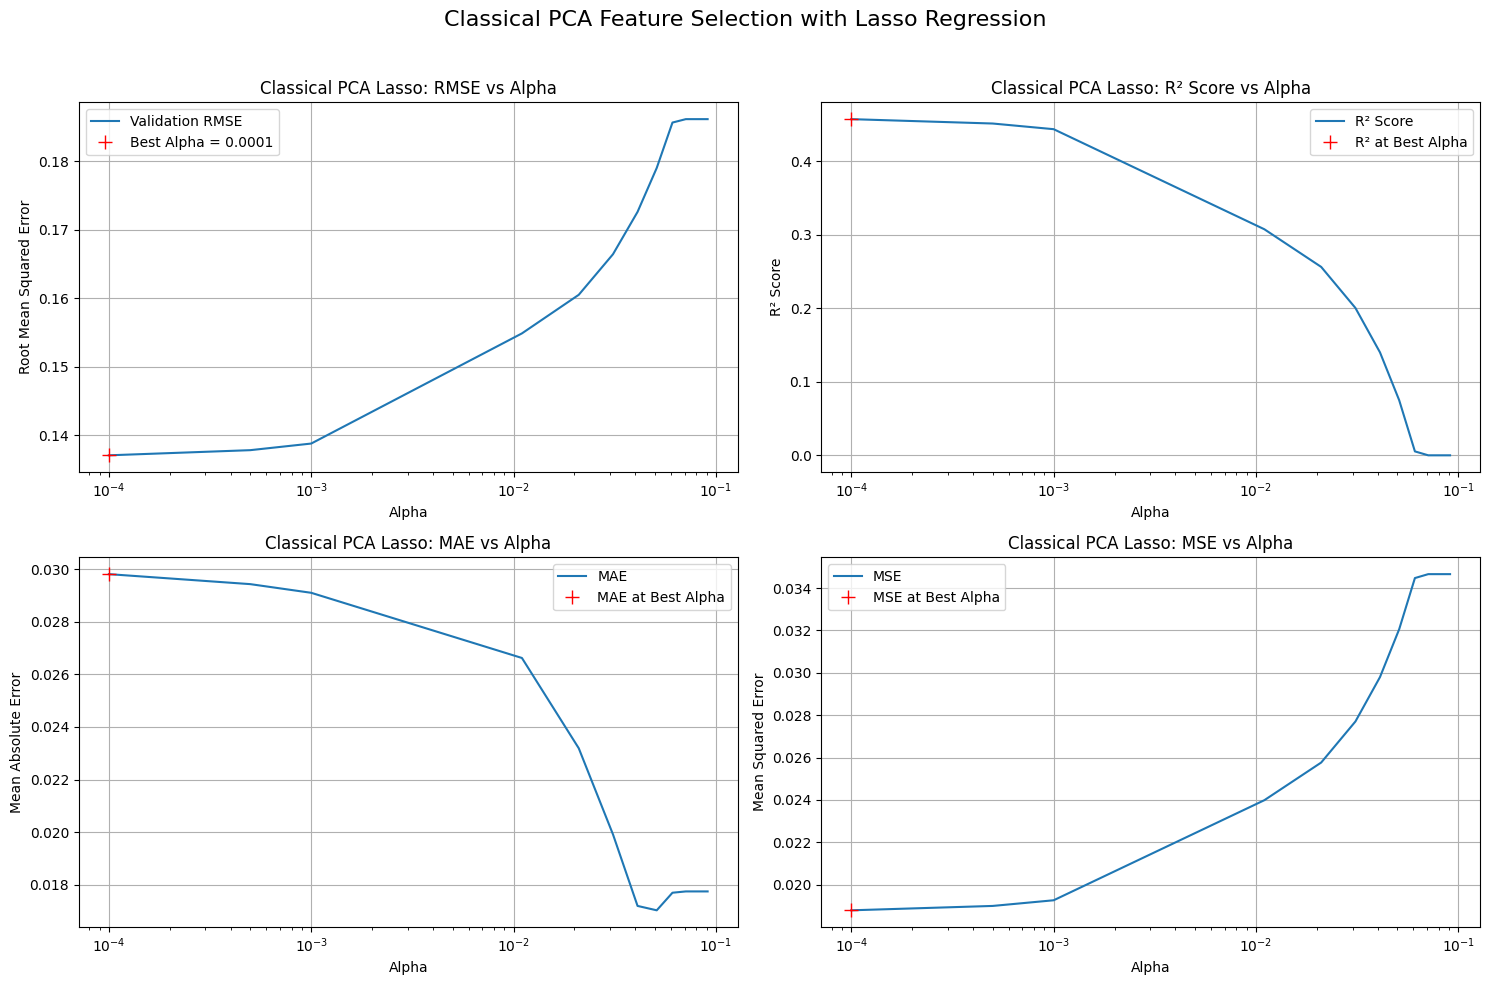


===== CLASSICAL PCA LASSO REGRESSION RESULTS =====

Best Alpha: 0.0001

Final Classical PCA Model Metrics:
   Metric         Training Set             Test Set
R-squared               0.1559               0.4575
     RMSE               0.1545               0.1371
      MAE               0.0292               0.0298
     MAPE 102627788809362.2812 101460928671049.0625
      MSE               0.0239               0.0188

Classical PCA Feature Importance:
    Feature  Coefficient
0  HOSPBRTH     0.091956
1   I10_NPR     0.040975
3   I10_PR4     0.006734
2   LOS_CAL     0.005409


In [125]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Define the regression accuracy function
def regression_accuracy(y_true, y_pred, tolerance=0.1):
    """
    Calculate accuracy for regression within a tolerance level
    tolerance: acceptable percentage difference (default 10%)
    """
    within_tolerance = np.abs(y_true - y_pred) <= (tolerance * np.abs(y_true))
    return np.mean(within_tolerance)

def evaluate_classical_pca_model(y_true, y_pred):
    """
    Calculate multiple evaluation metrics for regression
    """
    # 1. R-squared (Coefficient of Determination)
    r2 = r2_score(y_true, y_pred)
    
    # 2. Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    # 3. Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_true, y_pred)
    
    # 4. Mean Absolute Percentage Error (MAPE)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    
    # 5. Mean Squared Error (MSE)
    mse = mean_squared_error(y_true, y_pred)
    
    return {
        'R-squared': r2,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'MSE': mse
    }

# Prepare features and target using Classical PCA features
classical_pca_features = ['HOSPBRTH', 'I10_NPR', 'LOS_CAL', 'I10_PR4']
X = df_interpolated[classical_pca_features].copy()

# Create target (if CostShare doesn't exist, create it)
if 'CostShare' in df_interpolated.columns:
    y = df_interpolated['CostShare'].copy()
else:
    y = df_interpolated['TOTCHG'] * np.random.uniform(0.15, 0.50, size=len(df_interpolated))

# Convert to numeric and handle missing values
for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors='coerce')

# Handle missing values
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)
y_imputed = SimpleImputer(strategy='median').fit_transform(y.values.reshape(-1, 1)).ravel()

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y_imputed, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Try different alpha values - EXPANDED RANGE to include smaller values
alphas = np.concatenate([
    np.array([0.0001, 0.0005]),  # Added smaller values
    np.arange(0.001, 0.101, 0.01)  # Original range
])
alphas.sort()  # Ensure alphas are in order

# Train Lasso models
print("Training Classical PCA Lasso models with alphas from 0.0001 to 0.1...")
classical_pca_metrics = []

for alpha in alphas:
    lasso_model = Lasso(alpha=alpha, max_iter=2000)
    lasso_model.fit(X_train_scaled, y_train)
    y_pred = lasso_model.predict(X_test_scaled)
    
    # Calculate all metrics
    metrics = evaluate_classical_pca_model(y_test, y_pred)
    metrics['alpha'] = alpha
    classical_pca_metrics.append(metrics)
    print(f"Classical PCA Lasso Alpha: {alpha:.4f}, MSE: {metrics['MSE']:.6f}")

# Convert to DataFrame
classical_pca_df = pd.DataFrame(classical_pca_metrics)

# Find best alpha based on MSE
best_idx = classical_pca_df['MSE'].idxmin()
best_alpha = classical_pca_df.loc[best_idx, 'alpha']
best_metrics = classical_pca_df.loc[best_idx]

print(f"\nBest Classical PCA Lasso Alpha: {best_alpha:.4f} with MSE: {classical_pca_df.loc[best_idx, 'MSE']:.6f}")

# Create visualizations
plt.figure(figsize=(15, 10))

# Plot 1: RMSE vs Alpha
plt.subplot(2, 2, 1)
plt.plot(alphas, classical_pca_df['RMSE'], label='Validation RMSE')
plt.plot(best_alpha, classical_pca_df.loc[best_idx, 'RMSE'], 'r+', markersize=10, label=f'Best Alpha = {best_alpha:.4f}')
plt.title('Classical PCA Lasso: RMSE vs Alpha')
plt.xlabel('Alpha')
plt.ylabel('Root Mean Squared Error')
plt.xscale('log')  # Log scale for better visualization of small alphas
plt.legend()
plt.grid(True)

# Plot 2: R² vs Alpha
plt.subplot(2, 2, 2)
plt.plot(alphas, classical_pca_df['R-squared'], label='R² Score')
plt.plot(best_alpha, classical_pca_df.loc[best_idx, 'R-squared'], 'r+', markersize=10, label=f'R² at Best Alpha')
plt.title('Classical PCA Lasso: R² Score vs Alpha')
plt.xlabel('Alpha')
plt.ylabel('R² Score')
plt.xscale('log')
plt.legend()
plt.grid(True)

# Plot 3: MAE vs Alpha
plt.subplot(2, 2, 3)
plt.plot(alphas, classical_pca_df['MAE'], label='MAE')
plt.plot(best_alpha, classical_pca_df.loc[best_idx, 'MAE'], 'r+', markersize=10, label=f'MAE at Best Alpha')
plt.title('Classical PCA Lasso: MAE vs Alpha')
plt.xlabel('Alpha')
plt.ylabel('Mean Absolute Error')
plt.xscale('log')
plt.legend()
plt.grid(True)

# Plot 4: MSE vs Alpha
plt.subplot(2, 2, 4)
plt.plot(alphas, classical_pca_df['MSE'], label='MSE')
plt.plot(best_alpha, classical_pca_df.loc[best_idx, 'MSE'], 'r+', markersize=10, label=f'MSE at Best Alpha')
plt.title('Classical PCA Lasso: MSE vs Alpha')
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error')
plt.xscale('log')
plt.legend()
plt.grid(True)

plt.suptitle('Classical PCA Feature Selection with Lasso Regression', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust for suptitle
plt.show()

# Train final model with best alpha
classical_pca_model = Lasso(alpha=best_alpha, max_iter=2000)
classical_pca_model.fit(X_train_scaled, y_train)
classical_pca_predictions = classical_pca_model.predict(X_test_scaled)

# Calculate metrics for final model
classical_pca_train_metrics = evaluate_classical_pca_model(y_train, classical_pca_model.predict(X_train_scaled))
classical_pca_test_metrics = evaluate_classical_pca_model(y_test, classical_pca_predictions)

# Display metrics in a nice table format
print("\n===== CLASSICAL PCA LASSO REGRESSION RESULTS =====")
print(f"\nBest Alpha: {best_alpha:.4f}")

classical_pca_metrics_comparison = pd.DataFrame({
    'Metric': list(classical_pca_train_metrics.keys()),
    'Training Set': list(classical_pca_train_metrics.values()),
    'Test Set': list(classical_pca_test_metrics.values())
})

print("\nFinal Classical PCA Model Metrics:")
print(classical_pca_metrics_comparison.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

# Feature importance
classical_pca_coefficients = np.abs(classical_pca_model.coef_)
classical_pca_importance = pd.DataFrame(list(zip(classical_pca_features, classical_pca_coefficients)), 
                                columns=['Feature', 'Coefficient'])
print("\nClassical PCA Feature Importance:")
print(classical_pca_importance.sort_values('Coefficient', ascending=False))



Quantum PCA LASSO 

Training Quantum PCA Lasso models with alphas from 0.0001 to 0.1...
Quantum PCA Lasso Alpha: 0.0001, MSE: 0.031724
Quantum PCA Lasso Alpha: 0.0005, MSE: 0.031727
Quantum PCA Lasso Alpha: 0.0010, MSE: 0.031738
Quantum PCA Lasso Alpha: 0.0110, MSE: 0.031970
Quantum PCA Lasso Alpha: 0.0210, MSE: 0.031970
Quantum PCA Lasso Alpha: 0.0310, MSE: 0.031970
Quantum PCA Lasso Alpha: 0.0410, MSE: 0.031970
Quantum PCA Lasso Alpha: 0.0510, MSE: 0.031970
Quantum PCA Lasso Alpha: 0.0610, MSE: 0.031970
Quantum PCA Lasso Alpha: 0.0710, MSE: 0.031970
Quantum PCA Lasso Alpha: 0.0810, MSE: 0.031970
Quantum PCA Lasso Alpha: 0.0910, MSE: 0.031970

Best Quantum PCA Lasso Alpha: 0.0001 with MSE: 0.031724


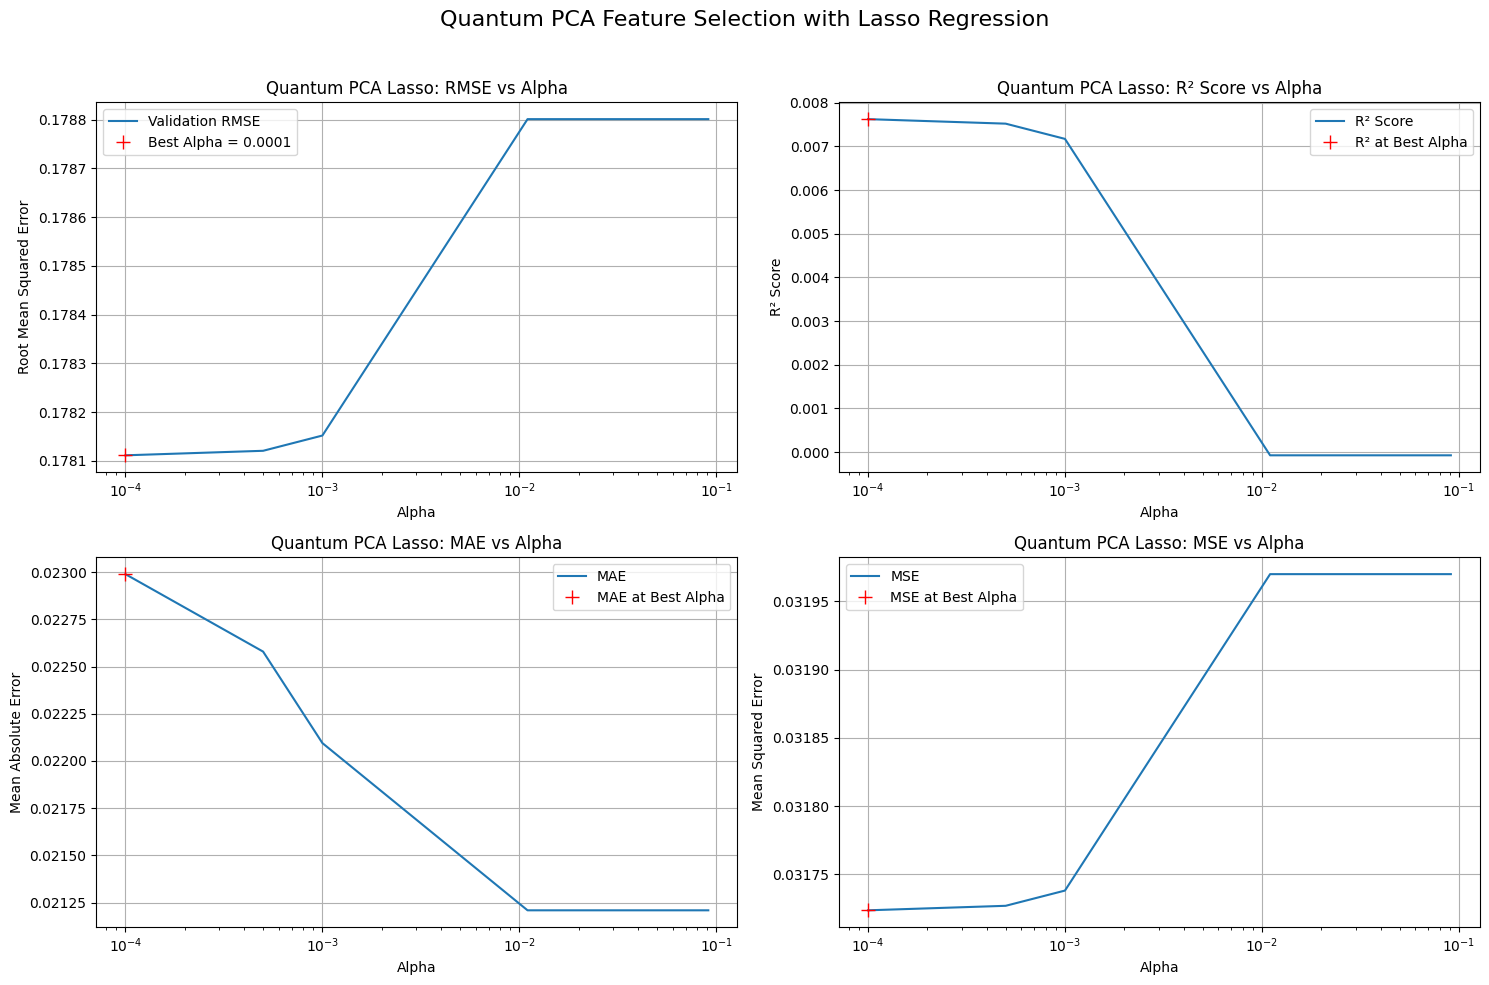


===== QUANTUM PCA LASSO REGRESSION RESULTS =====

Best Alpha: 0.0001

Final Quantum PCA Model Metrics:
   Metric        Training Set            Test Set
R-squared              0.0019              0.0076
     RMSE              0.2554              0.1781
      MAE              0.0236              0.0230
     MAPE 55417292496625.1328 59505832511086.0781
      MSE              0.0652              0.0317

Quantum PCA Feature Importance:
     Feature   Coefficient
1    I10_PR7  1.435818e-02
0    I10_PR4  1.345172e-02
2  DRG_NoPOA  7.596575e-03
3        DRG  2.705852e-17


In [127]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Define the regression accuracy function
def regression_accuracy(y_true, y_pred, tolerance=0.1):
    """
    Calculate accuracy for regression within a tolerance level
    tolerance: acceptable percentage difference (default 10%)
    """
    within_tolerance = np.abs(y_true - y_pred) <= (tolerance * np.abs(y_true))
    return np.mean(within_tolerance)

def evaluate_quantum_pca_model(y_true, y_pred):
    """
    Calculate multiple evaluation metrics for regression
    """
    # 1. R-squared (Coefficient of Determination)
    r2 = r2_score(y_true, y_pred)
    
    # 2. Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    # 3. Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_true, y_pred)
    
    # 4. Mean Absolute Percentage Error (MAPE)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    
    # 5. Mean Squared Error (MSE)
    mse = mean_squared_error(y_true, y_pred)
    
    return {
        'R-squared': r2,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'MSE': mse
    }

# Prepare features and target using Quantum PCA features
quantum_pca_features = ['I10_PR4', 'I10_PR7', 'DRG_NoPOA', 'DRG']
X = df_interpolated[quantum_pca_features].copy()

# Create target (if CostShare doesn't exist, create it)
if 'CostShare' in df_interpolated.columns:
    y = df_interpolated['CostShare'].copy()
else:
    y = df_interpolated['TOTCHG'] * np.random.uniform(0.15, 0.50, size=len(df_interpolated))

# Convert to numeric and handle missing values
for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors='coerce')

# Handle missing values
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)
y_imputed = SimpleImputer(strategy='median').fit_transform(y.values.reshape(-1, 1)).ravel()

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y_imputed, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Try different alpha values - EXPANDED RANGE to include smaller values
alphas = np.concatenate([
    np.array([0.0001, 0.0005]),  # Added smaller values
    np.arange(0.001, 0.101, 0.01)  # Original range
])
alphas.sort()  # Ensure alphas are in order

# Train Lasso models
print("Training Quantum PCA Lasso models with alphas from 0.0001 to 0.1...")
quantum_pca_metrics = []

for alpha in alphas:
    lasso_model = Lasso(alpha=alpha, max_iter=2000)
    lasso_model.fit(X_train_scaled, y_train)
    y_pred = lasso_model.predict(X_test_scaled)
    
    # Calculate all metrics
    metrics = evaluate_quantum_pca_model(y_test, y_pred)
    metrics['alpha'] = alpha
    quantum_pca_metrics.append(metrics)
    print(f"Quantum PCA Lasso Alpha: {alpha:.4f}, MSE: {metrics['MSE']:.6f}")

# Convert to DataFrame
quantum_pca_df = pd.DataFrame(quantum_pca_metrics)

# Find best alpha based on MSE
best_idx = quantum_pca_df['MSE'].idxmin()
best_alpha = quantum_pca_df.loc[best_idx, 'alpha']
best_metrics = quantum_pca_df.loc[best_idx]

print(f"\nBest Quantum PCA Lasso Alpha: {best_alpha:.4f} with MSE: {quantum_pca_df.loc[best_idx, 'MSE']:.6f}")

# Create visualizations
plt.figure(figsize=(15, 10))

# Plot 1: RMSE vs Alpha
plt.subplot(2, 2, 1)
plt.plot(alphas, quantum_pca_df['RMSE'], label='Validation RMSE')
plt.plot(best_alpha, quantum_pca_df.loc[best_idx, 'RMSE'], 'r+', markersize=10, label=f'Best Alpha = {best_alpha:.4f}')
plt.title('Quantum PCA Lasso: RMSE vs Alpha')
plt.xlabel('Alpha')
plt.ylabel('Root Mean Squared Error')
plt.xscale('log')  # Log scale for better visualization of small alphas
plt.legend()
plt.grid(True)

# Plot 2: R² vs Alpha
plt.subplot(2, 2, 2)
plt.plot(alphas, quantum_pca_df['R-squared'], label='R² Score')
plt.plot(best_alpha, quantum_pca_df.loc[best_idx, 'R-squared'], 'r+', markersize=10, label=f'R² at Best Alpha')
plt.title('Quantum PCA Lasso: R² Score vs Alpha')
plt.xlabel('Alpha')
plt.ylabel('R² Score')
plt.xscale('log')
plt.legend()
plt.grid(True)

# Plot 3: MAE vs Alpha
plt.subplot(2, 2, 3)
plt.plot(alphas, quantum_pca_df['MAE'], label='MAE')
plt.plot(best_alpha, quantum_pca_df.loc[best_idx, 'MAE'], 'r+', markersize=10, label=f'MAE at Best Alpha')
plt.title('Quantum PCA Lasso: MAE vs Alpha')
plt.xlabel('Alpha')
plt.ylabel('Mean Absolute Error')
plt.xscale('log')
plt.legend()
plt.grid(True)

# Plot 4: MSE vs Alpha
plt.subplot(2, 2, 4)
plt.plot(alphas, quantum_pca_df['MSE'], label='MSE')
plt.plot(best_alpha, quantum_pca_df.loc[best_idx, 'MSE'], 'r+', markersize=10, label=f'MSE at Best Alpha')
plt.title('Quantum PCA Lasso: MSE vs Alpha')
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error')
plt.xscale('log')
plt.legend()
plt.grid(True)

plt.suptitle('Quantum PCA Feature Selection with Lasso Regression', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust for suptitle
plt.show()

# Train final model with best alpha
quantum_pca_model = Lasso(alpha=best_alpha, max_iter=2000)
quantum_pca_model.fit(X_train_scaled, y_train)
quantum_pca_predictions = quantum_pca_model.predict(X_test_scaled)

# Calculate metrics for final model
quantum_pca_train_metrics = evaluate_quantum_pca_model(y_train, quantum_pca_model.predict(X_train_scaled))
quantum_pca_test_metrics = evaluate_quantum_pca_model(y_test, quantum_pca_predictions)

# Display metrics in a nice table format
print("\n===== QUANTUM PCA LASSO REGRESSION RESULTS =====")
print(f"\nBest Alpha: {best_alpha:.4f}")

quantum_pca_metrics_comparison = pd.DataFrame({
    'Metric': list(quantum_pca_train_metrics.keys()),
    'Training Set': list(quantum_pca_train_metrics.values()),
    'Test Set': list(quantum_pca_test_metrics.values())
})

print("\nFinal Quantum PCA Model Metrics:")
print(quantum_pca_metrics_comparison.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

# Feature importance
quantum_pca_coefficients = np.abs(quantum_pca_model.coef_)
quantum_pca_importance = pd.DataFrame(list(zip(quantum_pca_features, quantum_pca_coefficients)), 
                                columns=['Feature', 'Coefficient'])
print("\nQuantum PCA Feature Importance:")
print(quantum_pca_importance.sort_values('Coefficient', ascending=False))



adaptive lasso is not able to generalize our data and extrapolate our data even if we chage alpha. the loss function is not able to learn the gradiant decent of this data base due to its complexity. gradiant decent is the global minimum of a function because we have less error. due to the nonlinearity of our data the adaptive lasso find difficulty in predicting the global minimum becuase the model is better for linear data. 

Initial data check:

DRG value counts:
DRG
807    49039
871    38322
885    30377
470    29669
795    23718
Name: count, dtype: int64
Missing values: 0
Unique values: 763

LOS value counts:
LOS
6.0    6
Name: count, dtype: int64
Missing values: 906637
Unique values: 1

TOTCHG value counts:
TOTCHG
9.0    905850
0.0       104
1.0        60
3.0        44
2.0        43
Name: count, dtype: int64
Missing values: 0
Unique values: 83

After cleaning - missing values:
DRG       0
LOS       0
TOTCHG    0
dtype: int64
Trying alpha = 0.0000
  RMSE: 0.1011, R²: -0.0000, Accuracy (±10%): 0.1871
Trying alpha = 0.0000
  RMSE: 0.1011, R²: -0.0000, Accuracy (±10%): 0.1871
Trying alpha = 0.0000
  RMSE: 0.1011, R²: -0.0000, Accuracy (±10%): 0.1871
Trying alpha = 0.0001
  RMSE: 0.1011, R²: -0.0000, Accuracy (±10%): 0.1871
Trying alpha = 0.0002
  RMSE: 0.1011, R²: -0.0000, Accuracy (±10%): 0.1871
Trying alpha = 0.0004
  RMSE: 0.1011, R²: -0.0000, Accuracy (±10%): 0.1871
Trying alpha = 0.0008
  RMSE: 0.1011,

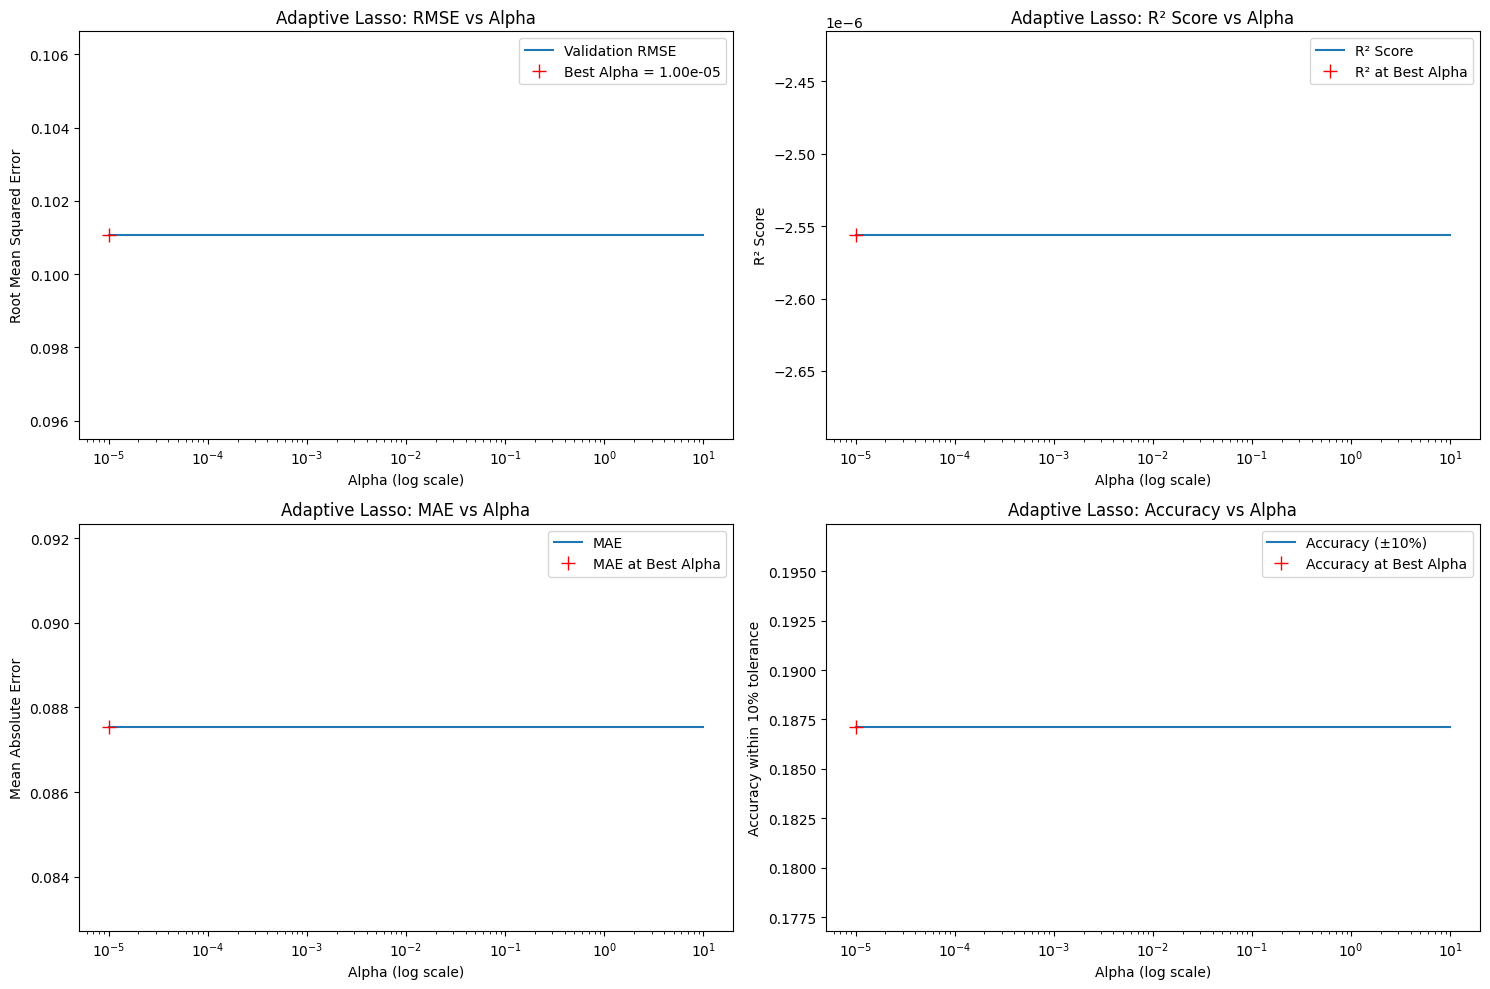


===== ADAPTIVE LASSO REGRESSION RESULTS =====

Best Alpha: 0.000010

Final Model Metrics:
         Metric  Training Set  Test Set
      R-squared        0.0000   -0.0000
           RMSE        0.1010    0.1011
            MAE        0.0875    0.0875
           MAPE        0.3179    0.3184
Accuracy (±10%)        0.1877    0.1871

Feature Importance:
  Feature  Coefficient
0     DRG          0.0
1     LOS          0.0
2  TOTCHG          0.0


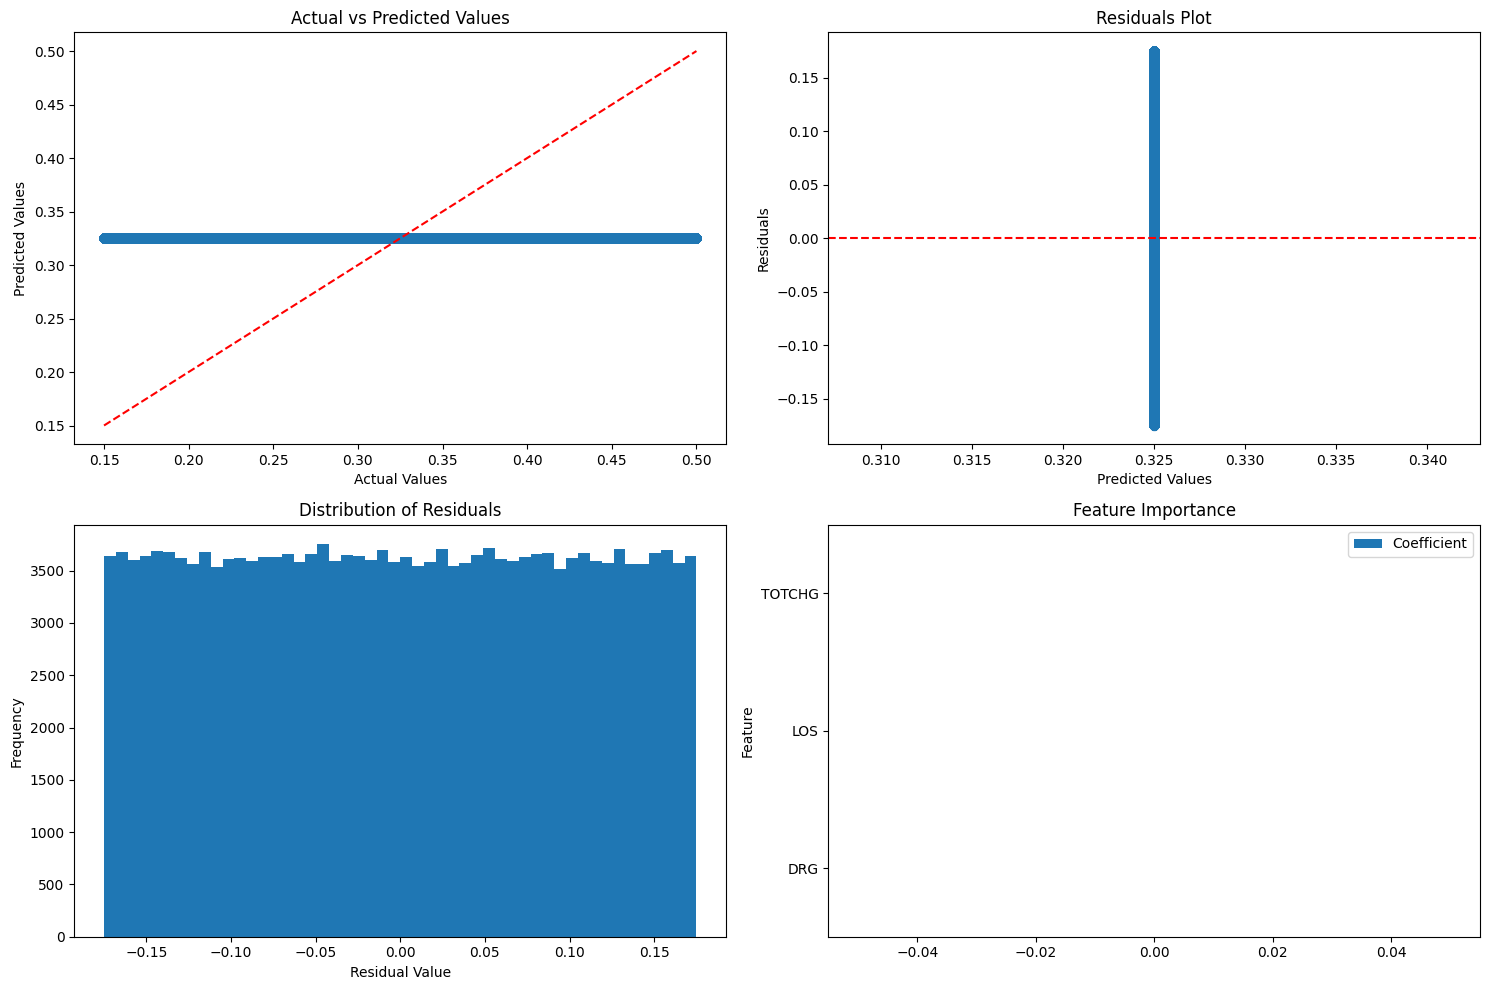


Error Distribution:
0-5%      9.26%
5-10%     9.45%
10-15%    9.77%
15-20%   10.26%
>20%     61.26%

Sample of predictions:
   TOTCHG  CostShare  CostShare_Adaptive_lasso
0     9.0   0.469879                  0.325013
1     9.0   0.262747                  0.325013
2     9.0   0.385864                  0.325013
3     9.0   0.300572                  0.325013
4     9.0   0.182537                  0.325013


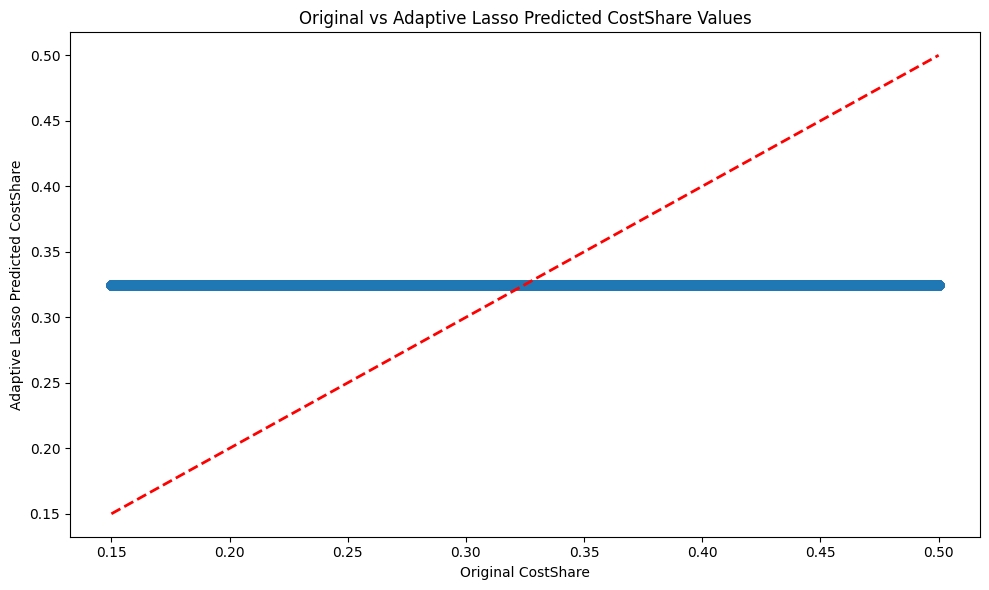


Adaptive Lasso analysis completed


In [82]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Define the regression accuracy function
def regression_accuracy(y_true, y_pred, tolerance=0.1):
    """
    Calculate accuracy for regression within a tolerance level
    tolerance: acceptable percentage difference (default 10%)
    """
    within_tolerance = np.abs(y_true - y_pred) <= (tolerance * np.abs(y_true))
    return np.mean(within_tolerance)

def evaluate_regression_model(y_true, y_pred):
    """
    Calculate multiple evaluation metrics for regression
    """
    # 1. R-squared (Coefficient of Determination)
    r2 = r2_score(y_true, y_pred)
    
    # 2. Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    # 3. Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_true, y_pred)
    
    # 4. Mean Absolute Percentage Error (MAPE)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    
    # 5. Custom Accuracy (within 10% tolerance)
    accuracy = regression_accuracy(y_true, y_pred)
    
    return {
        'R-squared': r2,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'Accuracy (±10%)': accuracy
    }

# First check data quality
print("Initial data check:")
for col in ['DRG', 'LOS', 'TOTCHG']:  # Removed PAY1 as it's missing
    print(f"\n{col} value counts:")
    print(df_5[col].value_counts().head())
    print(f"Missing values: {df_5[col].isnull().sum()}")
    print(f"Unique values: {df_5[col].nunique()}")

# Use only DRG, LOS, and TOTCHG
feature_names = ['DRG', 'LOS', 'TOTCHG']
X = df_5[feature_names].copy()

# Clean and prepare data
def clean_data(df):
    df_clean = df.copy()
    
    # Handle TOTCHG: Replace -99 with NaN and then with median
    df_clean['TOTCHG'] = df_clean['TOTCHG'].replace(-99, np.nan)
    df_clean['TOTCHG'] = df_clean['TOTCHG'].fillna(df_clean['TOTCHG'].median())
    
    # Handle LOS: Fill missing with median
    df_clean['LOS'] = pd.to_numeric(df_clean['LOS'], errors='coerce')
    df_clean['LOS'] = df_clean['LOS'].fillna(df_clean['LOS'].median())
    
    # Handle DRG: Should already be clean but ensure numeric
    df_clean['DRG'] = pd.to_numeric(df_clean['DRG'], errors='coerce')
    df_clean['DRG'] = df_clean['DRG'].fillna(df_clean['DRG'].median())
    
    return df_clean

# Clean features
X = clean_data(X)
print("\nAfter cleaning - missing values:")
print(X.isnull().sum())

# Create target if needed
if 'CostShare' not in df_5.columns:
    df_5['CostShare'] = X['TOTCHG'] * np.random.uniform(0.15, 0.50, size=len(df_5))
y = df_5['CostShare'].copy()
y = pd.to_numeric(y, errors='coerce')
y = y.fillna(y.median())

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Modified gprime function with better stability
gprime = lambda w: 1. / (2. * np.sqrt(np.abs(w) + 1e-8))

def Adaptive_lasso_Regression(X_train, y_train, alpha, weights, max_iter=2000, tol=1e-3):
    for iteration in range(5):  # 5 iterations of adaptive weights
        x_w = X_train / (weights[np.newaxis, :] + 1e-8)
        model = Lasso(
            alpha=alpha,
            fit_intercept=True,
            max_iter=max_iter,
            tol=tol
        )
        try:
            model.fit(x_w, y_train)
            coef_ = model.coef_ / (weights + 1e-8)
            weights = gprime(coef_)
        except Exception as e:
            print(f"Error in iteration {iteration}: {e}")
            return None, None
    return weights, model

# Try different alpha values
alphas = np.logspace(-5, 1, 20)
metrics_per_alpha = []
successful_alphas = []

# Initialize weights
weights = np.ones(len(feature_names))

# Fit models
for alpha in alphas:
    print(f"Trying alpha = {alpha:.4f}")
    result = Adaptive_lasso_Regression(X_train_scaled, y_train, alpha, weights.copy())
    
    if result[0] is not None:
        weights, model = result
        y_pred = model.predict(X_test_scaled / (weights[np.newaxis, :] + 1e-8))
        
        # Calculate all metrics
        metrics = evaluate_regression_model(y_test, y_pred)
        metrics['alpha'] = alpha
        metrics_per_alpha.append(metrics)
        successful_alphas.append(alpha)
        
        print(f"  RMSE: {metrics['RMSE']:.4f}, R²: {metrics['R-squared']:.4f}, Accuracy (±10%): {metrics['Accuracy (±10%)']:.4f}")

if len(metrics_per_alpha) > 0:
    # Convert to DataFrame for easier analysis
    metrics_df = pd.DataFrame(metrics_per_alpha)
    
    # Find best alpha based on RMSE
    best_alpha_idx = metrics_df['RMSE'].idxmin()
    best_alpha = metrics_df.loc[best_alpha_idx, 'alpha']
    
    # Create visualization for all metrics
    plt.figure(figsize=(15, 10))
    
    # Plot 1: RMSE vs Alpha
    plt.subplot(2, 2, 1)
    plt.semilogx(successful_alphas, metrics_df['RMSE'], label='Validation RMSE')
    plt.semilogx(best_alpha, metrics_df.loc[best_alpha_idx, 'RMSE'], 'r+', markersize=10, 
                label=f'Best Alpha = {best_alpha:.2e}')
    plt.title('Adaptive Lasso: RMSE vs Alpha')
    plt.xlabel('Alpha (log scale)')
    plt.ylabel('Root Mean Squared Error')
    plt.legend()
    
    # Plot 2: R² vs Alpha
    plt.subplot(2, 2, 2)
    plt.semilogx(successful_alphas, metrics_df['R-squared'], label='R² Score')
    plt.semilogx(best_alpha, metrics_df.loc[best_alpha_idx, 'R-squared'], 'r+', markersize=10, 
                label=f'R² at Best Alpha')
    plt.title('Adaptive Lasso: R² Score vs Alpha')
    plt.xlabel('Alpha (log scale)')
    plt.ylabel('R² Score')
    plt.legend()
    
    # Plot 3: MAE vs Alpha
    plt.subplot(2, 2, 3)
    plt.semilogx(successful_alphas, metrics_df['MAE'], label='MAE')
    plt.semilogx(best_alpha, metrics_df.loc[best_alpha_idx, 'MAE'], 'r+', markersize=10, 
                label=f'MAE at Best Alpha')
    plt.title('Adaptive Lasso: MAE vs Alpha')
    plt.xlabel('Alpha (log scale)')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    
    # Plot 4: Accuracy vs Alpha
    plt.subplot(2, 2, 4)
    plt.semilogx(successful_alphas, metrics_df['Accuracy (±10%)'], label='Accuracy (±10%)')
    plt.semilogx(best_alpha, metrics_df.loc[best_alpha_idx, 'Accuracy (±10%)'], 'r+', markersize=10, 
                label=f'Accuracy at Best Alpha')
    plt.title('Adaptive Lasso: Accuracy vs Alpha')
    plt.xlabel('Alpha (log scale)')
    plt.ylabel('Accuracy within 10% tolerance')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Fit final model with best alpha
    weights, best_model = Adaptive_lasso_Regression(X_train_scaled, y_train, best_alpha, weights)
    
    if best_model is not None:
        # Make predictions for both training and test sets
        y_pred_train = best_model.predict(X_train_scaled / (weights[np.newaxis, :] + 1e-8))
        y_pred_test = best_model.predict(X_test_scaled / (weights[np.newaxis, :] + 1e-8))
        
        # Calculate final metrics
        train_metrics = evaluate_regression_model(y_train, y_pred_train)
        test_metrics = evaluate_regression_model(y_test, y_pred_test)
        
        # Display metrics in a nice table format
        print("\n===== ADAPTIVE LASSO REGRESSION RESULTS =====")
        print(f"\nBest Alpha: {best_alpha:.6f}")
        
        metrics_comparison = pd.DataFrame({
            'Metric': list(train_metrics.keys()),
            'Training Set': list(train_metrics.values()),
            'Test Set': list(test_metrics.values())
        })
        
        print("\nFinal Model Metrics:")
        print(metrics_comparison.to_string(index=False, float_format=lambda x: f"{x:.4f}"))
        
        # Feature importance
        coefficients = np.abs(best_model.coef_ / (weights + 1e-8))
        feature_importance = pd.DataFrame({
            'Feature': feature_names,
            'Coefficient': coefficients
        })
        print("\nFeature Importance:")
        print(feature_importance.sort_values('Coefficient', ascending=False))
        
        # Additional visualizations
        plt.figure(figsize=(15, 10))
        
        # 1. Actual vs Predicted
        plt.subplot(2, 2, 1)
        plt.scatter(y_test, y_pred_test, alpha=0.5)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
        plt.title('Actual vs Predicted Values')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        
        # 2. Residuals Plot
        plt.subplot(2, 2, 2)
        residuals = y_test - y_pred_test
        plt.scatter(y_pred_test, residuals, alpha=0.5)
        plt.axhline(y=0, color='r', linestyle='--')
        plt.title('Residuals Plot')
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        
        # 3. Residuals Distribution
        plt.subplot(2, 2, 3)
        plt.hist(residuals, bins=50)
        plt.title('Distribution of Residuals')
        plt.xlabel('Residual Value')
        plt.ylabel('Frequency')
        
        # 4. Feature Importance
        plt.subplot(2, 2, 4)
        feature_importance = feature_importance.sort_values('Coefficient', ascending=True)
        feature_importance.plot(kind='barh', x='Feature', y='Coefficient', ax=plt.gca())
        plt.title('Feature Importance')
        
        plt.tight_layout()
        plt.show()
        
        # Error Distribution Analysis
        print("\nError Distribution:")
        error_ranges = [0, 0.05, 0.10, 0.15, 0.20, float('inf')]
        error_labels = ['0-5%', '5-10%', '10-15%', '15-20%', '>20%']
        percentage_errors = np.abs((y_test - y_pred_test) / y_test)
        error_distribution = pd.cut(percentage_errors, bins=error_ranges, labels=error_labels)
        
        # Get value counts and convert to percentage
        counts = error_distribution.value_counts()
        percentage = (counts / counts.sum() * 100).sort_index()
        print(percentage.to_string(header=False, float_format=lambda x: f"{x:.2f}%"))
        
        # Add predictions to original dataframe
        X_scaled = scaler.transform(X)
        df_5['CostShare_Adaptive_lasso'] = best_model.predict(X_scaled / (weights[np.newaxis, :] + 1e-8))
        
        # Show sample of results
        print("\nSample of predictions:")
        print(df_5[['TOTCHG', 'CostShare', 'CostShare_Adaptive_lasso']].head())
        
        # Final visualization
        plt.figure(figsize=(10, 6))
        plt.scatter(df_5['CostShare'], df_5['CostShare_Adaptive_lasso'], alpha=0.5)
        plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
        plt.xlabel('Original CostShare')
        plt.ylabel('Adaptive Lasso Predicted CostShare')
        plt.title('Original vs Adaptive Lasso Predicted CostShare Values')
        plt.tight_layout()
        plt.show()
        
        # Save results
        results = {
            'predictions': pd.DataFrame({
                'Actual': y_test,
                'Predicted': y_pred_test,
                'Error': residuals
            }),
            'metrics': test_metrics,
            'best_alpha': best_alpha,
            'feature_importance': feature_importance
        }
        
        print("\nAdaptive Lasso analysis completed")
else:
    print("No successful models were fit. Try adjusting the parameters.")